# 03 Further data exploration and creation of text chunks

In this notebook we will further explore the books. We will try to answer the following questions:
<ul>
    <li>are there any <b>style elements</b> that can be seen before we do the actual text classification with embeddings? For this, we will analyse the text at character level, including punctuations, the distribution of word and sentence lengths, the parts of speech, and the highly author-specific words (using tf-idf and log likelihood). </li>
    <li> how can we avoid that the <b>classifier uses style elements and not other elements</b> such as the names mentioned in a book or the book's formatting to classify a text?</li>
    <li>are there any boooks that <b>belong together</b>? We will use three methods: tf-idf, shared named entities and metadata similarity. As an aside, we will show how named entity recognition can show us some aspects of the structure of a fictional book. </li>
    <li> what is a reasonable <b>unit of analysis</b> for the classification?</li>

</ul>
Furthermore, we will create text chunks, the text units that we will analyse.

In [1]:
import pandas as pd
import os
import re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #we supress the tensorflow info messages
no_dupl=pd.read_csv('no_dupl.csv', index_col=0)
no_dupl

title  \
number                                                    
34204                                 La petite Fadette   
24850                                           Lourdes   
41054         Cours familier de Littérature - Volume 07   
63794   La comédie de celui qui épousa une femme muette   
12367              Le péché de Monsieur Antoine, Tome 1   
...                                                 ...   
13668                           Le château des Désertes   
37604         Cours familier de Littérature - Volume 10   
17693                            La San-Felice, Tome 01   
7772                         Les Quarante-Cinq — Tome 3   
17660                                 L'archipel en feu   

                       author     length    year  
number                                            
34204             George Sand   331806.0  1869.0  
24850              Émile Zola  1068528.0  1894.0  
41054   Alphonse de Lamartine   505709.0  1859.0  
63794          Anatole France    48980.0  1912.0  
12367             George Sand   559615.0  1845.0  
...                       ...        ...     ...  
13668             George Sand   294819.0     NaN  
37604   Alphonse de Lamartine   450970.0  1860.0  
17693         Alexandre Dumas   388396.0  1800.0  
7772          Alexandre Dumas   459954.0     NaN  
17660             Jules Verne   362647.0  1884.0  

[307 rows x 4 columns]

## First look at character distributions

Let's import the texts, put them in a dictionary and let's count all the different characters.

In [2]:
from collections import Counter
def readbook(number):
    filename=os.path.join("stripped_filtered", no_dupl.loc[number, "author"], str(number))
    with open(filename, 'r') as f:
        booktext=f.read()
    return booktext
text={}
letter_counts_text={}
letter_counts_global=Counter()
for i, row in no_dupl.iterrows():
    text[i]=readbook(i)
    letter_counts_text[i]=Counter(text[i])
    letter_counts_global.update(letter_counts_text[i])

Let's first take a look at the distribution of all the different character frequencies across the books. Do these frequency distributions reveal any anomaly? Specifically, we look at the books where more than 5 characters have a high zscore (more than 4 or less than -4).

In [3]:
letter_anal_df=no_dupl[['author', 'title']].copy()
for i in letter_anal_df.index:
    text_length=len(text[i])
    for letter, count in letter_counts_text[i].items():
        letter_anal_df.loc[i, letter]=count/text_length
    letter_anal_df=letter_anal_df.copy()
letter_anal_df=letter_anal_df.fillna(0)

In [4]:
letter_anal_zscore=letter_anal_df.copy()
for col in letter_anal_zscore.columns.drop(['author', 'title']):
    letter_anal_zscore[col]=(letter_anal_zscore[col] - letter_anal_zscore[col].mean()) / letter_anal_zscore[col].std()

for i, row in letter_anal_zscore.iterrows():
    row_n=row.drop(['author', 'title'])
    if (abs(row_n)>4).sum()>5:
        print(row['author'], row['title'], i)
        print('Too many:', ', '.join(list(row_n[row_n>4].index)))
        print('Not enough:', ', '.join(list(row_n[row_n<-4].index)), '\n')


Anatole France La comédie de celui qui épousa une femme muette 63794
Too many: A, I, D, M, î, O, T, z, N, R, É, È
Not enough:  

Victor Hugo Actes et Paroles, Volume 1 8186
Too many: e, (, )
Not enough: è, ê, é, à 

Victor Hugo Le Roi s'amuse 29549
Too many: B, I, D, L, M, 
, Q, E, O, !, T, N, U, _, R, À, Ô
Not enough:  

Jules Verne Autour de la Lune 4717
Too many: °, \, %, {, }, ^
Not enough:  

Marcel Proust Pastiches et mélanges 64145
Too many: §, δ, η, μ, ϐ, ρ
Not enough:  

Gustave Flaubert Œuvres complètes de Gustave Flaubert, tome 8 70260
Too many: A, ., I, L, M, S, 
, E, O, !, T, N, U, (, ), R, Ê, È, Œ
Not enough:  

Victor Hugo Hernani 9976
Too many: y, h, D, O, N, _, H, [, ], (, ), R, Y, w, Z, ñ, Ñ, 	, í
Not enough: u 

Marcel Proust Les plaisirs et les jours 58698
Too many: γ, α, λ, χ, τ, ο, ς, δ, μ, ρ, ä, ὐ, ε, ι, ἐ, π, ἀ, ῒ, ό, ν, ά, κ, υ, έ, σ, ξ, ΰ, ἔ, θ, ὑ, ὂ, ἒ, Κ, ύ, ἲ, ἤ, ἂ, β
Not enough:  

Guy de Maupassant Œuvres complètes de Guy de Maupassant - volume 15 60610
T

This simple analysis already reveals some genre differences and some problems.

<ul>
    <li>The following are plays and simply include the protagonists's name in capital letters, which is not a problem: Anatole France: La comédie de celui qui épousa une femme muette (63794), Victor Hugo: Le Roi s'amuse 29549, plays in Gustave Flaubert: Œuvres complètes de Gustave Flaubert, tome 8 (70260), Victor Hugo: Hernani (9976), George Sand: Gabriel (13380), Victor Hugo: Ruy Blas: Drame (60354), Victor Hugo: La Esmeralda (13628), Alexandre Dumas: Henri III et sa Cour (2682), George Sand: Cadio (28977).</li>
    <li>The first three volumes of Victor Hugo: Actes et Paroles <b>(8186, 8454, 8453) have to be excluded</b> as the accents are missing and it would be quite difficult to repair the files.</li>
    <li>Jules Verne: Autour de la Lune (4717) and Jules Verne: Sans dessus dessous (12533) contain formulas, the formatting of which is not the choice of the author but having formulas in the his books is, so we keep it in.</li>
    <li>Marcel Proust: Pastiches et mélanges (64145), Marcel Proust: Les plaisirs et les jours (58698) - these are rare occurrences and including Greek quotes is part of the author's style.</li>
    <li>Guy de Maupassant: Œuvres complètes de Guy de Maupassant - volume 15 (60610): <b>the ’ character should be converted to normal apostrophe</b>. The modifier letters (the very small ones) only occur in this text, so it does not help our classifier to classify a text, we can leave it.</li>
    <li>There does not seem to be anything off with Jules Verne Les tribulations d'un chinois en Chine 14162</li>
    <li>Victor Hugo à vingt ans: Glanes romantiques <b>(66834) was not written by Victor Hugo, we leave it out</b></li>
    <li>Anatole France: Vie de Jeanne d'Arc <b>(33692 and 33693) contain extensive academic notes, which make it too easily recognizable, we leave them out</b></li>
</ul>

    
    

In [5]:
no_dupl=no_dupl.drop([8186, 8454, 8453, 66834, 33692,33693])
text={}
letter_counts_text={}
letter_counts_global=Counter()
for i, row in no_dupl.iterrows():
    text[i]=readbook(i)
    letter_counts_text[i]=Counter(text[i])
    letter_counts_global.update(letter_counts_text[i])

## Punctuation analysis

The first obvious thing to analyse is the number of characters, the number of paragraphs (which are now seperated with single new lines and not double ones as in the original gutenberg raw texts) and the number of different punctuation marks.

What are the punctuation marks? Let's look at the non-alphanumerical characters in our character counter:

In [6]:
text_anal_df=no_dupl[['author', 'title']].copy()

In [7]:
print(Counter({k:v for k, v in letter_counts_global.items() if not k.isalnum()}).most_common())

[(' ', 17077860), (',', 1668798), ("'", 1058278), ('.', 925492), ('-', 572144), ('\n', 426674), (';', 146923), ('!', 139684), ('’', 109667), ('?', 90223), ('_', 67560), (':', 61841), ('«', 48199), ('»', 40904), ('—', 23100), ('(', 6735), (')', 6733), ('\xa0', 4788), ('[', 3710), (']', 3683), ('*', 2884), ('"', 1212), ('\x92', 869), ('°', 840), ('…', 744), ('=', 710), ('<', 455), ('>', 345), ('&', 242), ('\xad', 167), ('′', 111), ('\x9c', 95), ('´', 61), ('+', 38), ('}', 34), ('\\', 33), ('{', 32), ('/', 30), ('·', 21), ('§', 12), ('“', 11), ('”', 11), ('^', 10), ('|', 5), ('\t', 5), ('¯', 5), ('%', 4), ('∫', 4), ('–', 4), ('`', 3), ('″', 2), ('#', 2), ('√', 2), ('~', 1), ('¨', 1), ('\x8c', 1), ('\x91', 1), ('∞', 1), ('−', 1)]


Let's concentrate on the most important ones, up until the ellipses character.

In [8]:
common_punct_counts=Counter({k:v for k, v in letter_counts_global.items() if not k.isalnum()}).most_common(26)
common_punct=[k for k, v in common_punct_counts]
print(common_punct)

[' ', ',', "'", '.', '-', '\n', ';', '!', '’', '?', '_', ':', '«', '»', '—', '(', ')', '\xa0', '[', ']', '*', '"', '\x92', '°', '…', '=']


In [9]:
def punctanal(df, list_of_puncts):
    for i in text_anal_df.index:
        for punct in list_of_puncts:
            if punct=='\n':
                column_name='paras'
            elif punct==' ':
                column_name='spaces'
            elif punct=='\xa0':
                column_name='non_br_sps'
            elif punct=='\x92':
                column_name='private use twos'
            else:
                column_name=punct+'s'
            if len(punct)==1:
                df.loc[i, column_name]=letter_counts_text[i][punct]
        if '...' in list_of_puncts:
            df.loc[i, '...s']=text[i].count('...')
        if '--' in list_of_puncts:
            pattern_one_hyphen = re.compile('(?<!-)-(?!-)')
            pattern_two_hyphens = re.compile('(?<!-)--(?!-)')
            df.loc[i, '-s'] = len(pattern_one_hyphen.findall(text[i]))
            df.loc[i, '--s'] = len(pattern_two_hyphens.findall(text[i]))
        if '---' in list_of_puncts:
            pattern_one_hyphen = re.compile('(?<!-)-(?!-)')
            pattern_two_hyphens = re.compile('(?<!-)--(?!-)')
            pattern_three_hyphens = re.compile('(?<!-)---(?!-)')
            df.loc[i, '-s'] = len(pattern_one_hyphen.findall(text[i]))
            df.loc[i, '--s'] = len(pattern_two_hyphens.findall(text[i]))
            df.loc[i, '---s'] = len(pattern_three_hyphens.findall(text[i]))
        df.loc[i, "chars"]=len(text[i])

    
punctanal(text_anal_df, common_punct+['...', '--', '---'])
print('Punctuation, character and paragraph counts:') 
with pd.option_context('display.max_columns', None):
    display(text_anal_df)

Punctuation, character and paragraph counts:


author  \
number                          
34204             George Sand   
24850              Émile Zola   
41054   Alphonse de Lamartine   
63794          Anatole France   
12367             George Sand   
...                       ...   
13668             George Sand   
37604   Alphonse de Lamartine   
17693         Alexandre Dumas   
7772          Alexandre Dumas   
17660             Jules Verne   

                                                  title    spaces       ,s  \
number                                                                       
34204                                 La petite Fadette   40019.0   3597.0   
24850                                           Lourdes  118651.0  16715.0   
41054         Cours familier de Littérature - Volume 07   57540.0   4717.0   
63794   La comédie de celui qui épousa une femme muette    4109.0    338.0   
12367              Le péché de Monsieur Antoine, Tome 1   64480.0   5735.0   
...                                                 ...       ...      ...   
13668                           Le château des Désertes   33987.0   2851.0   
37604         Cours familier de Littérature - Volume 10   51300.0   4441.0   
17693                            La San-Felice, Tome 01   43133.0   4722.0   
7772                         Les Quarante-Cinq — Tome 3   51271.0   5573.0   
17660                                 L'archipel en feu   39686.0   4109.0   

            's      .s      -s   paras     ;s      !s   ’s     ?s     _s  \
number                                                                     
34204   3006.0  1245.0   467.0   514.0  348.0    63.0  0.0   77.0   30.0   
24850   8050.0  6538.0  1206.0  1980.0  613.0  1017.0  0.0  386.0  110.0   
41054   3591.0  2347.0   755.0  1172.0  882.0   718.0  0.0  202.0  710.0   
63794    267.0   544.0   111.0   347.0   30.0    69.0  0.0   64.0   14.0   
12367   4569.0  2872.0   872.0  1202.0  586.0   486.0  0.0  376.0  138.0   
...        ...     ...     ...     ...    ...     ...  ...    ...    ...   
13668   2531.0  1570.0   495.0   419.0  343.0   285.0  0.0  170.0  244.0   
37604   3317.0  2637.0   452.0   707.0  657.0   176.0  0.0   99.0  248.0   
17693   2696.0  1307.0   747.0  1104.0  614.0   223.0  0.0  119.0  122.0   
7772    3469.0  2639.0   920.0  2779.0  672.0   717.0  0.0  548.0   84.0   
17660   2757.0  2202.0   541.0   974.0   57.0   545.0  0.0  170.0  316.0   

           :s     «s     »s   —s    (s    )s  non_br_sps    [s    ]s    *s  \
number                                                                       
34204    98.0    6.0    6.0  0.0   3.0   3.0         0.0   2.0   2.0   0.0   
24850   341.0   74.0   72.0  0.0   0.0   0.0         0.0   0.0   0.0   0.0   
41054   180.0  368.0  226.0  0.0  64.0  64.0         0.0   0.0   0.0  15.0   
63794    25.0   11.0   11.0  0.0   9.0   9.0         0.0   0.0   0.0   0.0   
12367   186.0  294.0  167.0  0.0   8.0   8.0         0.0   2.0   2.0   0.0   
...       ...    ...    ...  ...   ...   ...         ...   ...   ...   ...   
13668   122.0   39.0   31.0  0.0  24.0  24.0         0.0   7.0   7.0   6.0   
37604   247.0  117.0   70.0  0.0  14.0  14.0         0.0   0.0   0.0  20.0   
17693   192.0   29.0  148.0  0.0   1.0   1.0         0.0  10.0  10.0   0.0   
7772    207.0   10.0   10.0  0.0   0.0   0.0         0.0  15.0  15.0   0.0   
17660    61.0  128.0  122.0  0.0   0.0   0.0         0.0   2.0   2.0   0.0   

         "s  private use twos   °s   …s   =s   ...s     --s  ---s     chars  
number                                                                       
34204   0.0               0.0  0.0  0.0  0.0    7.0   242.0   0.0  224031.0  
24850   0.0               0.0  0.0  0.0  0.0  539.0   847.0   0.0  739414.0  
41054   0.0               0.0  0.0  0.0  0.0   79.0   118.0   0.0  346062.0  
63794   0.0               0.0  0.0  0.0  0.0   41.0     1.0   0.0   26852.0  
12367   0.0               0.0  0.0  0.0  0.0  126.0   577.0   0.0  384131.0  
...     ...               ..

Let's look at the character frequency per character and how it differs according to author.

In [10]:
main_cols=text_anal_df.columns.drop(['author', 'title'])
text_anal_ratio=text_anal_df.groupby('author').agg({col:'sum' for col in main_cols})

for col in main_cols.drop(['chars']):
    text_anal_ratio[col]=text_anal_ratio[col]/text_anal_ratio['chars']
print('Mean density of punctuation marks (punctuation mark/char):') 
with pd.option_context('display.max_columns', None):
    display(text_anal_ratio)

Mean density of punctuation marks (punctuation mark/char):


spaces        ,s        's        .s        -s  \
author                                                                    
Alexandre Dumas        0.163047  0.016657  0.008733  0.008478  0.002969   
Alphonse de Lamartine  0.166033  0.014129  0.011038  0.007158  0.001961   
Anatole France         0.164776  0.013683  0.011401  0.009763  0.001821   
George Sand            0.168168  0.013962  0.011720  0.007989  0.002476   
Gustave Flaubert       0.156174  0.016550  0.010432  0.010475  0.001942   
Guy de Maupassant      0.161978  0.017312  0.010343  0.011489  0.001940   
Jules Verne            0.157939  0.015825  0.008310  0.009852  0.002754   
Marcel Proust          0.166280  0.013867  0.011017  0.005584  0.002059   
Victor Hugo            0.162694  0.015366  0.009048  0.009559  0.002625   
Émile Zola             0.163205  0.020514  0.010891  0.010327  0.002151   

                          paras        ;s        !s            ’s        ?s  \
author                                                                        
Alexandre Dumas        0.006682  0.001877  0.001568  2.080965e-03  0.001364   
Alphonse de Lamartine  0.002695  0.002052  0.000850  0.000000e+00  0.000479   
Anatole France         0.002916  0.000740  0.000555  7.493234e-07  0.000482   
George Sand            0.002864  0.001623  0.001249  4.426095e-04  0.000889   
Gustave Flaubert       0.005890  0.002051  0.003152  0.000000e+00  0.000813   
Guy de Maupassant      0.005759  0.001146  0.001088  5.157795e-04  0.000956   
Jules Verne            0.004309  0.000582  0.001563  1.979571e-03  0.000809   
Marcel Proust          0.000855  0.000544  0.000356  1.836326e-03  0.000301   
Victor Hugo            0.004603  0.001616  0.001575  2.174029e-03  0.000908   
Émile Zola             0.002967  0.001066  0.001355  0.000000e+00  0.000625   

                             _s        :s        «s        »s        —s  \
author                                                                    
Alexandre Dumas        0.000370  0.000686  0.000283  0.000255  0.000968   
Alphonse de Lamartine  0.001204  0.000670  0.000839  0.000397  0.000000   
Anatole France         0.000690  0.000777  0.000304  0.000395  0.000000   
George Sand            0.000852  0.000473  0.000345  0.000272  0.000019   
Gustave Flaubert       0.000521  0.000685  0.000876  0.000834  0.000000   
Guy de Maupassant      0.000520  0.001622  0.000884  0.000826  0.000000   
Jules Verne            0.000707  0.000239  0.000667  0.000626  0.000098   
Marcel Proust          0.000315  0.000511  0.000975  0.000956  0.000040   
Victor Hugo            0.001312  0.000697  0.000338  0.000282  0.000000   
Émile Zola             0.000172  0.000515  0.000210  0.000210  0.000000   

                             (s        )s    non_br_sps        [s        ]s  \
author                                                                        
Alexandre Dumas        0.000013  0.000013  0.000000e+00  0.000011  0.000011   
Alphonse de Lamartine  0.000089  0.000089  1.203946e-04  0.000023  0.000023   
Anatole France         0.000063  0.000063  0.000000e+00  0.000054  0.000054   
George Sand            0.000095  0.000095  4.951821e-06  0.000059  0.000059   
Gustave Flaubert       0.000211  0.000211  0.000000e+00  0.000020  0.000020   
Guy de Maupassant      0.000038  0.000038  4.721094e-07  0.000015  0.000015   
Jules Verne            0.000042  0.000042  5.385284e-06  0.000051  0.000051   
Marcel Proust          0.000269  0.000269  0.000000e+00  0.000034  0.000034   
Victor Hugo            0.000082  0.000082  1.080287e-04  0.000097  0.000093   
Émile Zola             0.000003  0.000003  1.843532e-04  0.000004  0.000004   

                             *s            "s  private use twos            °s  \
author                                                                          
Alexandre Dumas        0.000017  4.572345e-07      3.246365e-05  5.075302e-06   
Alphonse de Lamartine  0.000040  1.102514e-07      0.000000e+00  4.410057e-07   
A

What do these differences tell us? Some of these are true differences of style. Whether an author uses a question mark often is clearly indicative of their style. However, there are other differences: most texts use three dots for indicating the ellipsis, some of them use the unicode character U+2026. Most texts use -- for dialogues but some use em-dash. Most texts use « and » for quotations, some use ". Some texts include non-breaking spaces.

These are not the choice by the author, but the choice of whoever typed, formatted etc. the text. But they make it very easy for the classifier to recognise a text: if a text uses an em-dash, for example, we know it must be Dumas, Sand, Verne or Proust:

In [11]:
text_anal_ratio['—s']

author
Alexandre Dumas          0.000968
Alphonse de Lamartine    0.000000
Anatole France           0.000000
George Sand              0.000019
Gustave Flaubert         0.000000
Guy de Maupassant        0.000000
Jules Verne              0.000098
Marcel Proust            0.000040
Victor Hugo              0.000000
Émile Zola               0.000000
Name: —s, dtype: float64

Therefore, we want to eliminate these punctuation differences. This is an iterative process with a lot of manual work, the following is a first effort.

Furthermore, we transform the oe and ae ligatures to letters. 

In [12]:
punct_replace_dict={}
punct_replace_dict['simple']={'…': '...', '---':'—', '--': '—', '–': '—', '«': '"', '»': '"', '\xa0': ' ', '\x92':"'", 'œ':'oe', 'æ':'ae', 'Œ':'OE', 'Æ':'AE', "’":"'"}
punct_replace_dict['regex']={}
def multiple_replace(string, r_dict):
    for k, v in r_dict['simple'].items():
        string=string.replace(k,v)
    for k, v in r_dict['regex'].items():
        string=re.sub(re.compile(k), v, string)
    return string

def replace_punct(text_dict, replace_dict):
    for idx, text in text_dict.items():
        text_dict[idx]=multiple_replace(text_dict[idx], replace_dict)
    return text_dict
text=replace_punct(text, punct_replace_dict)


We now redo the analysis.

In [13]:
text_anal_df=no_dupl[['author', 'title']].copy()
common_punct_filtered=list(set(common_punct)-set(punct_replace_dict['simple'].keys()))
punctanal(text_anal_df, common_punct_filtered+['...'])
with pd.option_context('display.max_columns', None):
    display(text_anal_df)

author  \
number                          
34204             George Sand   
24850              Émile Zola   
41054   Alphonse de Lamartine   
63794          Anatole France   
12367             George Sand   
...                       ...   
13668             George Sand   
37604   Alphonse de Lamartine   
17693         Alexandre Dumas   
7772          Alexandre Dumas   
17660             Jules Verne   

                                                  title      .s      's    ]s  \
number                                                                          
34204                                 La petite Fadette  1245.0  3006.0   2.0   
24850                                           Lourdes  6538.0  8050.0   0.0   
41054         Cours familier de Littérature - Volume 07  2347.0  3591.0   0.0   
63794   La comédie de celui qui épousa une femme muette   544.0   267.0   0.0   
12367              Le péché de Monsieur Antoine, Tome 1  2872.0  4569.0   2.0   
...                                                 ...     ...     ...   ...   
13668                           Le château des Désertes  1570.0  2531.0   7.0   
37604         Cours familier de Littérature - Volume 10  2637.0  3317.0   0.0   
17693                            La San-Felice, Tome 01  1307.0  2696.0  10.0   
7772                         Les Quarante-Cinq — Tome 3  2639.0  3469.0  15.0   
17660                                 L'archipel en feu  2202.0  2757.0   2.0   

           ?s   "s     ;s      !s    *s       ,s      -s   =s   —s     _s  \
number                                                                      
34204    77.0  0.0  348.0    63.0   0.0   3597.0   951.0  0.0  0.0   30.0   
24850   386.0  0.0  613.0  1017.0   0.0  16715.0  2900.0  0.0  0.0  110.0   
41054   202.0  0.0  882.0   718.0  15.0   4717.0   991.0  0.0  0.0  710.0   
63794    64.0  0.0   30.0    69.0   0.0    338.0   113.0  0.0  0.0   14.0   
12367   376.0  0.0  586.0   486.0   0.0   5735.0  2026.0  0.0  0.0  138.0   
...       ...  ...    ...     ...   ...      ...     ...  ...  ...    ...   
13668   170.0  0.0  343.0   285.0   6.0   2851.0  1001.0  0.0  0.0  244.0   
37604    99.0  0.0  657.0   176.0  20.0   4441.0   530.0  0.0  0.0  248.0   
17693   119.0  0.0  614.0   223.0   0.0   4722.0  1529.0  0.0  0.0  122.0   
7772    548.0  0.0  672.0   717.0   0.0   5573.0  4338.0  0.0  0.0   84.0   
17660   170.0  0.0   57.0   545.0   0.0   4109.0  1203.0  0.0  0.0  316.0   

          )s    spaces   °s   paras    [s    (s     :s   ...s     chars  
number                                                                   
34204    3.0   40019.0  0.0   514.0   2.0   3.0   98.0    7.0  223790.0  
24850    0.0  118651.0  0.0  1980.0   0.0   0.0  341.0  539.0  738912.0  
41054   64.0   57540.0  0.0  1172.0   0.0  64.0  180.0   79.0  345946.0  
63794    9.0    4109.0  0.0   347.0   0.0   9.0   25.0   41.0   26851.0  
12367    8.0   64480.0  0.0  1202.0   2.0   8.0  186.0  126.0  383654.0  
...      ...       ...  ...     ...   ...   ...    ...    ...       ...  
13668   24.0   33987.0  1.0   419.0   7.0  24.0  122.0   63.0  199573.0  
37604   14.0   51300.0  0.0   707.0   0.0  14.0  247.0   25.0  305427.0  
17693    1.0   43133.0  3.0  1104.0  10.0   1.0  192.0   27.0  262891.0  
7772     0.0   51271.0  0.0  2779.0  15.0   0.0  207.0   54.0  311237.0  
17660    0.0   39686.0  0.0   974.0   2.0   0.0   61.0  174.0  246424.0  

[301 rows x 24 columns]

Another obviuos aspect to analyse would be the length of words and sentences. While we can determine the number of words (and sentences) in a crude way, by splitting on spaces (and, for sentences, on certain punctuation marks), there are ready-made tools which can do it with less error and allow further analysis. We will use spacy.

## Analysis with spacy - first look at sentence length distributions

For every sentence we create an nlp model of every text with spacy. This is a long process (30 minutes on my iMac 2019), but will allow POS tagging and recognizing named entities as well.

In [14]:
import spacy
nlp = spacy.load('fr_core_news_lg')
nlp.max_length=int(text_anal_df["chars"].max())

In [15]:
import time
docs={}
for i, number in enumerate(text_anal_df.index):
    if i%30==0:
        print("{} {}/{}".format(time.ctime(), i, len(text_anal_df.index)))
    docs[number]=nlp(text[number].replace('\n', ' '))

Sat Apr  1 17:18:38 2023 0/301
Sat Apr  1 17:22:16 2023 30/301
Sat Apr  1 17:25:24 2023 60/301
Sat Apr  1 17:28:47 2023 90/301
Sat Apr  1 17:31:38 2023 120/301
Sat Apr  1 17:35:25 2023 150/301
Sat Apr  1 17:38:47 2023 180/301
Sat Apr  1 17:42:23 2023 210/301
Sat Apr  1 17:46:08 2023 240/301
Sat Apr  1 17:49:19 2023 270/301
Sat Apr  1 17:52:44 2023 300/301


We calculate the number of tokens and sentences and add it to the text_anal_df dataframe and we plot the distribution of sentence lengths in the oeuvre of each author. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

non_punct_tokens={}
s={}
for i in text_anal_df.index:
    text_anal_df.loc[i, "tokens"]=len(docs[i])
    non_punct_tokens[i]=[len(token) for token in docs[i] if token.pos_!="PUNCT"] #we collect the token length information for book i in non_punct_tokens[i]
    text_anal_df.loc[i, "non_punct_len"]=sum(non_punct_tokens[i])
    text_anal_df.loc[i, "non_punct_tokens"]=len(non_punct_tokens[i])
    assert docs[i].has_annotation("SENT_START")
    s[i]=[len(sent) for sent in docs[i].sents] #we collect the sentence length information for book i in s[i]
    text_anal_df.loc[i, "sentence_len"]=sum(s[i])
    text_anal_df.loc[i, "sentences"]=len(s[i])

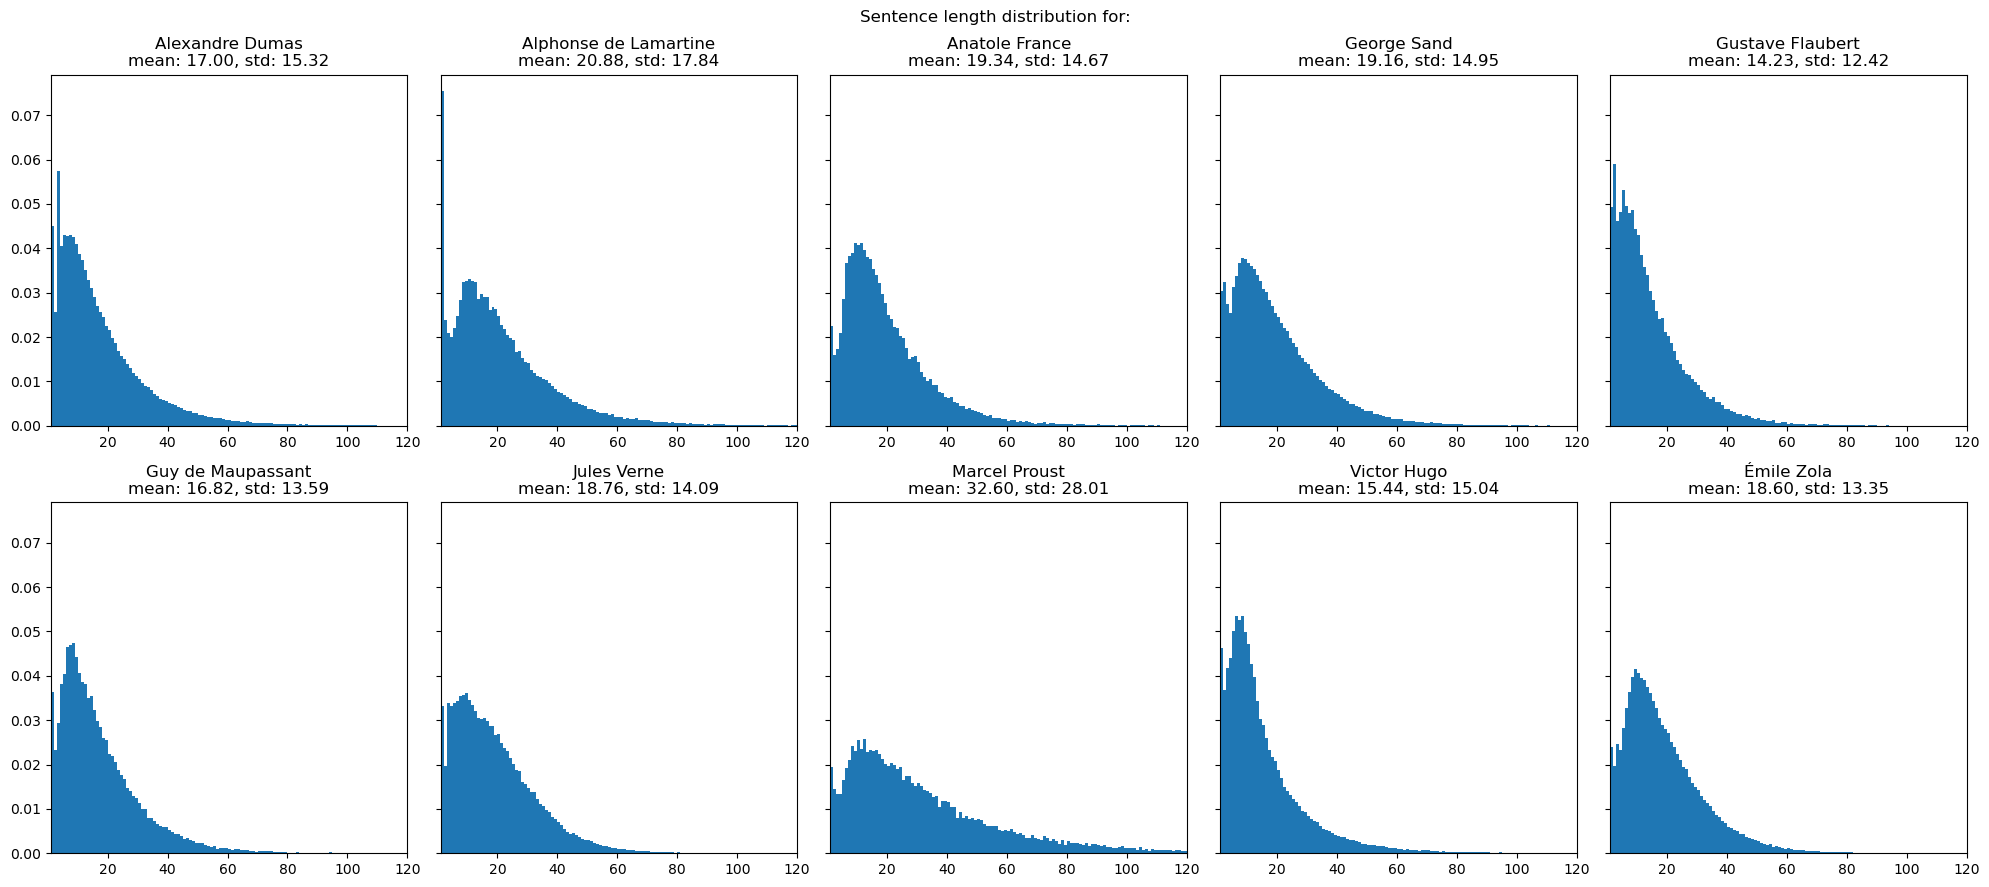

In [17]:
def distribution_chart(lengths, xticks, xlim_low, xlim_high, bins, title):
    fig, axs = plt.subplots(2, 5, sharey=True,  figsize=(20, 9))
    graph_number=0

    for author, group in text_anal_df.groupby('author'):
        distr=[]
        for i in group.index:
            distr+=lengths[i]
        ax=axs.flat[graph_number]
        ax.hist(distr, density=True, bins=bins)
        ax.set_title("{}\nmean: {:.2f}, std: {:.2f}".format(author, np.mean(distr), np.std(distr)))
        graph_number+=1
        if type(xticks)!=type(None):
            ax.set_xticks(xticks)
        ax.set_xlim(xlim_low, xlim_high)
    fig.suptitle(title+' distribution for:');
    plt.tight_layout()
    plt.show()
distribution_chart(s, None, 1, 120, range(200), "Sentence length")

There is a substantial difference between the authors.

We seem to have some outliers in the form of very short sentences. Why do some authors seem to prefer very short sentences? Let's take a closer look at some random examples.

In [18]:
import random
def all_text_analyse():
    random.seed(42)
    prev_sent=""
    short_sents=[]
    print('\nSome short sentences:\n')
    for author, group in text_anal_df.groupby('author'):
        for book in group.index:
            for sent in docs[book].sents:
                if len(sent)<2:
                    short_sents.append(str(sent))
                    if random.uniform(0, 1)<.001:
                        print(author, book, "Previous sentence:", prev_sent, "Current sentence:", sent)
                prev_sent=sent
    print('\nMost common short sentences:\n')
    print(Counter(short_sents).most_common(20))
all_text_analyse()


Some short sentences:

Alexandre Dumas 18200 Previous sentence: dans la galerie Current sentence: ?
Alexandre Dumas 15574 Previous sentence: au contraire, elle est jolie comme un ange! Current sentence: —
Alexandre Dumas 13951 Previous sentence: Qu'y a-t-il dans tout ce que je dis là de plus étonnant que dans ce que vous m'avez dit? Current sentence: —
Alexandre Dumas 17989 Previous sentence: —Celle que vous voudrez, là-bas, à gauche. Current sentence: —
Alexandre Dumas 18028 Previous sentence: Nous ne craindrons rien de funeste. Current sentence: _
Alexandre Dumas 7771 Previous sentence: .... Current sentence: —
Alexandre Dumas 9639 Previous sentence: Le grand cardinal de Guise, au moment de l'ouvrir, a entendu un Suisse qui disait: Current sentence: _
Alexandre Dumas 9262 Previous sentence: mais pour la pauvre enfant, qui n'avait vu le monde qu'à travers le voile insouciant de ses premières années, dont le coeur ne connaissait d'autre amour que celui qu'elle avait voué au Seigneur, 

Some of the issues:
    <ul>
    <li>As discovered before, some "sentences" are just separators of text. We will largely diminish this problem by eliminating all <TT>'....'</TT> and <TT>'. . '</TT> type strings.</li>
    <li>Italics are shown with underscores and spacy has some trouble interpreting those. We will delete those from our texts as it is a formatting choice and not a real style element.</li>
    <li>Spacy cannot interpret certain hyphenated expressions, like "Veux-tu". There is not much we can do about this in a simple way.</li>
    <li>Em-dashes in dialogues also cause problems. We change them to hyphens.</li>
    <li>In French, sometimes there is a space before question marks, exclamation marks, colons, semicolons and ellipses. We will eliminate those.</li>
    </ul>
Furthermore, we eliminate lines that only contain non-alphanumeric characters.

In [19]:
new_replace_dict={}
new_replace_dict['simple']={'_':'', '—': '-',   ' ?':'?', ' !': '!', ' :': ':', ' ;': ';', ' ...': '...'}
new_replace_dict['regex']={r'\n- ?':'\n- ', r'(\.\s){2,}': '', r'(\.){4,}': '', r'\n[^a-zA-Z0-9éàèêâçîôûùÉœïÀëÇÈÊÔ]*\n':'\n'}
text=replace_punct(text, new_replace_dict)       

In [20]:
text_anal_df=no_dupl[['author', 'title']].copy()
common_punct_filtered2=list(set(common_punct_filtered)-set(new_replace_dict['simple'].keys()))
punctanal(text_anal_df, common_punct_filtered2+['...'])
with pd.option_context('display.max_columns', None):
    display(text_anal_df)

author  \
number                          
34204             George Sand   
24850              Émile Zola   
41054   Alphonse de Lamartine   
63794          Anatole France   
12367             George Sand   
...                       ...   
13668             George Sand   
37604   Alphonse de Lamartine   
17693         Alexandre Dumas   
7772          Alexandre Dumas   
17660             Jules Verne   

                                                  title      !s      .s    *s  \
number                                                                          
34204                                 La petite Fadette    63.0  1245.0   0.0   
24850                                           Lourdes  1017.0  6538.0   0.0   
41054         Cours familier de Littérature - Volume 07   718.0  2347.0  15.0   
63794   La comédie de celui qui épousa une femme muette    69.0   544.0   0.0   
12367              Le péché de Monsieur Antoine, Tome 1   486.0  2872.0   0.0   
...                                                 ...     ...     ...   ...   
13668                           Le château des Désertes   285.0  1570.0   6.0   
37604         Cours familier de Littérature - Volume 10   176.0  2637.0  20.0   
17693                            La San-Felice, Tome 01   223.0  1307.0   0.0   
7772                         Les Quarante-Cinq — Tome 3   717.0  2639.0   0.0   
17660                                 L'archipel en feu   545.0  2202.0   0.0   

            's   °s   paras    ]s       ,s     ?s    )s   "s    [s    (s  \
number                                                                     
34204   3006.0  0.0   514.0   2.0   3597.0   77.0   3.0  0.0   2.0   3.0   
24850   8050.0  0.0  1980.0   0.0  16715.0  386.0   0.0  0.0   0.0   0.0   
41054   3591.0  0.0  1172.0   0.0   4717.0  202.0  64.0  0.0   0.0  64.0   
63794    267.0  0.0   347.0   0.0    338.0   64.0   9.0  0.0   0.0   9.0   
12367   4569.0  0.0  1202.0   2.0   5735.0  376.0   8.0  0.0   2.0   8.0   
...        ...  ...     ...   ...      ...    ...   ...  ...   ...   ...   
13668   2531.0  1.0   419.0   7.0   2851.0  170.0  24.0  0.0   7.0  24.0   
37604   3317.0  0.0   707.0   0.0   4441.0   99.0  14.0  0.0   0.0  14.0   
17693   2696.0  3.0  1104.0  10.0   4722.0  119.0   1.0  0.0  10.0   1.0   
7772    3469.0  0.0  2779.0  15.0   5573.0  548.0   0.0  0.0  15.0   0.0   
17660   2757.0  0.0   974.0   2.0   4109.0  170.0   0.0  0.0   2.0   0.0   

          spaces      -s     :s   =s     ;s   ...s     chars  
number                                                        
34204    40019.0   951.0   98.0  0.0  348.0    7.0  223934.0  
24850   118651.0  2900.0  341.0  0.0  613.0  538.0  739614.0  
41054    57540.0   991.0  180.0  0.0  882.0   67.0  345130.0  
63794     4109.0   113.0   25.0  0.0   30.0   41.0   26837.0  
12367    64480.0  2026.0  186.0  0.0  586.0  126.0  383911.0  
...          ...     ...    ...  ...    ...    ...       ...  
13668    33987.0  1001.0  122.0  0.0  343.0   50.0  199481.0  
37604    51300.0   530.0  247.0  0.0  657.0   22.0  303113.0  
17693    43133.0  1529.0  192.0  0.0  614.0   27.0  263071.0  
7772     51271.0  4338.0  207.0  0.0  672.0   30.0  311043.0  
17660    39686.0  1203.0   61.0  0.0   57.0  174.0  246098.0  

[301 rows x 22 columns]

## Improved sentence length distributions, word length distributions

Let's redo our spacy analysis, add the word and sentence numbers in our dataframe for each book and graph the sentence length distributions for each author again.

In [21]:
docs={}
for i, number in enumerate(text_anal_df.index):
    if i%30==0:
        print("{} {}/{}".format(time.ctime(), i, len(text_anal_df.index)))
    docs[number]=nlp(text[number].replace('\n', ' '))

Sat Apr  1 17:53:29 2023 0/301
Sat Apr  1 17:56:31 2023 30/301
Sat Apr  1 17:59:20 2023 60/301
Sat Apr  1 18:02:30 2023 90/301
Sat Apr  1 18:05:10 2023 120/301
Sat Apr  1 18:08:48 2023 150/301
Sat Apr  1 18:11:57 2023 180/301
Sat Apr  1 18:15:20 2023 210/301
Sat Apr  1 18:18:50 2023 240/301
Sat Apr  1 18:21:55 2023 270/301
Sat Apr  1 18:25:14 2023 300/301


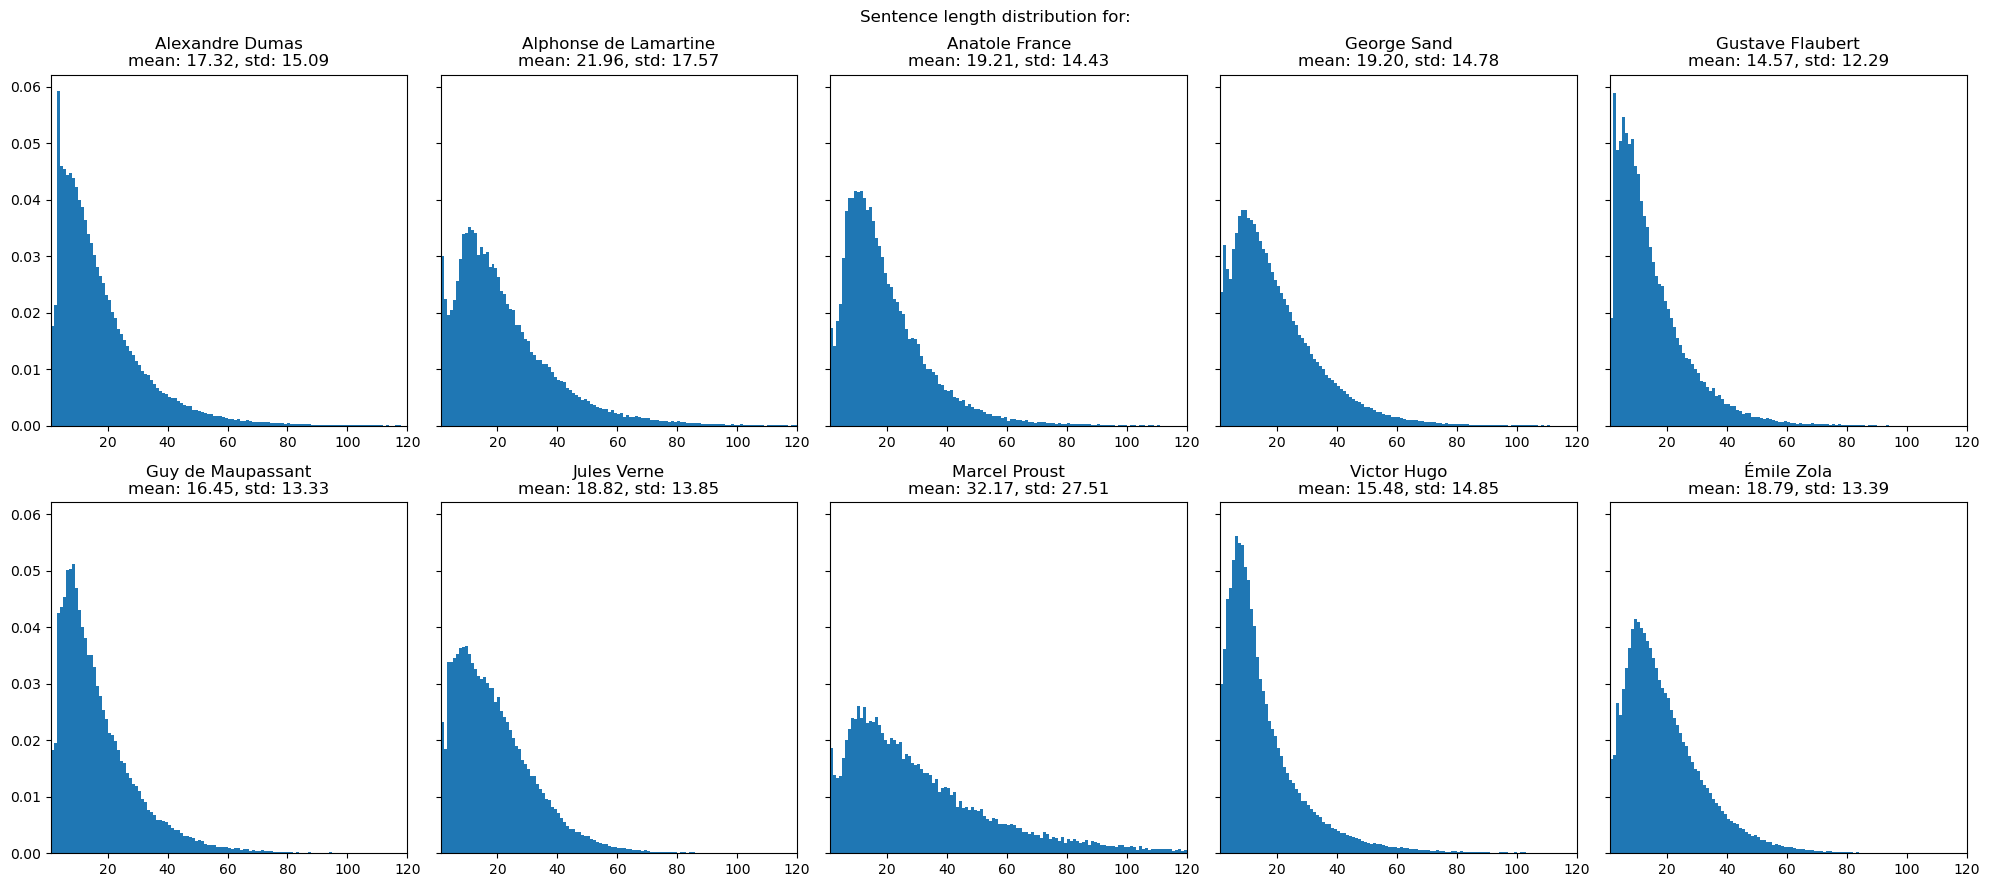

In [22]:
non_punct_tokens={}
s={}
for i in text_anal_df.index:
    text_anal_df.loc[i, "tokens"]=len(docs[i])
    non_punct_tokens[i]=[len(token) for token in docs[i] if token.pos_!="PUNCT"] #we collect the token length information for book i in non_punct_tokens[i]
    text_anal_df.loc[i, "non_punct_len"]=sum(non_punct_tokens[i])
    text_anal_df.loc[i, "non_punct_tokens"]=len(non_punct_tokens[i])
    assert docs[i].has_annotation("SENT_START")
    s[i]=[len(sent) for sent in docs[i].sents] #we collect the sentence length information for book i in s[i]
    text_anal_df.loc[i, "sentence_len"]=sum(s[i])
    text_anal_df.loc[i, "sentences"]=len(s[i])


distribution_chart(s, None, 1, 120, range(200), "Sentence length")

We have considerably diminished the outliers. This cleaning process could be continued but we stop here. 

Let's have a look at the word length distribution:  

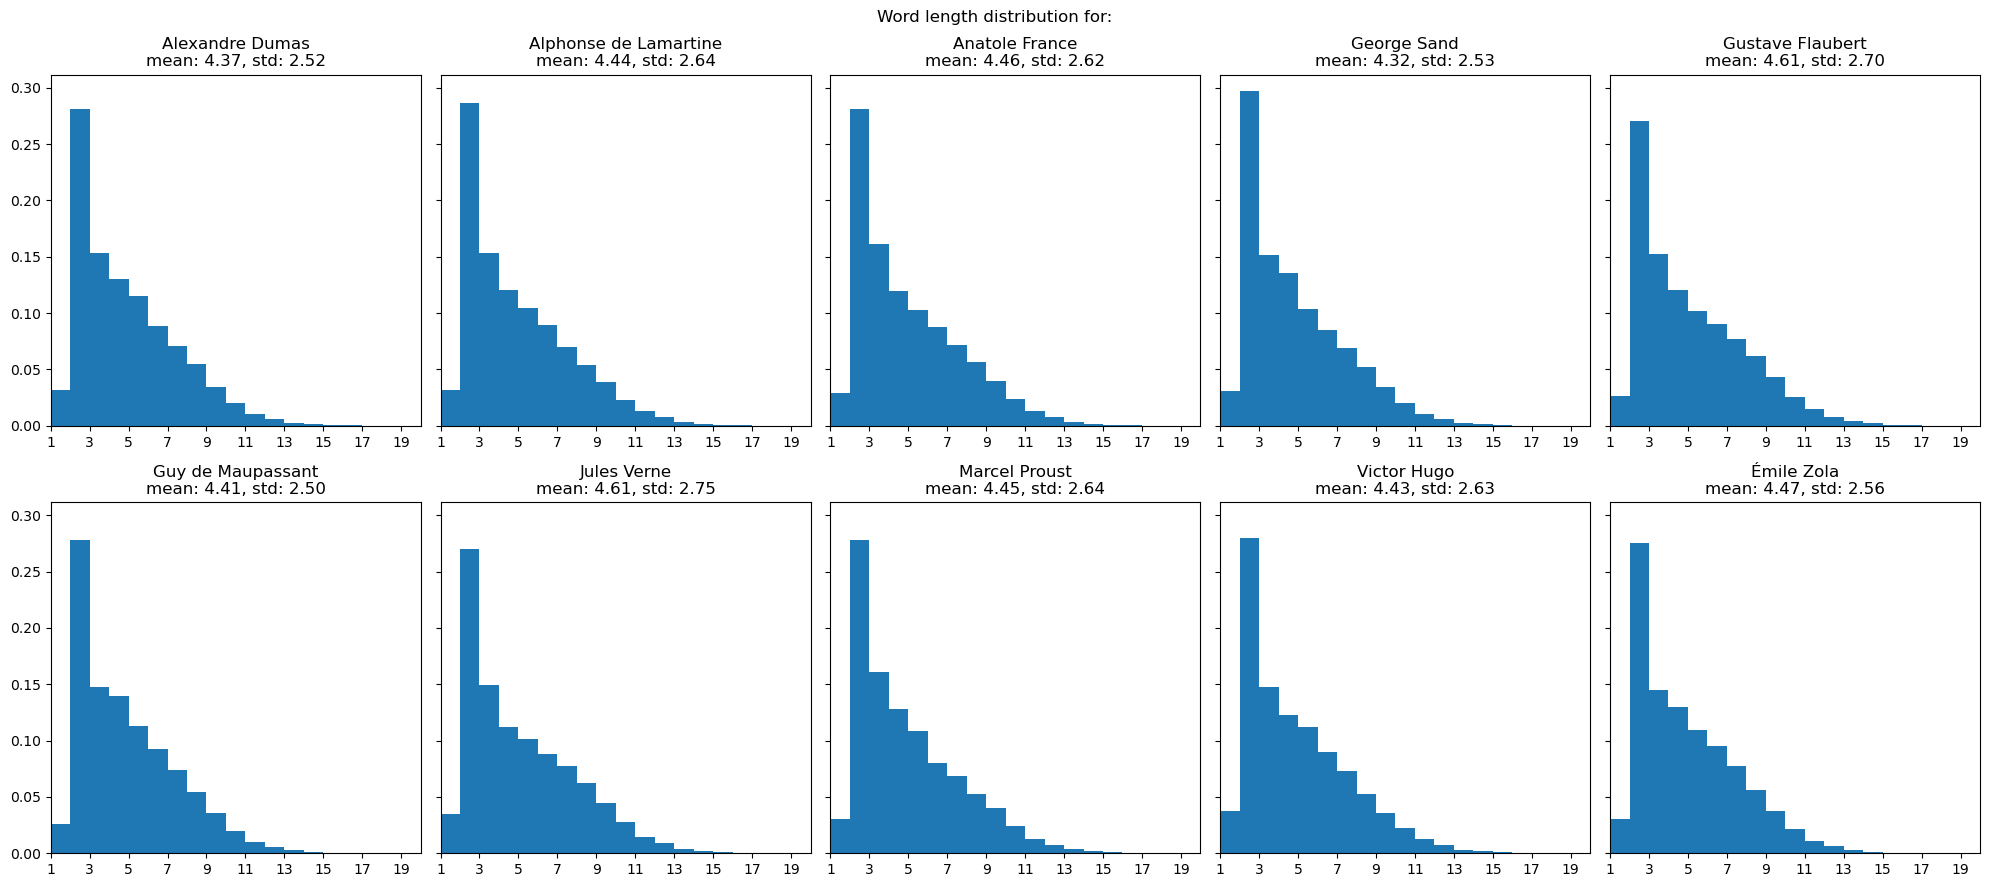

In [23]:
%matplotlib inline
distribution_chart(non_punct_tokens, range(1, 20, 2), 1, 20, range(20), "Word length")

Word length distributions are remarkably similar across authors.

## POS statistics

Let's look at the POS distributions in the books:

In [24]:

for i in text_anal_df.index:
    counts=Counter([token.pos_ for token in docs[i]])
    for p in counts:
        text_anal_df.loc[i, p]=counts[p]
pos_cols=[p for p in counts]
with pd.option_context('display.max_columns', None):
    display(text_anal_df)

author  \
number                          
34204             George Sand   
24850              Émile Zola   
41054   Alphonse de Lamartine   
63794          Anatole France   
12367             George Sand   
...                       ...   
13668             George Sand   
37604   Alphonse de Lamartine   
17693         Alexandre Dumas   
7772          Alexandre Dumas   
17660             Jules Verne   

                                                  title      !s      .s    *s  \
number                                                                          
34204                                 La petite Fadette    63.0  1245.0   0.0   
24850                                           Lourdes  1017.0  6538.0   0.0   
41054         Cours familier de Littérature - Volume 07   718.0  2347.0  15.0   
63794   La comédie de celui qui épousa une femme muette    69.0   544.0   0.0   
12367              Le péché de Monsieur Antoine, Tome 1   486.0  2872.0   0.0   
...                                                 ...     ...     ...   ...   
13668                           Le château des Désertes   285.0  1570.0   6.0   
37604         Cours familier de Littérature - Volume 10   176.0  2637.0  20.0   
17693                            La San-Felice, Tome 01   223.0  1307.0   0.0   
7772                         Les Quarante-Cinq — Tome 3   717.0  2639.0   0.0   
17660                                 L'archipel en feu   545.0  2202.0   0.0   

            's   °s   paras    ]s       ,s     ?s    )s   "s    [s    (s  \
number                                                                     
34204   3006.0  0.0   514.0   2.0   3597.0   77.0   3.0  0.0   2.0   3.0   
24850   8050.0  0.0  1980.0   0.0  16715.0  386.0   0.0  0.0   0.0   0.0   
41054   3591.0  0.0  1172.0   0.0   4717.0  202.0  64.0  0.0   0.0  64.0   
63794    267.0  0.0   347.0   0.0    338.0   64.0   9.0  0.0   0.0   9.0   
12367   4569.0  0.0  1202.0   2.0   5735.0  376.0   8.0  0.0   2.0   8.0   
...        ...  ...     ...   ...      ...    ...   ...  ...   ...   ...   
13668   2531.0  1.0   419.0   7.0   2851.0  170.0  24.0  0.0   7.0  24.0   
37604   3317.0  0.0   707.0   0.0   4441.0   99.0  14.0  0.0   0.0  14.0   
17693   2696.0  3.0  1104.0  10.0   4722.0  119.0   1.0  0.0  10.0   1.0   
7772    3469.0  0.0  2779.0  15.0   5573.0  548.0   0.0  0.0  15.0   0.0   
17660   2757.0  0.0   974.0   2.0   4109.0  170.0   0.0  0.0   2.0   0.0   

          spaces      -s     :s   =s     ;s   ...s     chars    tokens  \
number                                                                   
34204    40019.0   951.0   98.0  0.0  348.0    7.0  223934.0   49512.0   
24850   118651.0  2900.0  341.0  0.0  613.0  538.0  739614.0  155008.0   
41054    57540.0   991.0  180.0  0.0  882.0   67.0  345130.0   72478.0   
63794     4109.0   113.0   25.0  0.0   30.0   41.0   26837.0    5859.0   
12367    64480.0  2026.0  186.0  0.0  586.0  126.0  383911.0   81642.0   
...          ...     ...    ...  ...    ...    ...       ...       ...   
13668    33987.0  1001.0  122.0  0.0  343.0   50.0  199481.0   42928.0   
37604    51300.0   530.0  247.0  0.0  657.0   22.0  303113.0   61945.0   
17693    43133.0  1529.0  192.0  0.0  614.0   27.0  263071.0   55180.0   
7772     51271.0  4338.0  207.0  0.0  672.0   30.0  311043.0   68585.0   
17660    39686.0  1203.0   61.0  0.0   57.0  174.0  246098.0   50883.0   

        non_punct_len  non_punct_tokens  sentence_len  sentences     ADV  \
number                                                                     
34204        177622.0           43869.0       49512.0     1765.0  4181.0   
24850        591731.0          129610.0      155008.0     7367.0  9001.0   
41054        276834.0           62882.0       72478.0     3987.0  3583.0   
63794         21275.0            4829.0        5859.0      610.0   387.0   
12367        306809.0           70887.0       81642.0     3769.0  6031.0   
...               ...               ...           ...  

Now we can analyse at author level, i.e. how often an author uses an adjective, noun etc (pos tags/tokens), how long are the paragraphs and how often each punctuation mark occurs (punctuation mark number/sentence).

In [25]:
main_cols=text_anal_df.columns.drop(['author', 'title'])
punct_cols=['spaces', '?s', '°s', '(s', 'paras', '.s', '=s',
       '!s', ';s', ')s', ',s', ':s', "'s", '-s', '*s', ']s', '[s', '"s',
       '...s']


stat_df=text_anal_df.groupby('author').agg({col:'sum' for col in main_cols})

for col in punct_cols+['sentence_len']:
    stat_df['AVG_'+col[:-1]]=stat_df[col]/stat_df['sentences']
    
for col in pos_cols:
    stat_df['AVG_'+col]=stat_df[col]/stat_df['tokens']
    
stat_df['AVG_para_len']=stat_df['non_punct_tokens']/stat_df['paras']
stat_df['AVG_word_len']=stat_df['non_punct_len']/stat_df['non_punct_tokens']

cols_to_drop=list(main_cols)
stat_df=stat_df.drop(cols_to_drop, axis=1)
avg_pos_tags=["AVG_"+p for p in pos_cols]


print("""Average punctuation marks, sentence length (punctuation mark, sentence legth/sentence), average POS tags (POS tag/token
average POS tags (POS tag/token), average word length, average paragraph length in tokens:""") 
with pd.option_context('display.max_columns', None):
    display(stat_df)

Average punctuation marks, sentence length (punctuation mark, sentence legth/sentence), average POS tags (POS tag/token
average POS tags (POS tag/token), average word length, average paragraph length in tokens:


AVG_space     AVG_?     AVG_°     AVG_(  AVG_para  \
author                                                                     
Alexandre Dumas        13.120055  0.109797  0.000408  0.001082  0.537714   
Alphonse de Lamartine  17.666518  0.050937  0.000047  0.009444  0.286757   
Anatole France         15.288505  0.044681  0.000626  0.005863  0.270545   
George Sand            15.202908  0.080361  0.000243  0.008614  0.258886   
Gustave Flaubert       10.924613  0.056884  0.000048  0.014740  0.412009   
Guy de Maupassant      12.425972  0.073377  0.000000  0.002897  0.441780   
Jules Verne            14.541016  0.074514  0.004014  0.003892  0.396709   
Marcel Proust          26.096281  0.047236  0.000226  0.042232  0.134121   
Victor Hugo            11.916132  0.066494  0.000268  0.006037  0.337157   
Émile Zola             14.446577  0.055320  0.000073  0.000249  0.262676   

                          AVG_.     AVG_=     AVG_!     AVG_;     AVG_)  \
author                                                                    
Alexandre Dumas        0.682192  0.000000  0.126155  0.151008  0.001082   
Alphonse de Lamartine  0.761623  0.001713  0.090483  0.218341  0.009444   
Anatole France         0.905840  0.000000  0.051541  0.068691  0.005863   
George Sand            0.722253  0.000004  0.112940  0.146703  0.008614   
Gustave Flaubert       0.732733  0.003040  0.220515  0.143488  0.014740   
Guy de Maupassant      0.881406  0.000000  0.083427  0.087936  0.002897   
Jules Verne            0.907039  0.000306  0.143859  0.053575  0.003892   
Marcel Proust          0.876308  0.000065  0.055921  0.085335  0.042199   
Victor Hugo            0.700137  0.000000  0.115364  0.118378  0.006027   
Émile Zola             0.914132  0.002369  0.119914  0.094322  0.000249   

                          AVG_,     AVG_:     AVG_'     AVG_-     AVG_*  \
author                                                                    
Alexandre Dumas        1.340355  0.055189  0.702726  0.703657  0.001332   
Alphonse de Lamartine  1.503420  0.071326  1.174489  0.271060  0.004305   
Anatole France         1.269548  0.072121  1.057868  0.331819  0.007903   
George Sand            1.262208  0.042750  1.059531  0.432512  0.005272   
Gustave Flaubert       1.157673  0.047886  0.729742  0.316455  0.000289   
Guy de Maupassant      1.328076  0.124461  0.793434  0.404658  0.000905   
Jules Verne            1.456946  0.022033  0.765095  0.545648  0.000346   
Marcel Proust          2.176288  0.080266  1.728949  0.525862  0.001550   
Victor Hugo            1.125420  0.051023  0.662699  0.428335  0.001435   
Émile Zola             1.815844  0.045609  0.964059  0.384024  0.001476   

                          AVG_]     AVG_[     AVG_"   AVG_...  \
author                                                          
Alexandre Dumas        0.000883  0.000879  0.000037  0.022193   
Alphonse de Lamartine  0.002440  0.002440  0.000012  0.014359   
Anatole France         0.005006  0.005006  0.022271  0.016362   
George Sand            0.005305  0.005313  0.000138  0.022726   
Gustave Flaubert       0.001375  0.001375  0.000000  0.034545   
Guy de Maupassant      0.001141  0.001141  0.000000  0.056209   
Jules Verne            0.004727  0.004720  0.000224  0.065943   
Marcel Proust          0.005263  0.005263  0.000000  0.012657   
Victor Hugo            0.006812  0.007089  0.000268  0.006611   
Émile Zola             0.000364  0.000352  0.000887  0.047522   

                       AVG_sentence_le   AVG_ADV  AVG_PUNCT  AVG_PRON  \
author                                                                  
Alexandre Dumas              17.323408  0.057419   0.158271  0.115670   
Alphonse de Lamartine        21.963868  0.052724   0.123974  0.098416   
Anatole France               19.208899  0.054975   0.129078  0.106958   
George Sand                  19.202669  0.070138   0.128523  0.134074   
Gustave Flaubert             14.571491  0.050227   0.165902  0.102668   
Guy de Maupassan

Now we can analyse at author level, i.e. how often an author uses an adjective, noun etc (pos tags/tokens), how long are the paragraphs and how often each punctuation mark occurs (punctuation mark number/sentence). 

In [26]:
for c in stat_df.columns:
    print("For {}, the minimum is {:.4f} in {}'s books, the maximum is {:.4f}, in {}'s writings.".
          format(c, stat_df[c].min(), stat_df[c].idxmin(), stat_df[c].max(), stat_df[c].idxmax()))
print("\n\nFor POS tags, the numbers indicate the frequency per token, for punctuation, frequency per sentence.")

For AVG_space, the minimum is 10.9246 in Gustave Flaubert's books, the maximum is 26.0963, in Marcel Proust's writings.
For AVG_?, the minimum is 0.0447 in Anatole France's books, the maximum is 0.1098, in Alexandre Dumas's writings.
For AVG_°, the minimum is 0.0000 in Guy de Maupassant's books, the maximum is 0.0040, in Jules Verne's writings.
For AVG_(, the minimum is 0.0002 in Émile Zola's books, the maximum is 0.0422, in Marcel Proust's writings.
For AVG_para, the minimum is 0.1341 in Marcel Proust's books, the maximum is 0.5377, in Alexandre Dumas's writings.
For AVG_., the minimum is 0.6822 in Alexandre Dumas's books, the maximum is 0.9141, in Émile Zola's writings.
For AVG_=, the minimum is 0.0000 in Alexandre Dumas's books, the maximum is 0.0030, in Gustave Flaubert's writings.
For AVG_!, the minimum is 0.0515 in Anatole France's books, the maximum is 0.2205, in Gustave Flaubert's writings.
For AVG_;, the minimum is 0.0536 in Jules Verne's books, the maximum is 0.2183, in Alpho

Let's represent the use of different pos tags by the authors in pie charts.

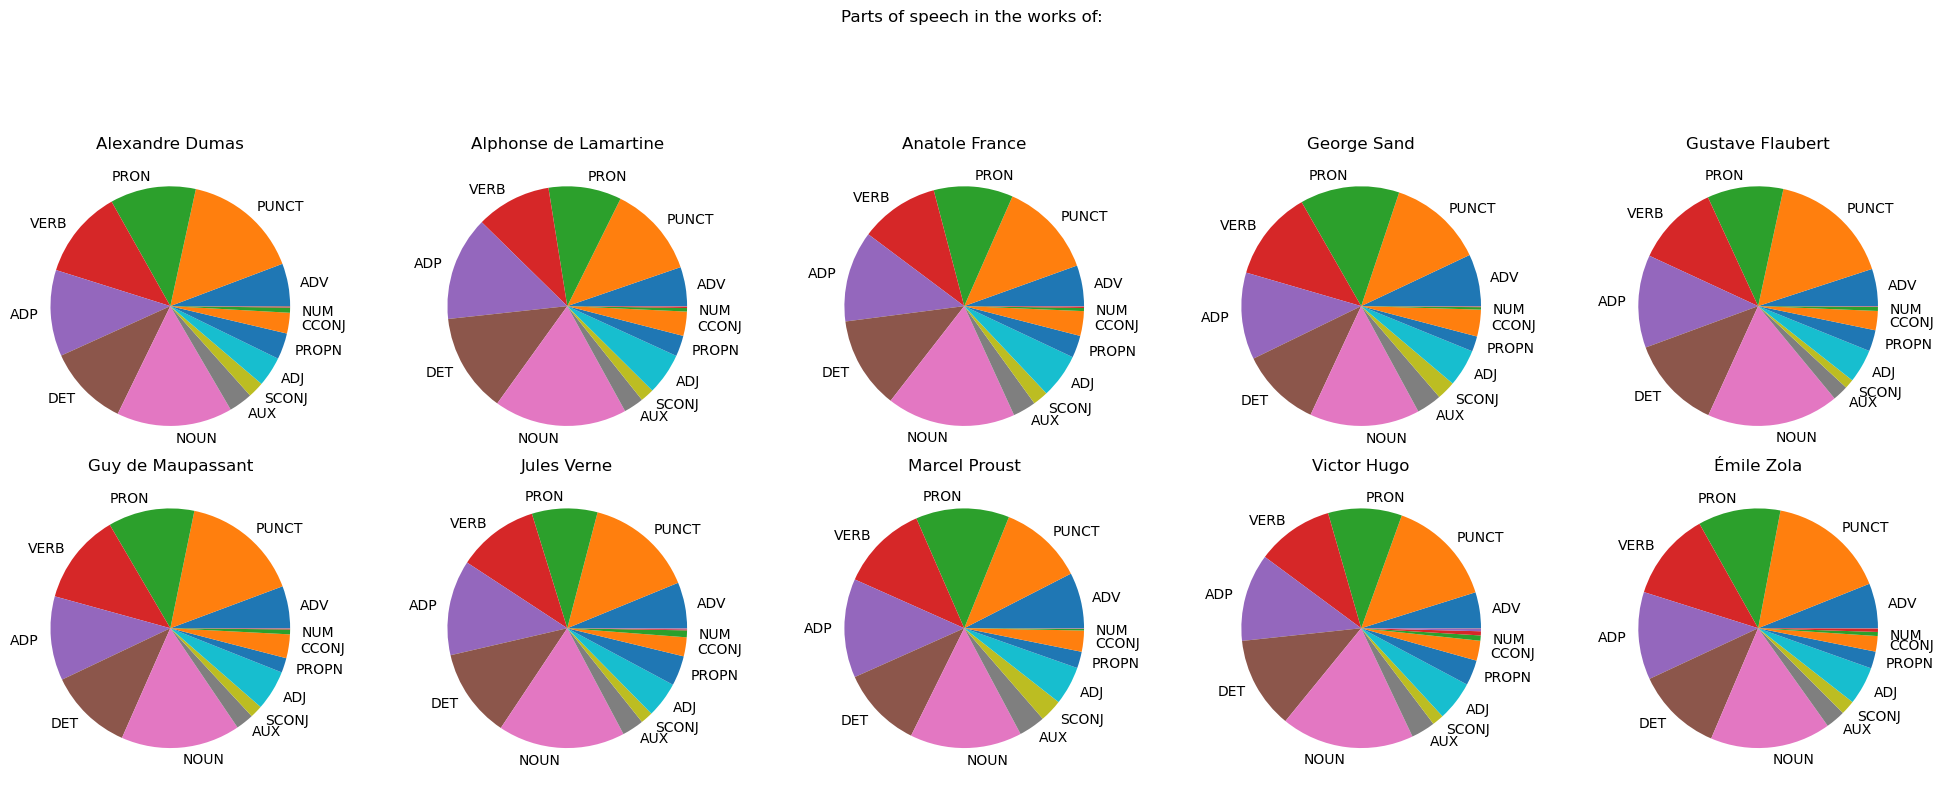

In [27]:
%matplotlib inline
fig, axs = plt.subplots(2, 5,  figsize=(20, 8))
graph_number=0

for j, (i, row) in enumerate(stat_df.iterrows()):
        ax=axs.flat[j]
        sizes=row[avg_pos_tags] 
        labels=pos_cols[:-3]+['','',''] #SYM, X and INTJ are negligeable
        ax.pie(sizes, labels=labels)
        ax.set_title("{}".format(i))
fig.suptitle('Parts of speech in the works of:\n\n\n\n\n\n');
plt.tight_layout()
plt.show()

Some of these differences, like Proust's long sentences, sparing use of exclamation and question marks could be predicted from domain knowledge, but there is a lot of interesting data here.

However, an analysis of pos tags and punctuation marks in itself could never be enough to recognize the style of an author.

## Author-specific words

### tf-idf

First let's have a look at the high tf-idf words for each author. While spacy has a stop word list in French, it is a short list and using it, we get very generic results. We add the 3000 most frequent French words to the stop word list. 

In [28]:
text_list={}
text_list['raw']=[" ".join([str(token).lower() for token in docs[i]]) for i in no_dupl.index]
text_list['raw_no_ent']=[" ".join([str(token).lower() for token in docs[i] if token.ent_type_ == '']) for i in no_dupl.index]
text_list['lemma_no_ent']=[" ".join([str(token.lemma_).lower() for token in docs[i] if token.ent_type_ == ""]) for i in no_dupl.index]

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordfreq import top_n_list
fr_stop2=top_n_list('fr', 3000)
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop1
fr_stop=list(set(fr_stop1)|set(fr_stop2))+['neuf', 'qu', 'quelqu', 'aujourd', 'lorsqu', 'puisqu']

def author_sp_tfidf(proc_type, n):
    if proc_type=='raw':
        print('Considering raw text, high tf-idf words for')
    if proc_type=='raw_no_ent':
        print('\n\n\nConsidering raw text without named entities, high tf-idf words for')
    if proc_type=='lemma_no_ent':
        print('\n\n\nConsidering lemmatised text without named entities, high tf-idf words for')

    tfidf = TfidfVectorizer(stop_words=fr_stop)
    tfidf_mtx = tfidf.fit_transform(text_list[proc_type])
    vocabulary = {v: k for k, v in tfidf.vocabulary_.items()}
    spec_words={}
    tfidf_mtx_a={}
    for author, group in text_anal_df.groupby('author'):
        tfidf_mtx_a[author]=tfidf_mtx[[no_dupl.index.get_loc(i) for i in group.index]] #for each author, we take the rows of the matrix representing the books of the author
        spec_words[author]=[vocabulary[j] for j in np.argsort(-tfidf_mtx_a[author].toarray().sum(axis=0))[:n]] #for each author, we add the rows for the author and take the n highest sums and then find the relevant words
        print('\033[5;8;4m{}\033[0;0;0m: {}\n'.format(author, ', '.join(spec_words[author])))
    return tfidf_mtx
tfidf_mtx_d={}
for pr in ['raw', 'raw_no_ent', 'lemma_no_ent']:
    tfidf_mtx_d[pr]=author_sp_tfidf(pr, 50)

Considering raw text, high tf-idf words for
Alexandre Dumas: chicot, artagnan, sire, salvato, luisa, cardinal, naples, bussy, répondit, majesté, michele, nelson, demanda, eût, villefort, monseigneur, aramis, cristo, athos, écria, ferdinand, porthos, mole, championnet, marguerite, fouquet, coconnas, nicolino, danglars, gorenflot, remy, continua, emma, dantès, monsoreau, pamphile, jadin, ruffo, éva, caracciolo, charny, guiche, hoffmann, cirillo, mérey, chevalier, beausire, fût, morrel, acté

Alphonse de Lamartine: poëte, poëme, goethe, poésie, chateaubriand, gloire, poëtes, platon, florence, cicéron, récamier, peuples, vertu, patrie, cardinal, voltaire, thiers, socrate, lamartine, staël, faust, béranger, pétrarque, aristote, rousseau, larmes, bonaparte, homère, écrivain, tantôt, dante, trône, imagination, monarchie, eût, napoléon, littéraire, fortune, virginie, kobus, épique, fingal, boris, oeuvres, humboldt, machiavel, médicis, hyeronimo, athènes, tasse

Anatole France: bergeret, cather

The first list (raw text) shows a lot of proper nouns (mostly names) used by the authors which we will futher consider in the next section. 

The second list (raw text without named entities) reveals better the style of the author, including the themes preferred and some grammatical choices (eusse, the imperfect subjunctive of avoir in the case of Proust). It also shows the age of our texts: a lot of very common passé simple forms are not filtered with our contemporary stop word list.

The third list  (lemmatised text without named entities) reveals the best style of the author: it shows the themes preferred (e.g. prisonnier, épée for Dumas, latitude, marin for Verne, souffrance, baron for Proust) or word choices (poindre for Sand). Hopefully, these are the kinds of words that our classifier will recognize to classify the text! The list also shows the limits of the spacy lemmatiser: in most cases, sou is the mislemmatized form of sous, and luire is the mislemmatized form of lui. Lui and sous are in our stop word list, but not these mislemmatized forms which are not filtered.

### Log likelihood

We now try to extract the highly relevant words with the log-likelihood method. First we count the words:

In [30]:
counts_per_author={}
all_counts={}

for pr in ['raw', 'lemma_no_ent', 'raw_no_ent']:
    counts_per_author[pr]={}
    all_counts[pr]=Counter()

for author, group in text_anal_df.groupby('author'):
    counts_per_author['raw'][author]=Counter([str(token).lower()  for i in group.index for token in docs[i]])
    counts_per_author['raw_no_ent'][author]=Counter([str(token).lower() for i in group.index for token in docs[i] if token.ent_type_ == ''])
    counts_per_author['lemma_no_ent'][author]=Counter([str(token.lemma_).lower() for i in group.index for token in docs[i] if token.ent_type_ == ""])
    for pr in ['raw', 'lemma_no_ent', 'raw_no_ent']:
        all_counts[pr].update(counts_per_author[pr][author])

### Excursus - word frequency-word rank graph

The frequency of a word should be inversely proportional to its rank. Let's check it for George Sand. We only count words, not numbers or punctuation.

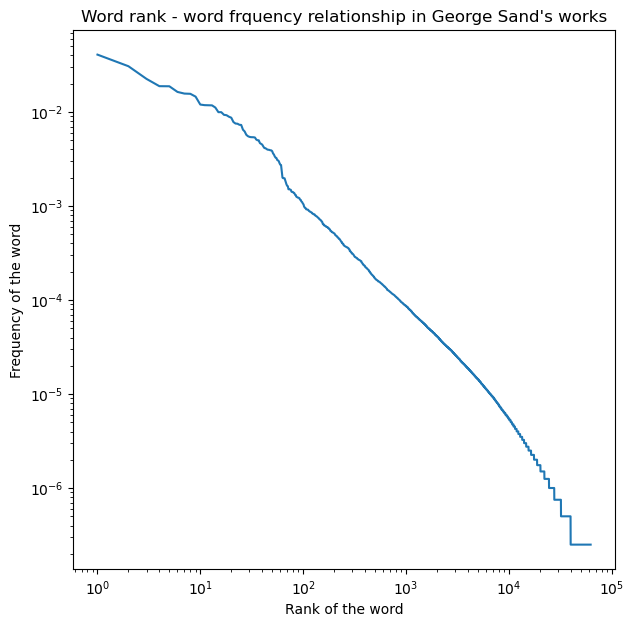

In [31]:
counts_sand=[(token, c) for (token, c) in counts_per_author['raw']['George Sand'].most_common() if any(char.isalpha() for char in token)]
frequency_sand_raw=[c for (token, c) in counts_sand]
number_of_tokens=sum(frequency_sand_raw)
frequency_sand=[c/number_of_tokens for c in frequency_sand_raw]
rank_sand=range(1, len(frequency_sand)+1)
%matplotlib inline
plt.figure(figsize=(7, 7))

plt.loglog(rank_sand, frequency_sand)

plt.xlabel('Rank of the word')
plt.ylabel('Frequency of the word')
plt.title("Word rank - word frquency relationship in George Sand's works")

plt.show()

While loglog charts are tricky, at least at first sight our Sand corpus does not seem to contradict Zipf's law.

### Back to log-likelihood

We define a stop word list, including also the most frequent words in our corpus, a log likelihood ratio function, and a function to find the words which have the highest llr and which occur more frequently in an author's corpus than in the entire corpus.

In [32]:
stop_words={}
for pr in ['raw', 'lemma_no_ent', 'raw_no_ent']:
    stop_words[pr]=list(set([word for word, count in all_counts[pr].most_common(3000)])|set(fr_stop)) #we use the combined spacy/wordfreq list as above, plus the most frequent 3000 words in our corpus 

def llr(k1, N1, k2, N2):
    k1=k1+1
    k2=k2+1
    E1 = (k1+k2)*(N1/(N1+N2))
    E2 = (k1+k2)*(N2/(N1+N2))
    LLR = 2*(k1*np.log(k1/E1)+k2*np.log(k2/E2))
    return LLR

In [33]:
def author_sp_llr(pr, n):
    if pr=='raw':
        print('Considering raw text, high llr words for')
    if pr=='raw_no_ent':
        print('\n\n\nConsidering raw text without named entities, high llr words for')
    if pr=='lemma_no_ent':
        print('\n\n\nConsidering lemmatised text without named entities, high llr words for')
    all_word_count=sum(all_counts[pr].values())
    for author, _ in text_anal_df.groupby('author'):
        author_word_count=sum(counts_per_author[pr][author].values())
        llr_dict={}
        for word, freq in counts_per_author[pr][author].items():
            if (word not in stop_words[pr]) & (counts_per_author[pr][author][word]/author_word_count>
                all_counts[pr][word]/all_word_count): #llr is a symmetric measure, it is high both for improbably frequent and improbably infrequent words, but we only need the former
            
                llr_dict[word]=llr(counts_per_author[pr][author][word], #word occurrences in the author's corpus
                                   author_word_count, #word count of the author's corpus
                                   all_counts[pr][word]-counts_per_author[pr][author][word], #word occurrences outside the author's corpus
                                   all_word_count-author_word_count #word count of the whole corpus exluding the author's
                                  ) 
        most_common=[word for (word, freq) in sorted(llr_dict.items(), key=lambda x: -x[1])][:n]
        print('\033[5;8;4m{}\033[0;0;0m: {}'.format(author, ', '.join(most_common)))


In [34]:
for pr in ['raw', 'raw_no_ent', 'lemma_no_ent']:
    author_sp_llr(pr, 50)

Considering raw text, high llr words for
Alexandre Dumas: morrel, monsoreau, remy, gorenflot, buckingham, buvat, cornélius, nelson, grimaud, bathilde, michele, monck, wardes, mérey, charny, navarre, éva, harmental, saint-luc, hoffmann, malicorne, baisemeaux, beausire, bonacieux, mousquetaire, dixmer, mousquetaires, lorin, milady, montalais, noirtier, manicamp, championnet, morcerf, oliva, saint-aignan, bragelonne, pamphile, sara, mordaunt, nicolino, mousqueton, winter, richelieu, aurilly, amiral, jadin, carrosse, ruffo, cirillo
Alphonse de Lamartine: platon, chateaubriand, cicéron, aristote, récamier, thiers, kobus, pétrarque, lamartine, boris, béranger, rousseau, socrate, staël, dante, machiavel, épique, faust, sûzel, homère, fingal, monarchie, humboldt, hyeronimo, ferrare, talleyrand, médicis, arioste, historien, athènes, grandet, poëmes, épopée, virginie, pathétique, popularité, saint-pierre, bernardin, schiller, alfieri, lucques, orateur, guérassime, guerriers, albany, viéra, boile

In this case again, the third list shows the best the preferred themes and word choices of the authors.

These lists were created by excluding the most common words and thus show differences that are easily interpretable by humans. However, a classifier, even if it only looks at word frequencies, can make use of subtle differences in the frequencies of stopwords that are much harder to notice by a human reader.

## Clustering the books

While our final objective will be to recognize the author from a short snippet of text, let's see if the whole text of each book is enough to reliably cluster the books according to authors. We use the tf-idf vectors and also the vectors produced by spacy (we call it w2v in the variable name but they are fastText vectors).

In [35]:
w2v_mtx=np.zeros((len(text_anal_df.index), 300))
for i, book_n in enumerate(text_anal_df.index):
    w2v_mtx[i]=docs[book_n].vector

In [36]:
import random
random.seed(0)

def cluster_accuracy(mtx):
    author_indices={}
    initial_centroid=[]
    author_list=[]
    for author, group in text_anal_df.groupby('author'):
        author_indices[author]=[no_dupl.index.get_loc(i) for i in group.index]
        initial_centroid.append(random.choice(author_indices[author]))
        author_list.append(author)
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=10, init=mtx[initial_centroid], n_init=1)
    kmeans.fit(mtx)
    labels = [author_list[label] for label in kmeans.labels_]

    true_labels = list(text_anal_df['author'])
    comp = [labels[i] == true_labels[i] for i in range(len(labels))]
    accuracy = (sum(comp)-10)/(len(labels)-10) # the centroids, and thereby the author of ten books are already given, we calculate the accuracy on the rest of the books
    return accuracy
print("Using tf-idf, the clustering accuracy is {:.2f}".format(cluster_accuracy(tfidf_mtx_d['raw'].toarray())))
print("Using spacy's vector for the books, the clustering accuracy is {:.2f}".format(cluster_accuracy(w2v_mtx)))

Using tf-idf, the clustering accuracy is 0.31
Using spacy's vector for the books, the clustering accuracy is 0.38


What happens if we label a couple of books per author and try to propagate the labels?

In [37]:
authors=text_anal_df['author'].unique()
to_number=dict(zip(authors, range(len(authors))))
to_author=dict(zip(range(len(authors)), authors))

In [38]:

from sklearn.semi_supervised import LabelSpreading
random.seed(0)
def label_spreading_acc(mtx, n, intro_text=''):
    partial_labels = [-1]*len(text_anal_df)
    label_indices = []
    author_indices={}
    for author, group in text_anal_df.groupby('author'):
        author_indices[author] = [no_dupl.index.get_loc(i) for i in group.index]
        for i in random.sample(author_indices[author],n):
            partial_labels[i] = to_number[author]
            label_indices.append(i)
    partial_labels=np.asarray(partial_labels)
    unlabeled=list(set(range(len(text_anal_df)))-set(label_indices))
    label_prop_model = LabelSpreading()
    label_prop_model.fit(mtx, partial_labels)
    true_labels = [to_number[text_anal_df.iloc[i]['author']] for i in unlabeled]
    accuracy=label_prop_model.score(mtx[unlabeled], true_labels)
    print(intro_text+', with {} books labeled per author, the accuracy is {:.2f}'.format(n, accuracy))
for n in range(1, 5):
    for mtx, intro_text in zip([tfidf_mtx_d['raw'].toarray(), w2v_mtx], ["Using tf-idf", "Using spacy's vector for the books"]):
        label_spreading_acc(mtx, n, intro_text)
                               
    

Using tf-idf, with 1 books labeled per author, the accuracy is 0.33
Using spacy's vector for the books, with 1 books labeled per author, the accuracy is 0.54
Using tf-idf, with 2 books labeled per author, the accuracy is 0.39
Using spacy's vector for the books, with 2 books labeled per author, the accuracy is 0.47
Using tf-idf, with 3 books labeled per author, the accuracy is 0.48
Using spacy's vector for the books, with 3 books labeled per author, the accuracy is 0.69
Using tf-idf, with 4 books labeled per author, the accuracy is 0.45
Using spacy's vector for the books, with 4 books labeled per author, the accuracy is 0.70


Using tf-idf or the document vectors produced by spacy, it is not that easy to classify to the books by author.

Our final task will be harder and easier: harder, because we will classify not whole books, only short snippets and we will group the books together to prevent recognition by names, and easier, because our training set will be much larger than our test set, unlike in this semi-supervised setting. 

## Books belonging together

Some of the books in our dataset clearly belong together. As we saw, such is the case with Sand's correspondence, where the letters share their addressees. Or with Monsieur Bergeret à Paris and Opinions sociales by Anatole France which share a lot of sentences. We also saw in the last notebook that cosine similarity between the tf idf vector of books is high when books share relevant (high tf idf) words. Let's first try this approach.

### Cosine similarity matrix

Let's consider again the book pairs with high cosine similarity as in the last notebook when we were looking for duplicates, but using a lower threshold for similarity. We won't visualize the cosine similarity matrices as they are quite similar to the ones we have shown the last time.
We will use the raw version of the texts, including the named entities, as they help us in grouping the texts, as it will be clear in the next section.

In [39]:
tfidf = TfidfVectorizer(stop_words=fr_stop)
tfidf_mtx = tfidf.fit_transform(text_list['raw'])

from sklearn.metrics.pairwise import cosine_similarity
sim_mtx={}
tfidf_mtx_a={}
for author, group in no_dupl.groupby('author'):
    tfidf_mtx_a[author]=tfidf_mtx[[no_dupl.index.get_loc(i) for i in group.index]]
    sim_mtx[author]=cosine_similarity(tfidf_mtx_a[author], tfidf_mtx_a[author])
    
import numpy as np
for i, (author, group) in enumerate(no_dupl.groupby('author')):
    print('\033[5;8;4m{}\033[0;0;0m'.format(author))
    row, col=np.where(sim_mtx[author] > 0.6)
    if row.shape[0]>len(group):
        print('Possible groupings:\n')
    else:
        print('No groupings\n')
    for index in zip(row, col):
        if index[0]>index[1]:
            print('{} and\n{}\n\n'.format(group.iloc[index[0]]['title'], group.iloc[index[1]]['title']))


Alexandre Dumas
Possible groupings:

Les trois mousquetaires and
Le vicomte de Bragelonne, Tome IV.


Le Collier de la Reine, Tome I and
Le Collier de la Reine, Tome II


Les Quarante-Cinq — Tome 2 and
Les Quarante-Cinq — Tome 1


La dame de Monsoreau — ­Tome 1. and
La dame de Monsoreau — Tome 3.


La dame de Monsoreau — Tome 2. and
Les Quarante-Cinq — Tome 1


La dame de Monsoreau — Tome 2. and
Les Quarante-Cinq — Tome 2


La dame de Monsoreau — Tome 2. and
La dame de Monsoreau — Tome 3.


La dame de Monsoreau — Tome 2. and
La dame de Monsoreau — ­Tome 1.


Vingt ans après and
Le vicomte de Bragelonne, Tome IV.


Vingt ans après and
Les trois mousquetaires


Le comte de Monte-Cristo, Tome III and
Le comte de Monte-Cristo, Tome IV


Le vicomte de Bragelonne, Tome I. and
Les trois mousquetaires


Le vicomte de Bragelonne, Tome I. and
Vingt ans après


Le vicomte de Bragelonne, Tome III. and
Le vicomte de Bragelonne, Tome IV.


Le vicomte de Bragelonne, Tome III. and
Le vicomte de Bragel

### Named entity recognition

Quite often, books such as the volumes of Proust's magnum opus <i>In Search of Lost Time</i> and <i>The Three Musketeers</i> by Dumas and its sequels share their protagonists, so could be easily recogized by their names. As our goal is to build a style recognizer, not a protagonist recognizer, we will group these books sharing their protagonists, addressees or sentences together, and make sure excerpts from them are in the training set.

Let's see if we can find more books sharing their protagonists.

We can use the named entity recognition feature of spacy. Let's try it for Proust.

In [40]:
def nes(book_number, stop_nes=[]):
    return Counter([str(ent) for ent in docs[book_number].ents if str(ent) not in stop_nes])
    
for i, row in no_dupl[no_dupl["author"]=="Marcel Proust"].iterrows():
    print("\033[5;8;4m"+row["title"]+"\033[0;0;0m")
    print(i)
    print(nes(i).most_common(10))


Pastiches et mélanges
64145
[('Ruskin', 170), ('Amiens', 52), ("Bible d'Amiens", 30), ('Lemoine', 23), ('Roi', 20), ('Christ', 20), ("M. le duc d'Orléans", 18), ('Chartres', 18), ('Dieu', 17), ('Paris', 14)]
Le Côté de Guermantes - Première partie
8946
[('Saint-Loup', 125), ('Mme de Guermantes', 64), ('Robert', 40), ('Berma', 35), ('Françoise', 32), ('Paris', 29), ('Balbec', 24), ('Guermantes', 17), ('Doncières', 17), ('Borodino', 16)]
A l'ombre des jeunes filles en fleurs — Deuxième partie
2999
[('Mme de Villeparisis', 73), ('Balbec', 65), ('Gilberte', 60), ('Mme Swann', 35), ('Françoise', 31), ('Paris', 23), ('Swann', 13), ('Aimé', 12), ('Mme de Sévigné', 11), ('Combray', 10)]
A l'ombre des jeunes filles en fleurs - Première partie
2998
[('Swann', 159), ('Gilberte', 109), ('Mme Swann', 94), ('Bergotte', 83), ('M. de Norpois', 70), ('Odette', 63), ('Françoise', 28), ('Berma', 24), ('Cottard', 23), ('Mme Bontemps', 17)]
Les plaisirs et les jours
58698
[('Violante', 40), ('Bouvard', 27)

Most named entities are names but there are also some places. As we can see, volumes of <i>In search of lost time</i> share a lot of characters while <i>Pastiches et mélanges</i> and <i>Les plaisirs et les jours</i> don't. We will make sure that the volumes of In search of lost time stay together, either in the test set or in the training set (most probably in the training set as the two other books are too small for training), so as not to allow the classification algorithm to make use of the names.

What are the most common named entites across all books?


In [41]:
allnes=Counter()
for book_number in no_dupl.index:
    allnes+=nes(book_number)
allnes.most_common(10)

[('Dieu', 7474),
 ('Paris', 6287),
 ('Ah!', 3862),
 ('Artagnan', 3471),
 ('Oh!', 2766),
 ('la France', 2376),
 ('Rome', 2314),
 ('Chicot', 2132),
 ('Athos', 2113),
 ('Henri', 2093)]

Of these, 'Dieu', 'Paris', 'Ah!', 'Oh!', 'la France' and 'Monsieur' and 'Rome' do not really help which books belong together.

Now we detemerine the top10 named entites for each book that are not in this list. For each author and for each book pair written by them, we now show the number of top10 named entities that they share. We list the book pairs if they share at least 4 of their 10 most often mentioned named entities. These will be our candidates for books belonging together.

Alexandre Dumas
Les trois mousquetaires (13951) and Le vicomte de Bragelonne, Tome IV. (13950) share
{'Athos', "D'Artagnan", 'Aramis', 'Artagnan', 'Porthos'}
Le Collier de la Reine, Tome I (18199) and Le Collier de la Reine, Tome II (18200) share
{'Jeanne', 'Charny', 'Philippe', 'Andrée', 'Beausire', 'Oliva'}
La San-Felice, Tome 07, Emma Lyonna, tome 3 (58427) and La San-Felice, Tome 05 (18773) share
{'Michele', 'Français', 'Salvato', 'Luisa', 'Naples'}
La dame de Monsoreau — ­Tome 1. (9637) and La dame de Monsoreau — Tome 3. (9639) share
{'Bussy', 'Henri', "duc d'Anjou", 'Quélus', 'Gorenflot', 'Chicot', 'Diane', 'Saint-Luc'}
La dame de Monsoreau — Tome 2. (9638) and La dame de Monsoreau — Tome 3. (9639) share
{'Bussy', 'Henri', "duc d'Anjou", 'Quélus', 'Gorenflot', 'Monsoreau', 'Chicot'}
La dame de Monsoreau — Tome 2. (9638) and La dame de Monsoreau — ­Tome 1. (9637) share
{'Bussy', 'Henri', "duc d'Anjou", 'Quélus', 'Gorenflot', 'Chicot'}
Le Speronare (8863) and Le Capitaine Aréna — T

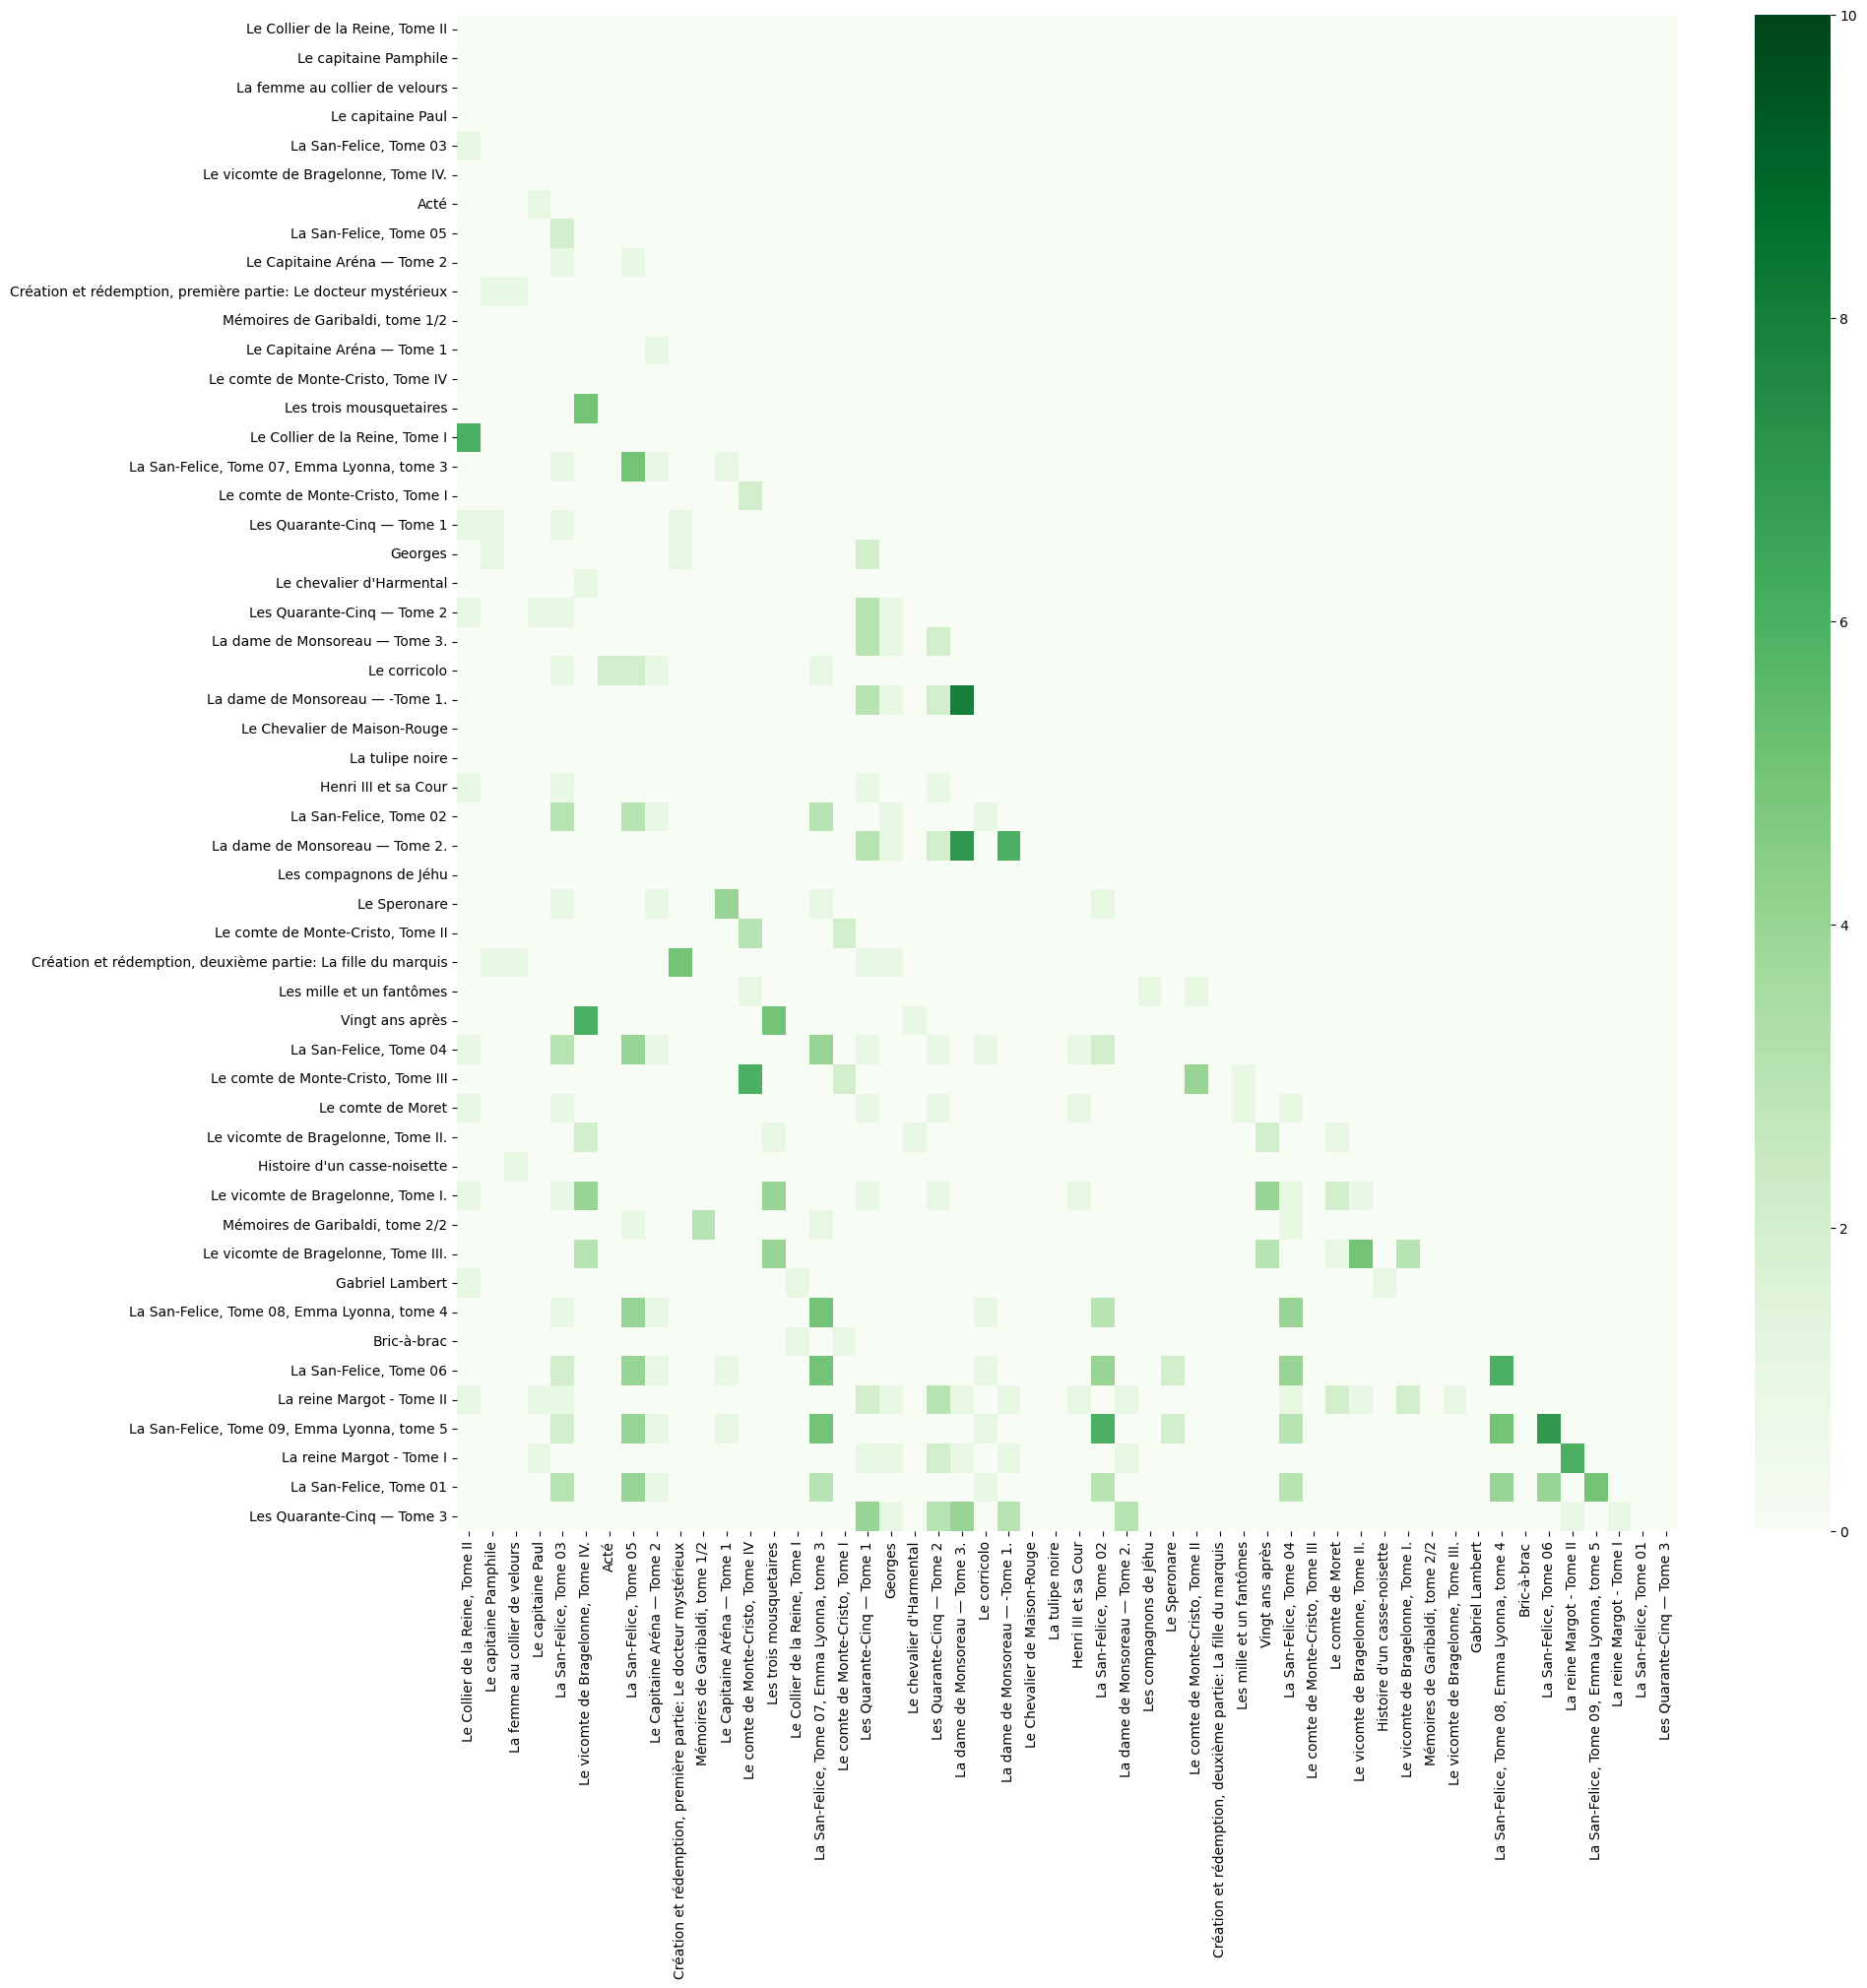

Alphonse de Lamartine
Cours familier de Littérature - Volume 09 (37076) and Cours familier de Littérature - Volume 21 (41079) share
{'Florence', "l'Italie", 'Italie', 'Naples'}


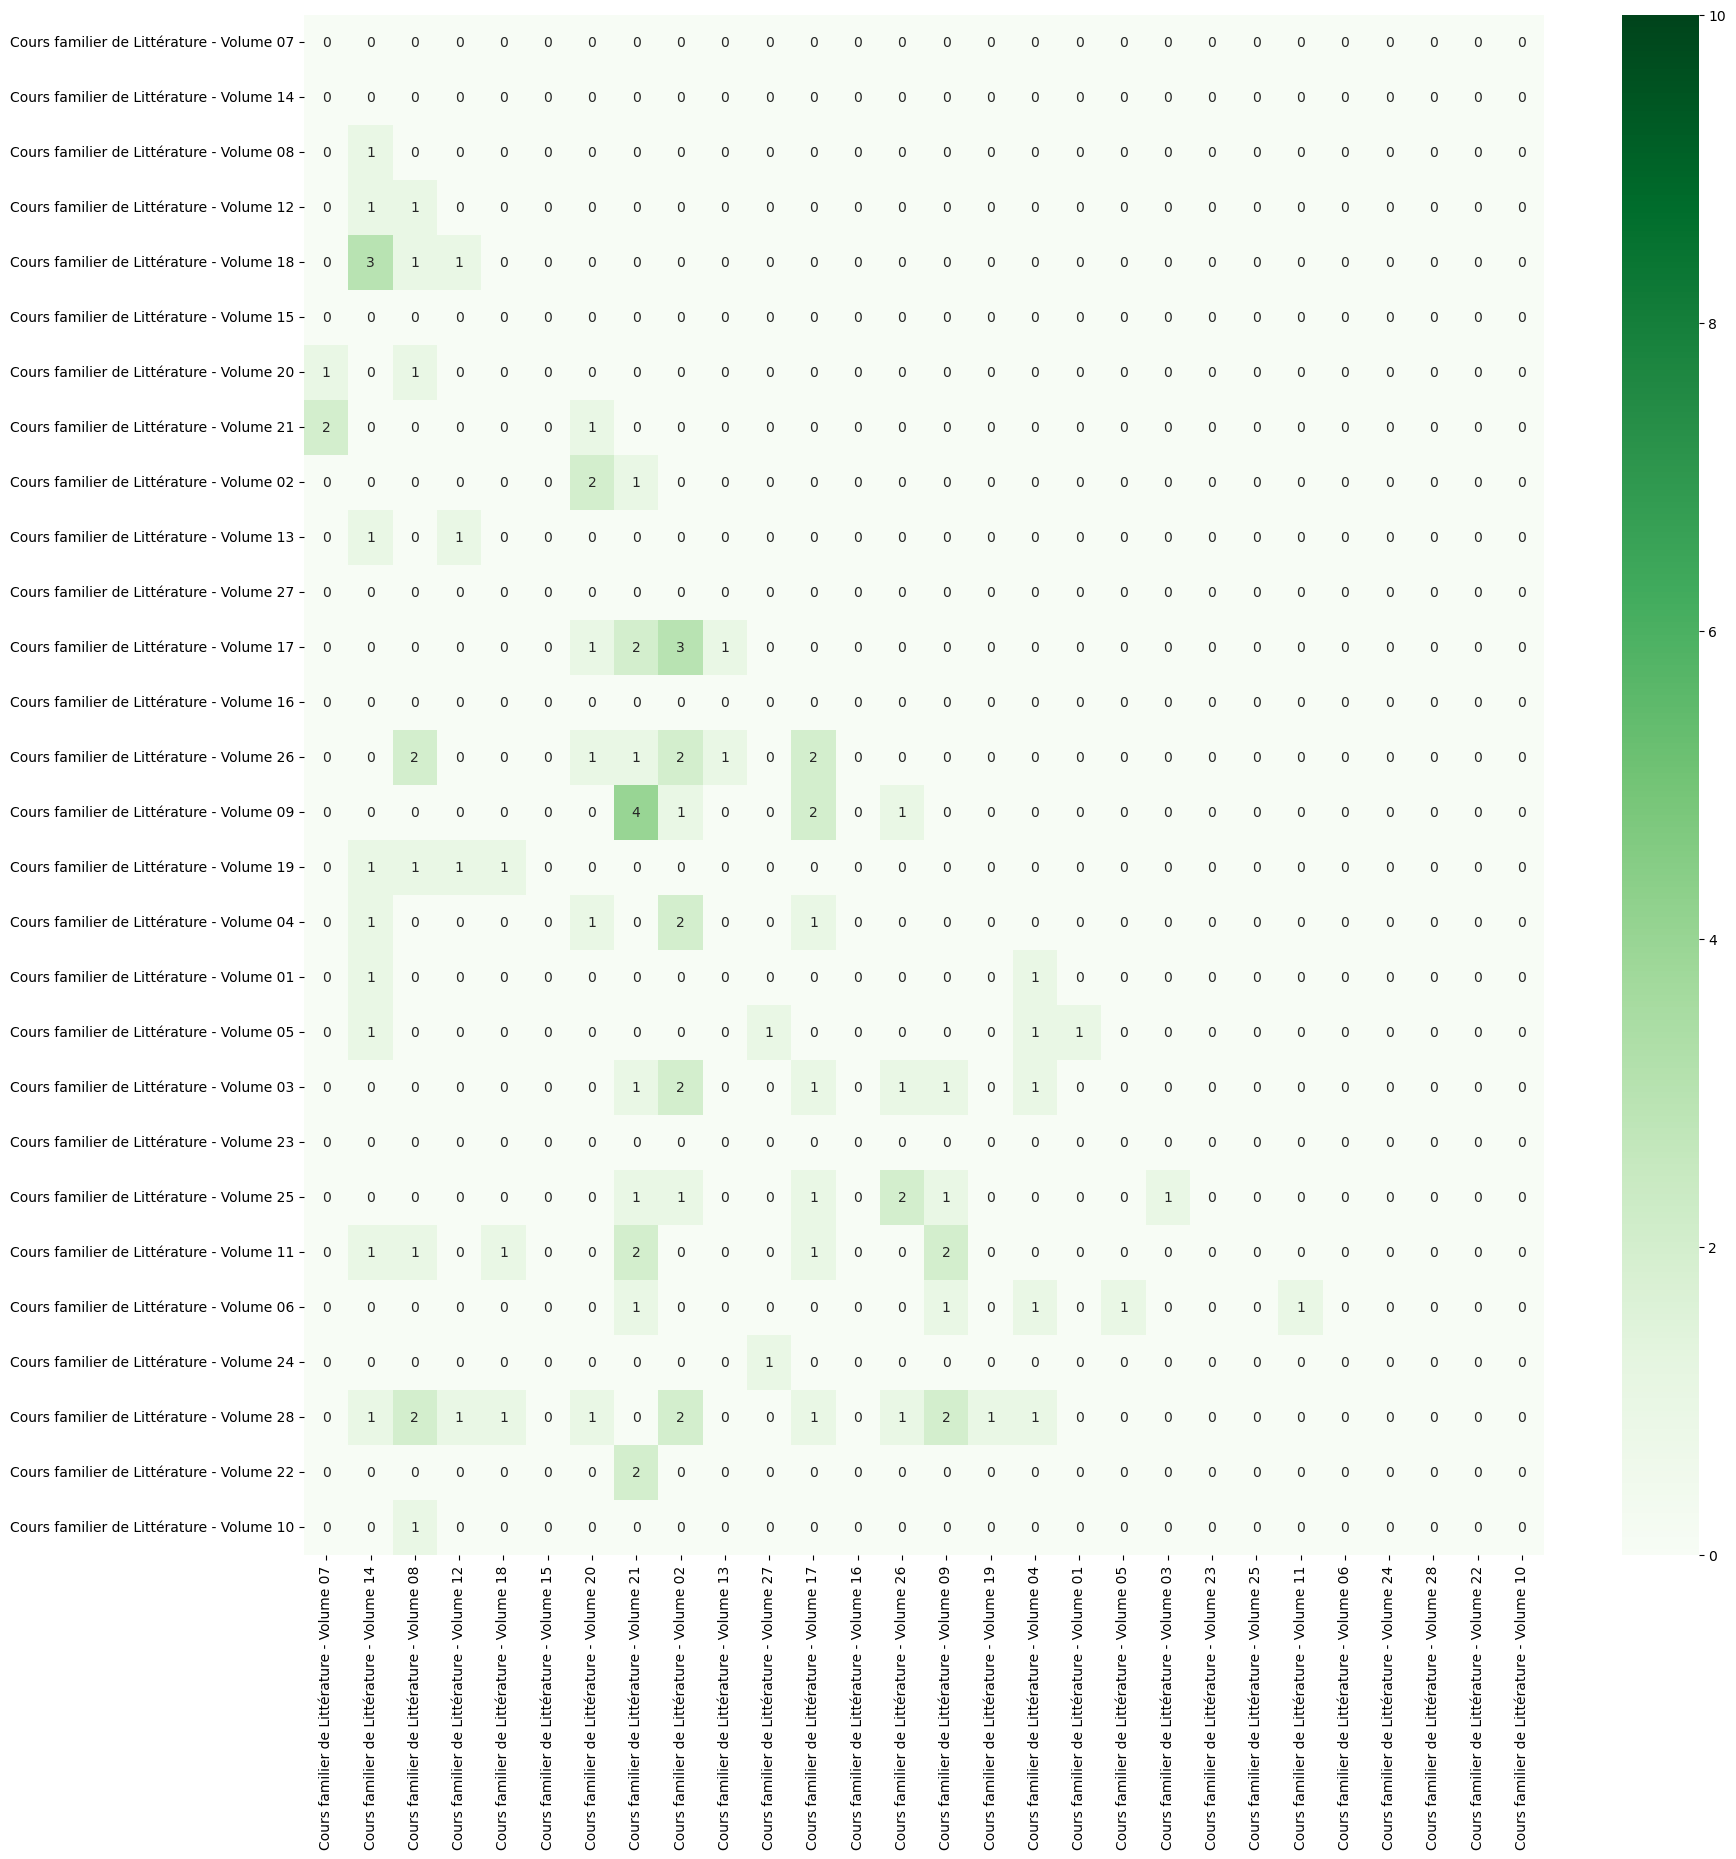

Anatole France


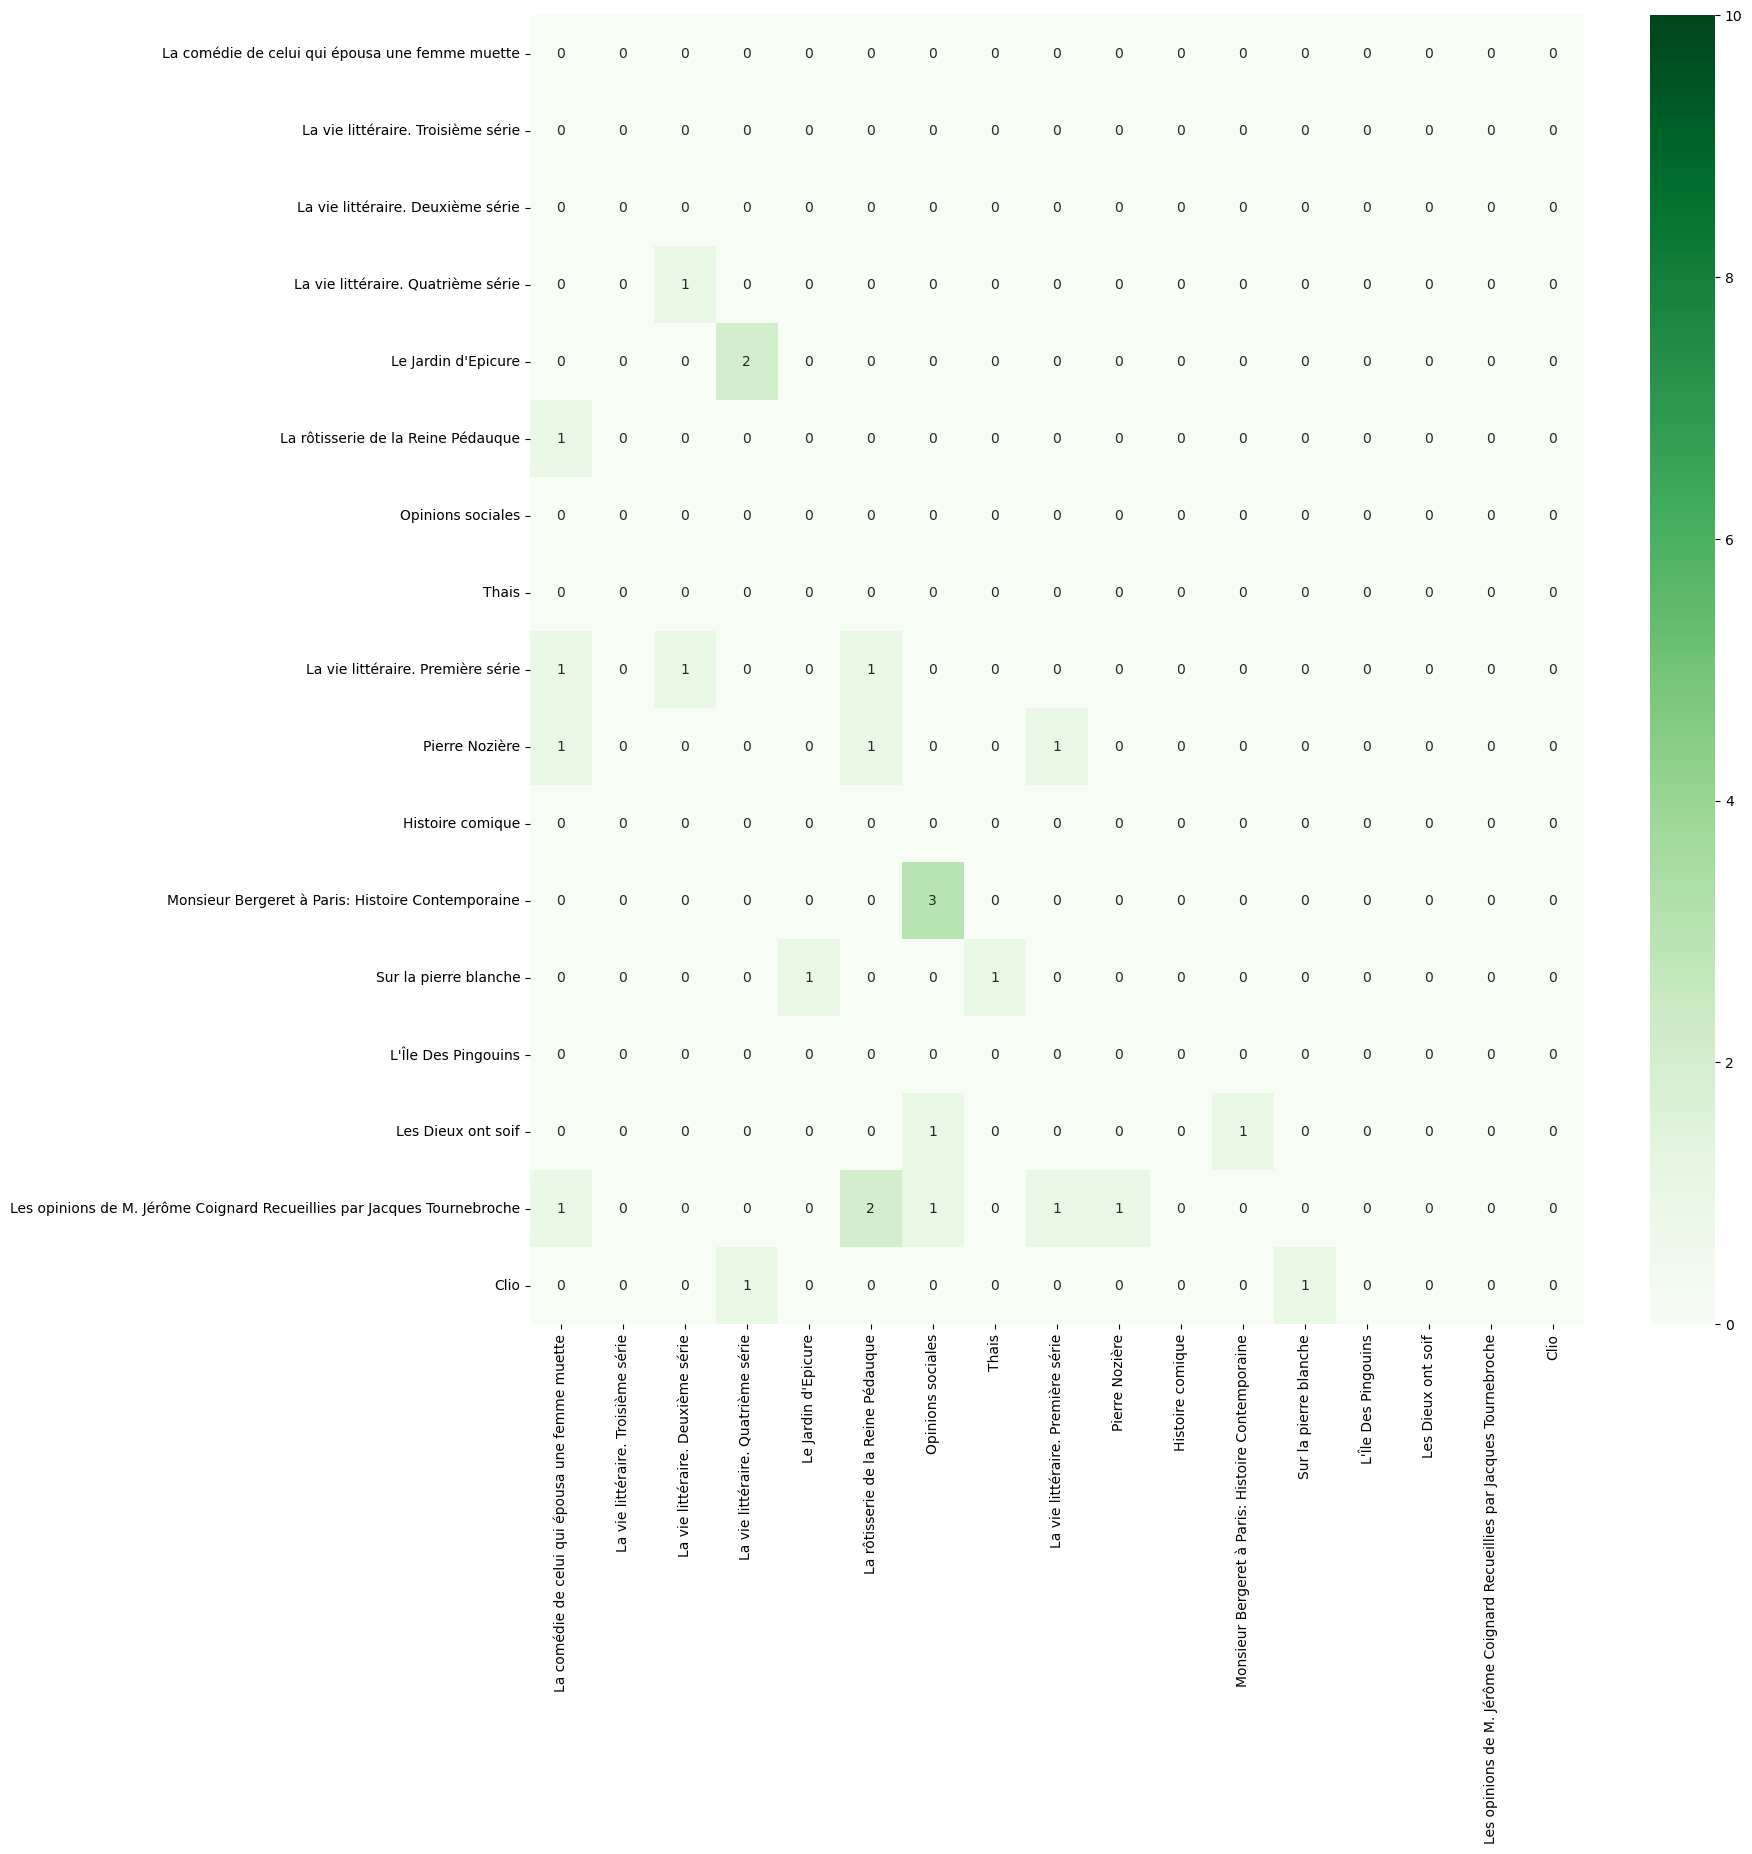

George Sand
La Daniella, Vol. I. (13917) and La Daniella, Vol. II. (14038) share
{'Medora', 'Brumières', 'Tartaglia', 'Daniella', 'Harriet', 'Mariuccia', 'Frascati'}
Correspondance, 1812-1876 — Tome 4 (13875) and Correspondance, 1812-1876 — Tome 5 (13839) share
{'Cher', 'G. SAND', 'Nohant', 'Maurice'}
Le péché de Monsieur Antoine, Tome 2 (12534) and Le péché de Monsieur Antoine, Tome 1 (12367) share
{'Janille', 'Châteaubrun', 'M. de Boisguilbault', 'Émile', 'Jean', 'M. Antoine', 'Boisguilbault', 'M. Cardonnet', 'Gilberte'}
Consuelo, Tome 1 (1861) (12666) and Consuelo, Tome 3 (1861) (13374) share
{'Consuelo', 'Albert', 'Venise', 'Porpora', 'Corilla'}
Consuelo, Tome 2 (1861) (13258) and Consuelo, Tome 3 (1861) (13374) share
{'Consuelo', 'Albert', 'Venise', 'Joseph'}
Consuelo, Tome 2 (1861) (13258) and Consuelo, Tome 1 (1861) (12666) share
{'Christian', 'Consuelo', 'Anzoleto', 'Venise', 'Albert', 'Amélie'}


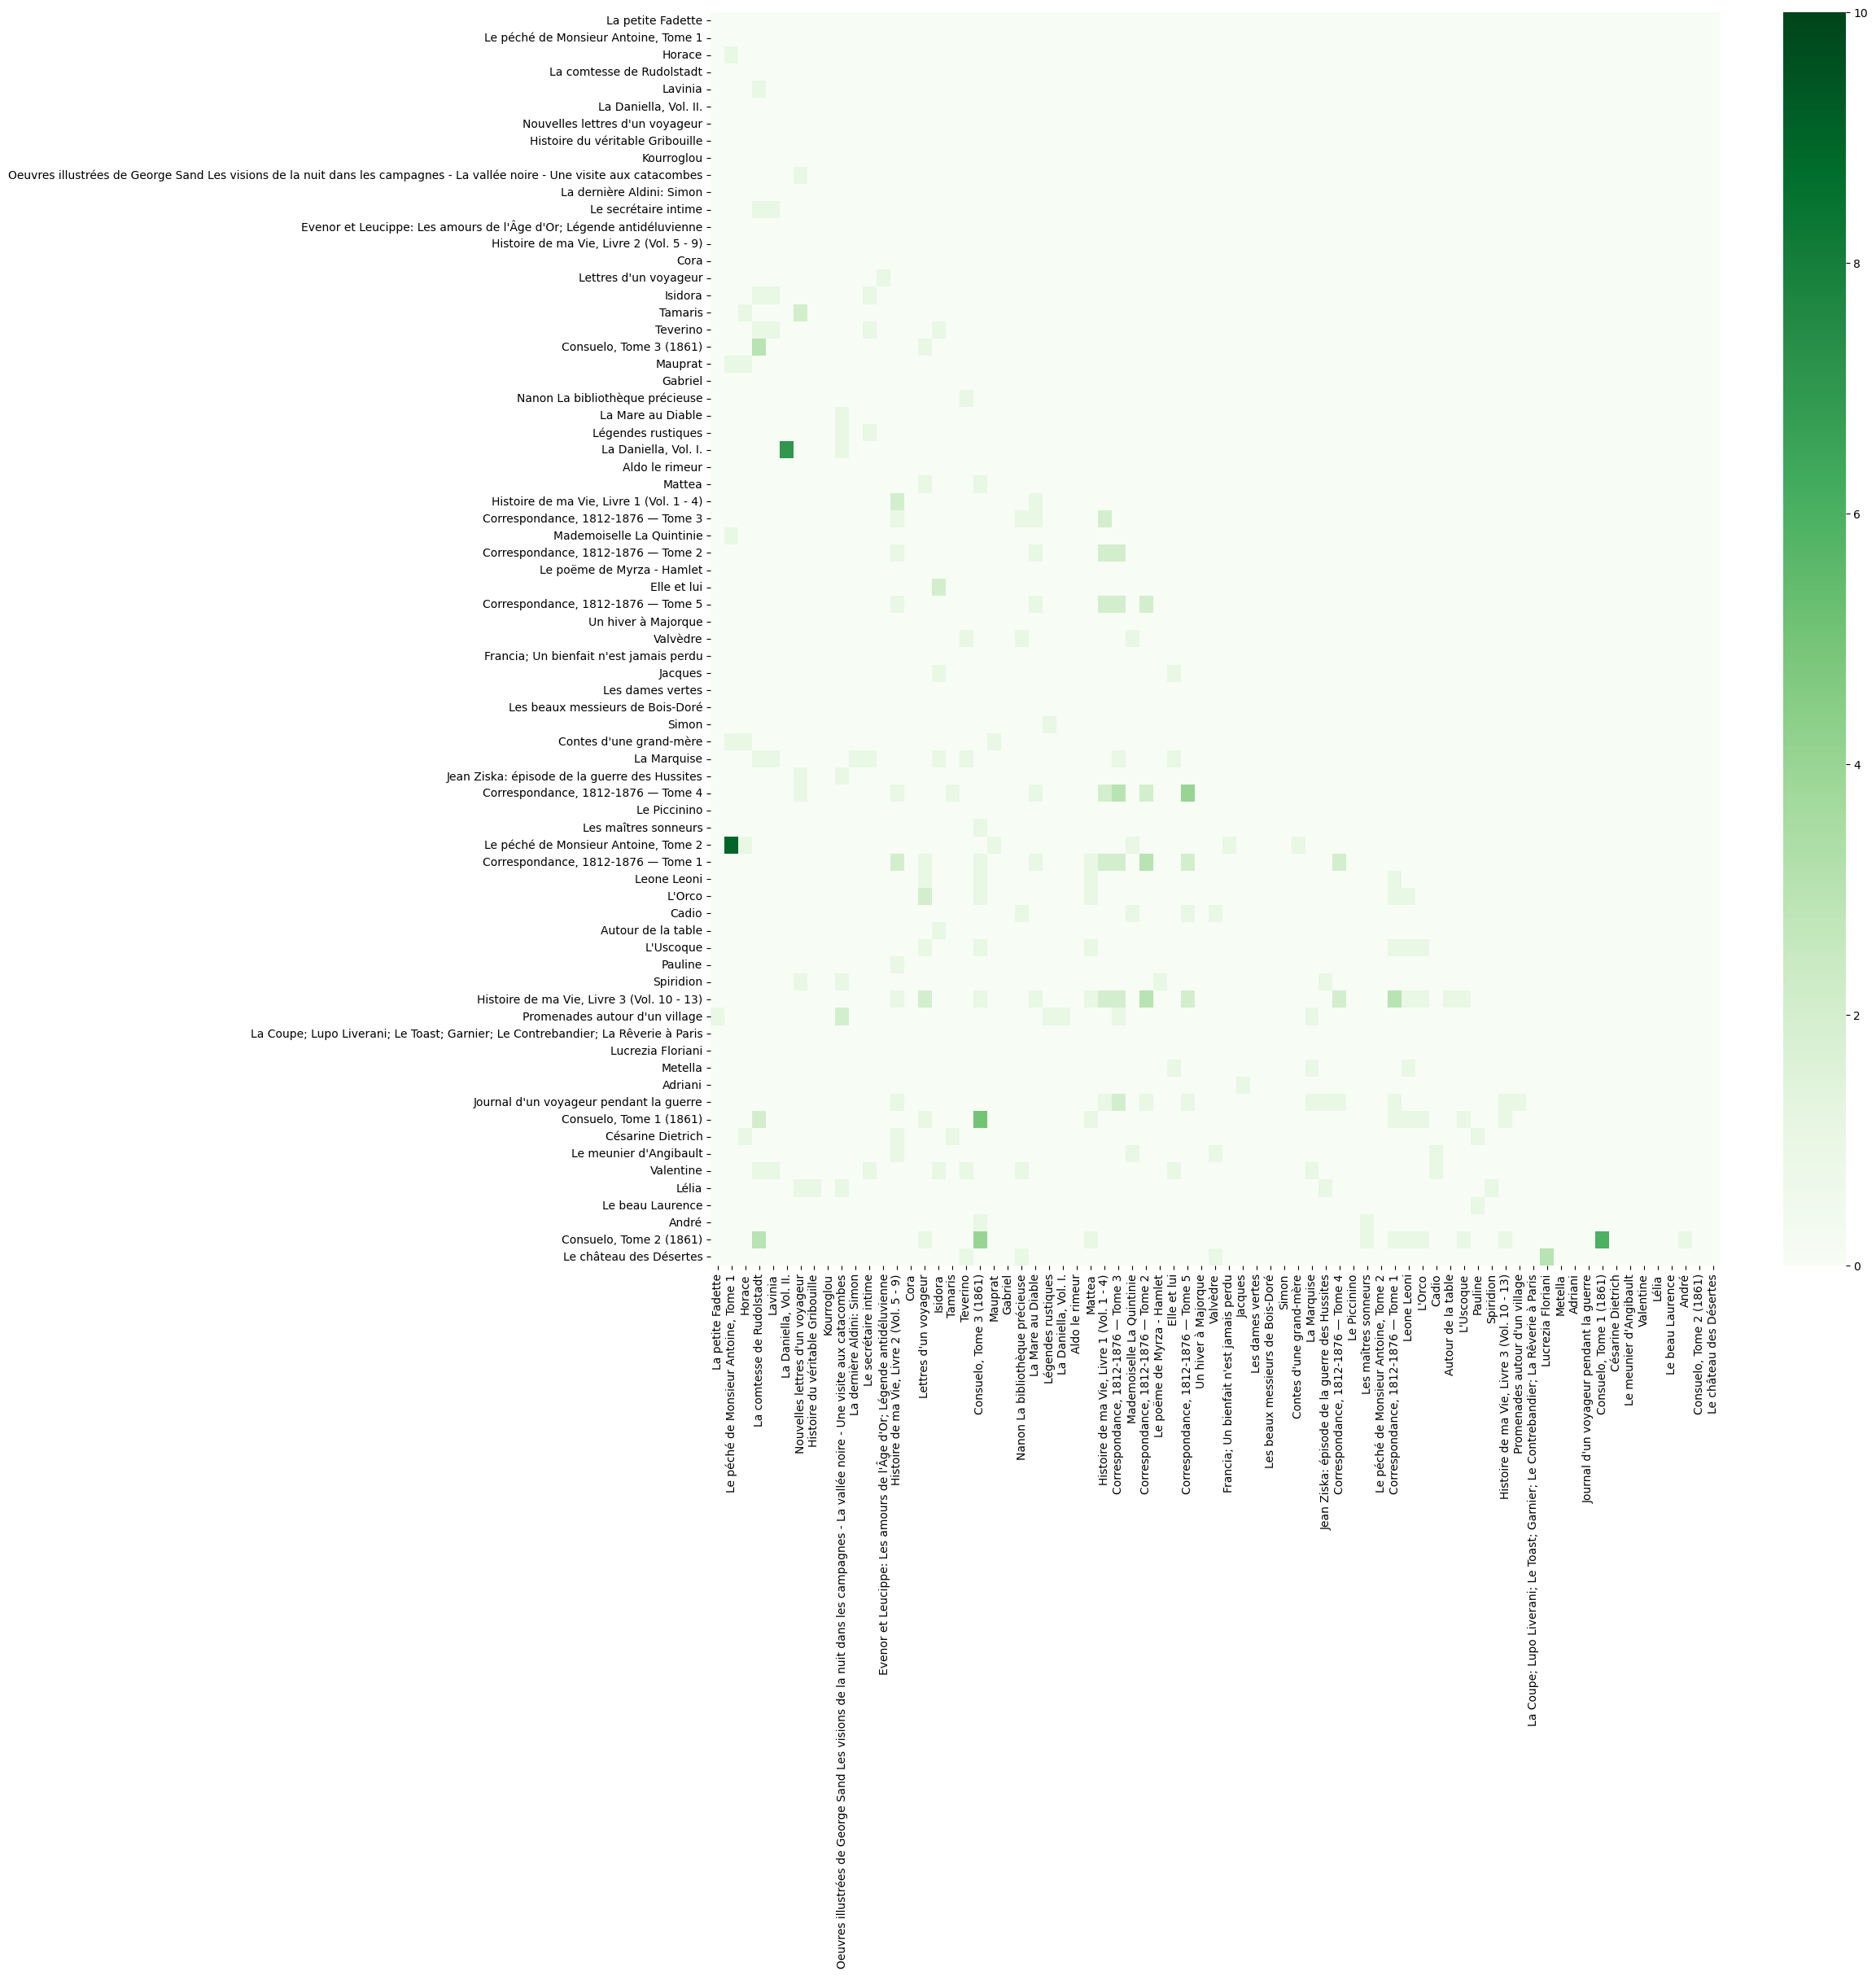

Gustave Flaubert
OEuvres complètes de Gustave Flaubert, tome 4: L'éducation sentimentale, v. 2 (52893) and OEuvres complètes de Gustave Flaubert, tome 3: L'éducation sentimentale, v. 1 (49773) share
{'Deslauriers', 'Arnoux', 'Frédéric', 'Rosanette', 'Mme Arnoux', 'Sénécal', 'Dussardier'}


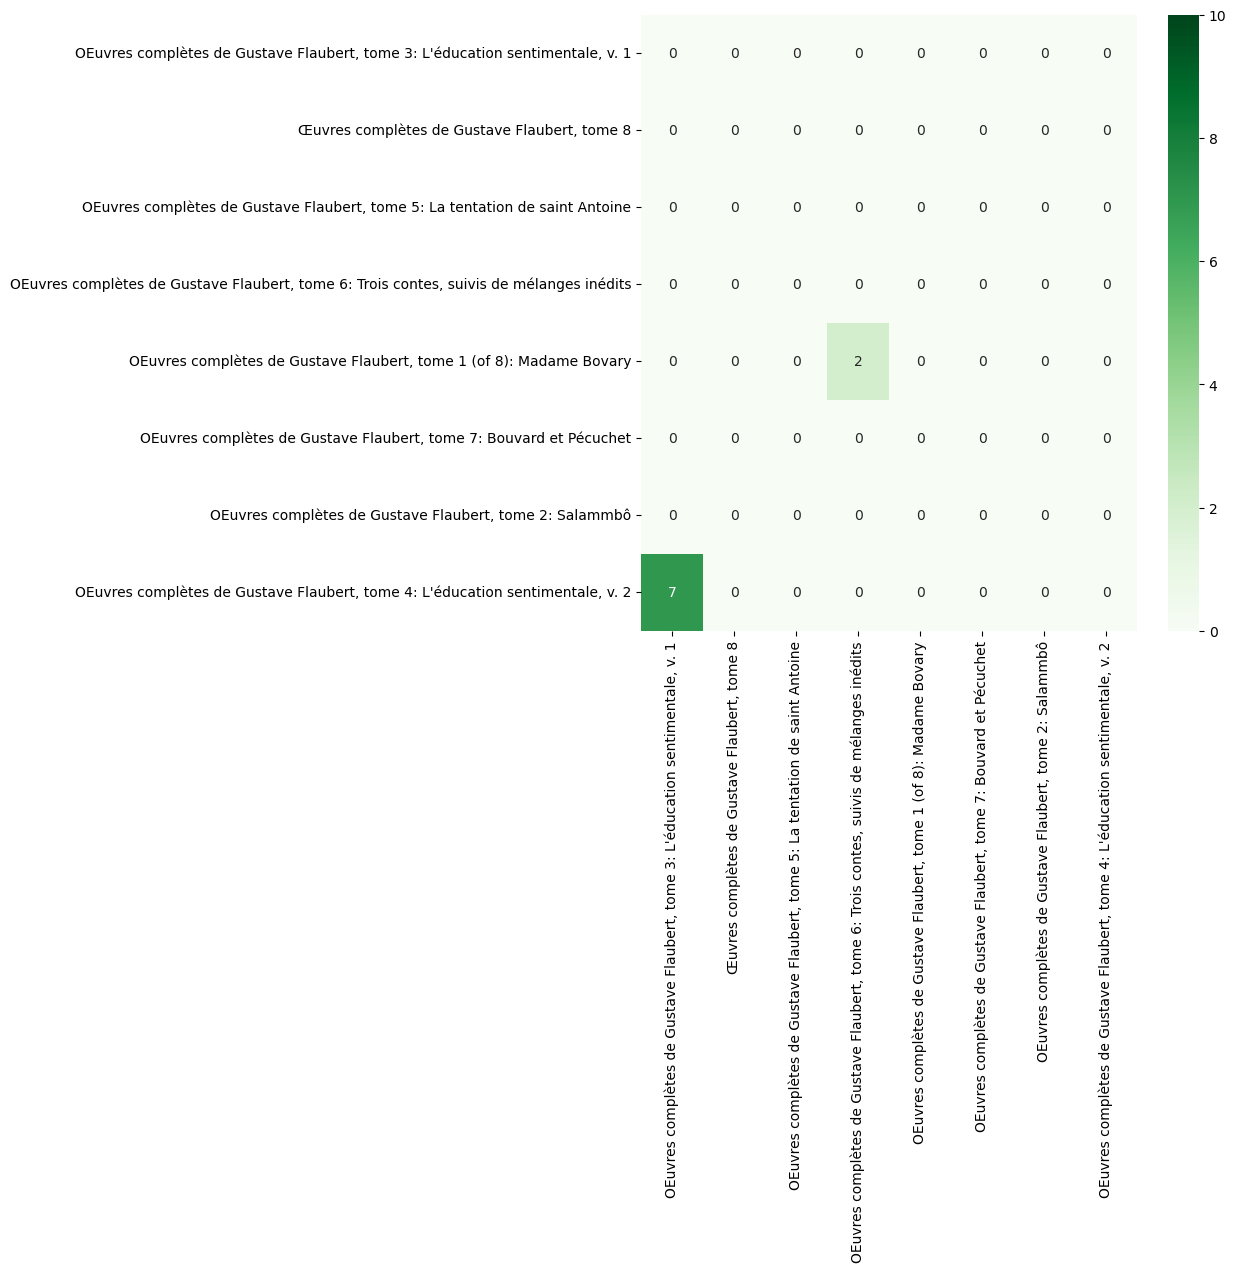

Guy de Maupassant


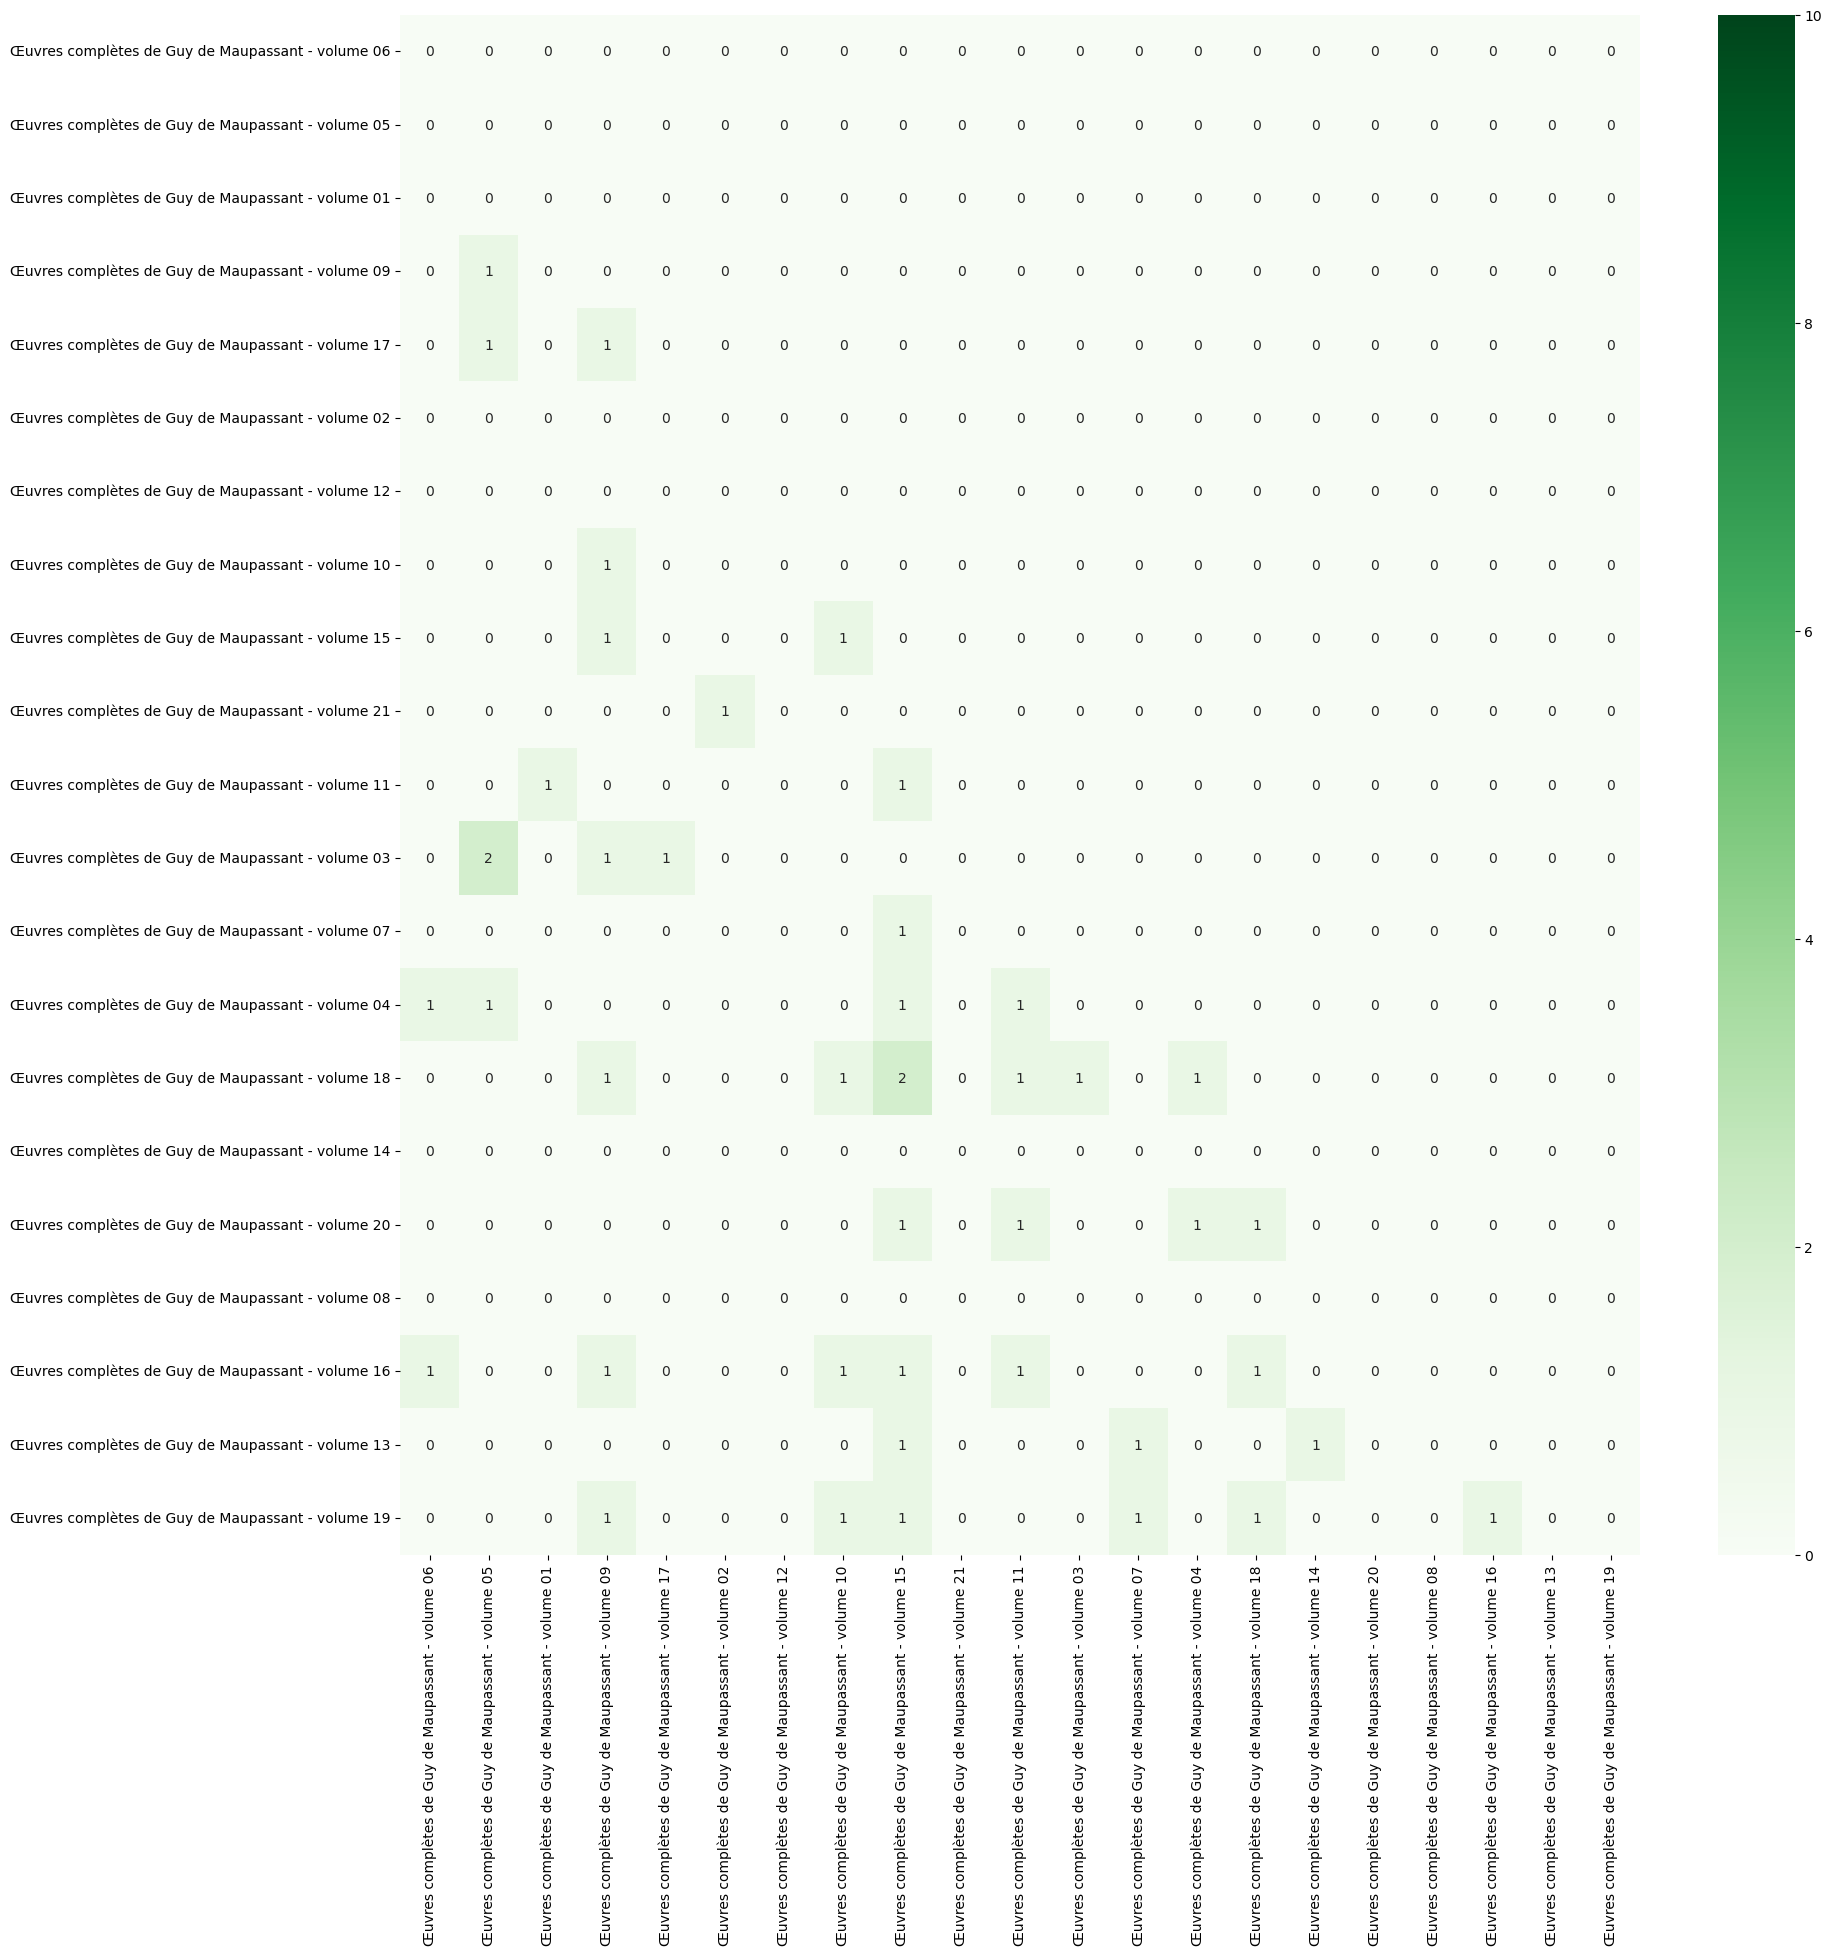

Jules Verne
Autour de la Lune (4717) and De la terre à la lune: trajet direct en 97 heures 20 minutes (799) share
{'la Terre', 'Barbicane', 'Michel Ardan', 'Nicholl', 'Lune'}
Kéraban-Le-Têtu, Volume I (8174) and Kéraban-Le-Têtu, Volume II (8175) share
{'Amasia', 'Kéraban', 'Van Mitten', 'Bruno', 'Ahmet', 'Nizib'}
Sans dessus dessous (12533) and De la terre à la lune: trajet direct en 97 heures 20 minutes (799) share
{'J.-T. Maston', 'la Terre', 'Barbicane', 'Nicholl', 'Gun-Club'}


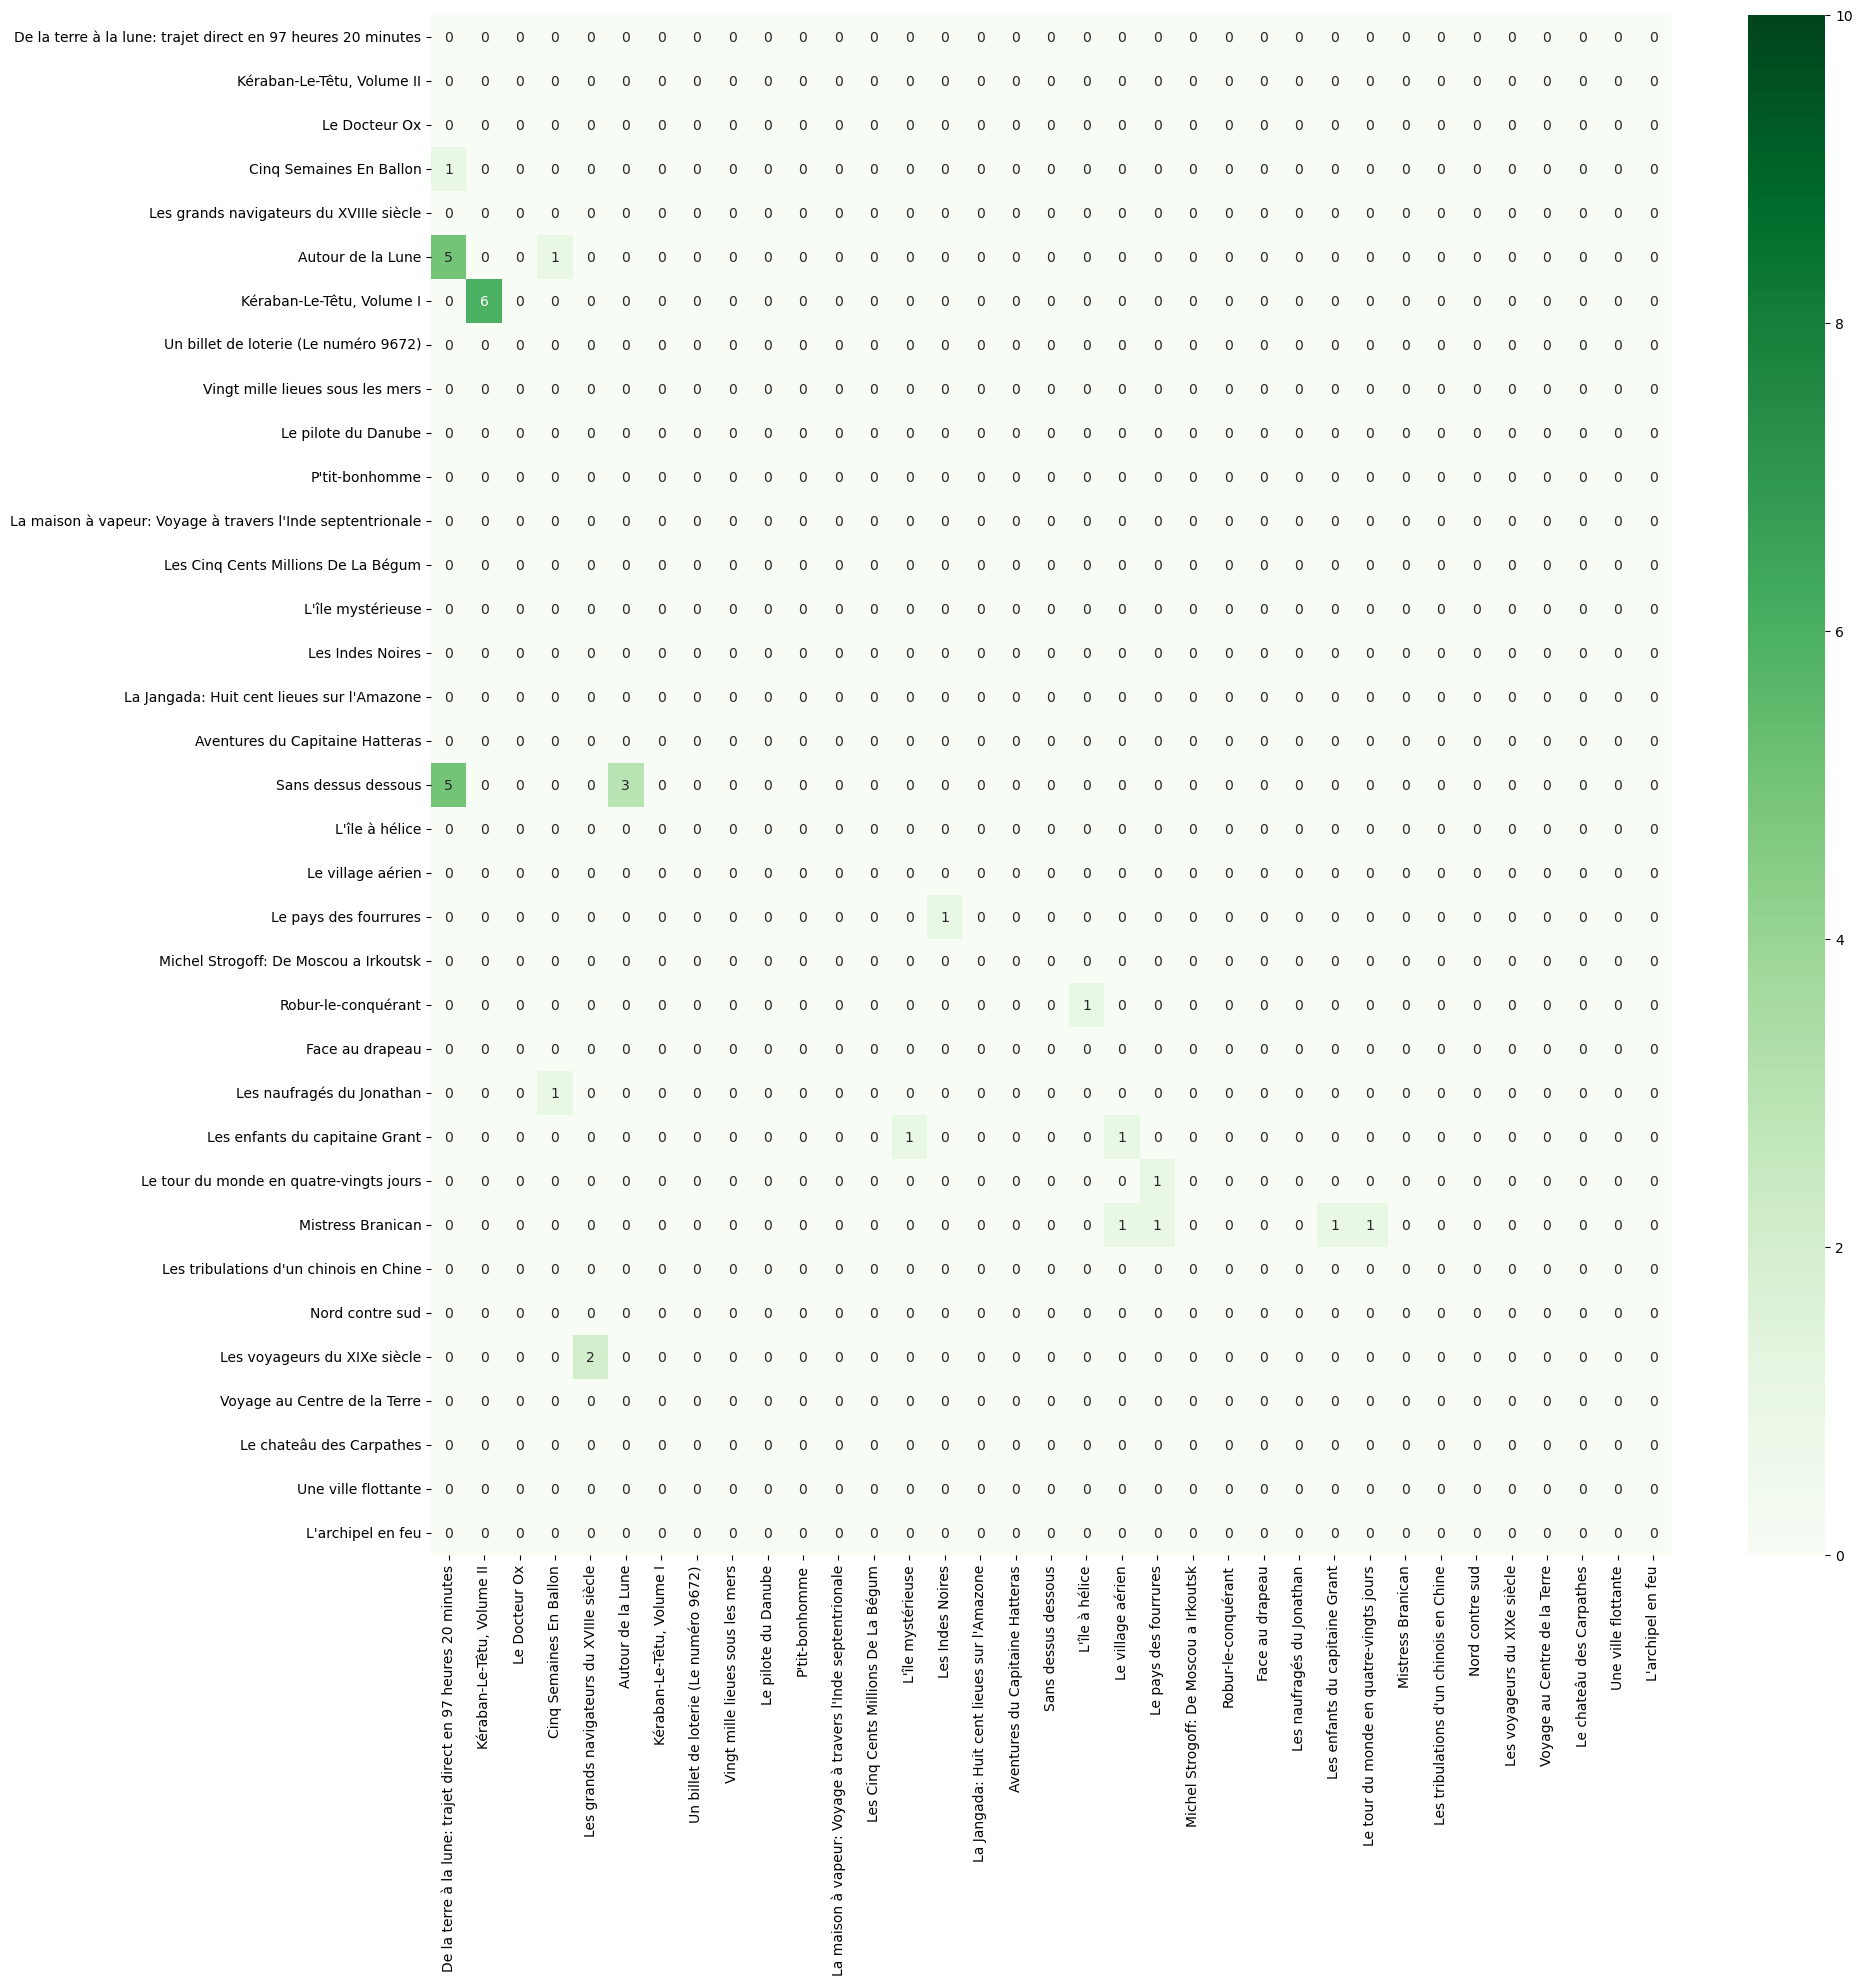

Marcel Proust
A l'ombre des jeunes filles en fleurs - Première partie (2998) and A l'ombre des jeunes filles en fleurs — Deuxième partie (2999) share
{'Mme Swann', 'Gilberte', 'Françoise', 'Swann'}
Le Côté de Guermantes - Deuxième partie (12999) and Le Côté de Guermantes - Première partie (8946) share
{'Saint-Loup', 'Mme de Guermantes', 'Françoise', 'Robert'}
La Prisonnière (Sodome et Gomorrhe III) (60720) and Sodome et Gomorrhe - Première partie (15288) share
{'M. de', 'Albertine', 'M. de Charlus', 'Françoise', 'Charlus', 'Balbec'}
Albertine disparue Vol 1 (of 2) À la recherche du temps perdu, Tome 7 (64427) and Le Côté de Guermantes - Première partie (8946) share
{'Saint-Loup', 'Balbec', 'Françoise', 'Robert'}
Albertine disparue Vol 1 (of 2) À la recherche du temps perdu, Tome 7 (64427) and A l'ombre des jeunes filles en fleurs — Deuxième partie (2999) share
{'Aimé', 'Swann', 'Françoise', 'Balbec', 'Gilberte'}
Albertine disparue Vol 1 (of 2) À la recherche du temps perdu, Tome 7 (644

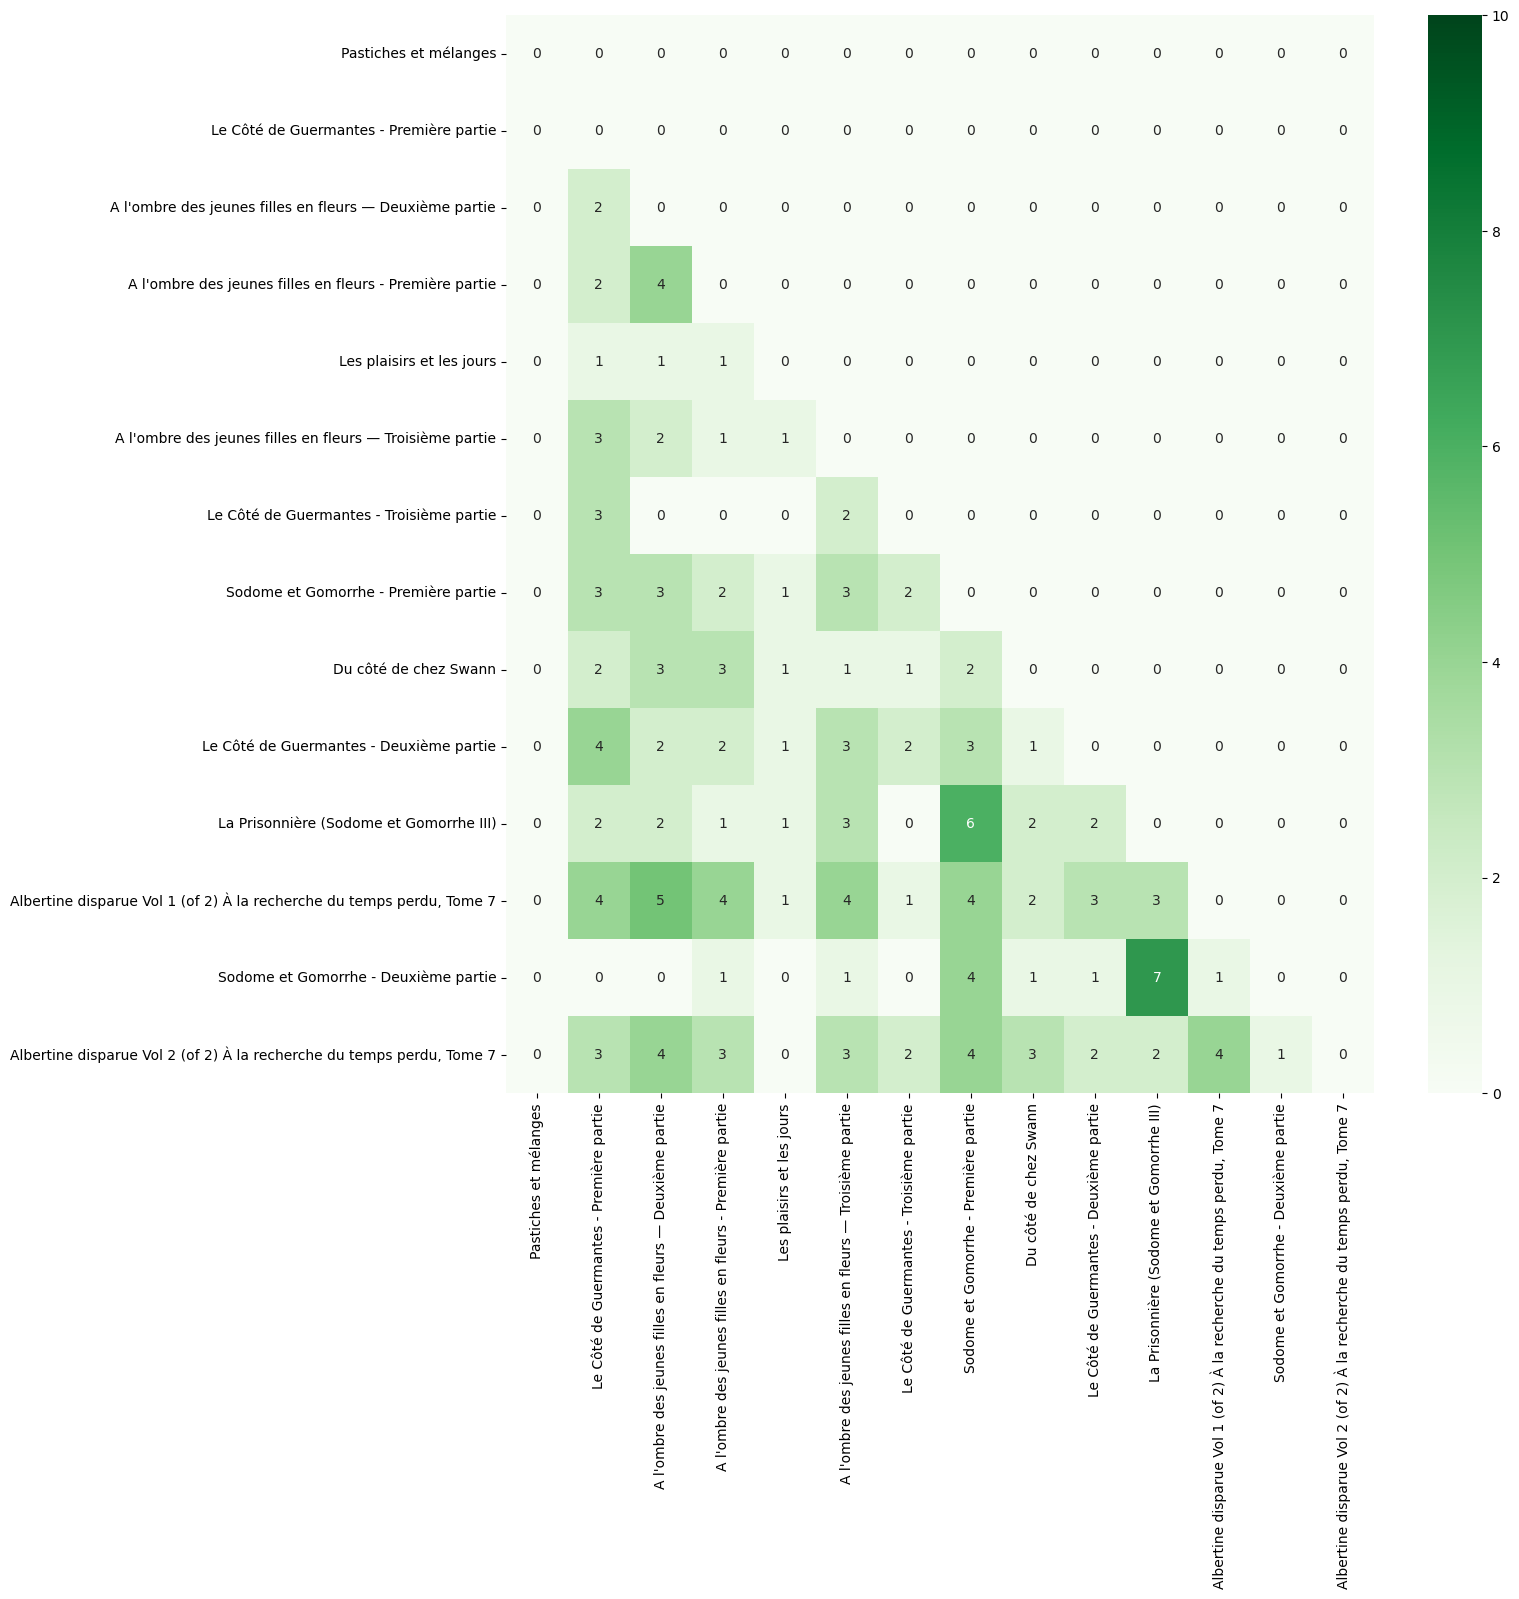

Victor Hugo
Les misérables Tome II: Cosette (17493) and Les misérables Tome I: Fantine (17489) share
{'Javert', 'Cosette', 'Thénardier', 'Jean Valjean'}
Les contemplations: Autrefois, 1830-1843 (29843) and Post-scriptum de ma vie (63768) share
{'Virgile', 'Eschyle', 'Homère', 'Dante'}
Les misérables Tome V: Jean Valjean (17519) and Les misérables Tome I: Fantine (17489) share
{'Javert', 'Cosette', 'Thénardier', 'Jean Valjean'}
Les misérables Tome V: Jean Valjean (17519) and Les misérables Tome III: Marius (17494) share
{'Gillenormand', 'Marius', 'M. Gillenormand', 'Enjolras'}
Les misérables Tome V: Jean Valjean (17519) and Les misérables Tome II: Cosette (17493) share
{'Javert', 'Cosette', 'Thénardier', 'Jean Valjean'}
Les misérables Tome V: Jean Valjean (17519) and Les misérables Tome IV: L'idylle rue Plumet et l'épopée rue Saint-Denis (17518) share
{'Cosette', 'Thénardier', 'Marius', 'Jean Valjean'}


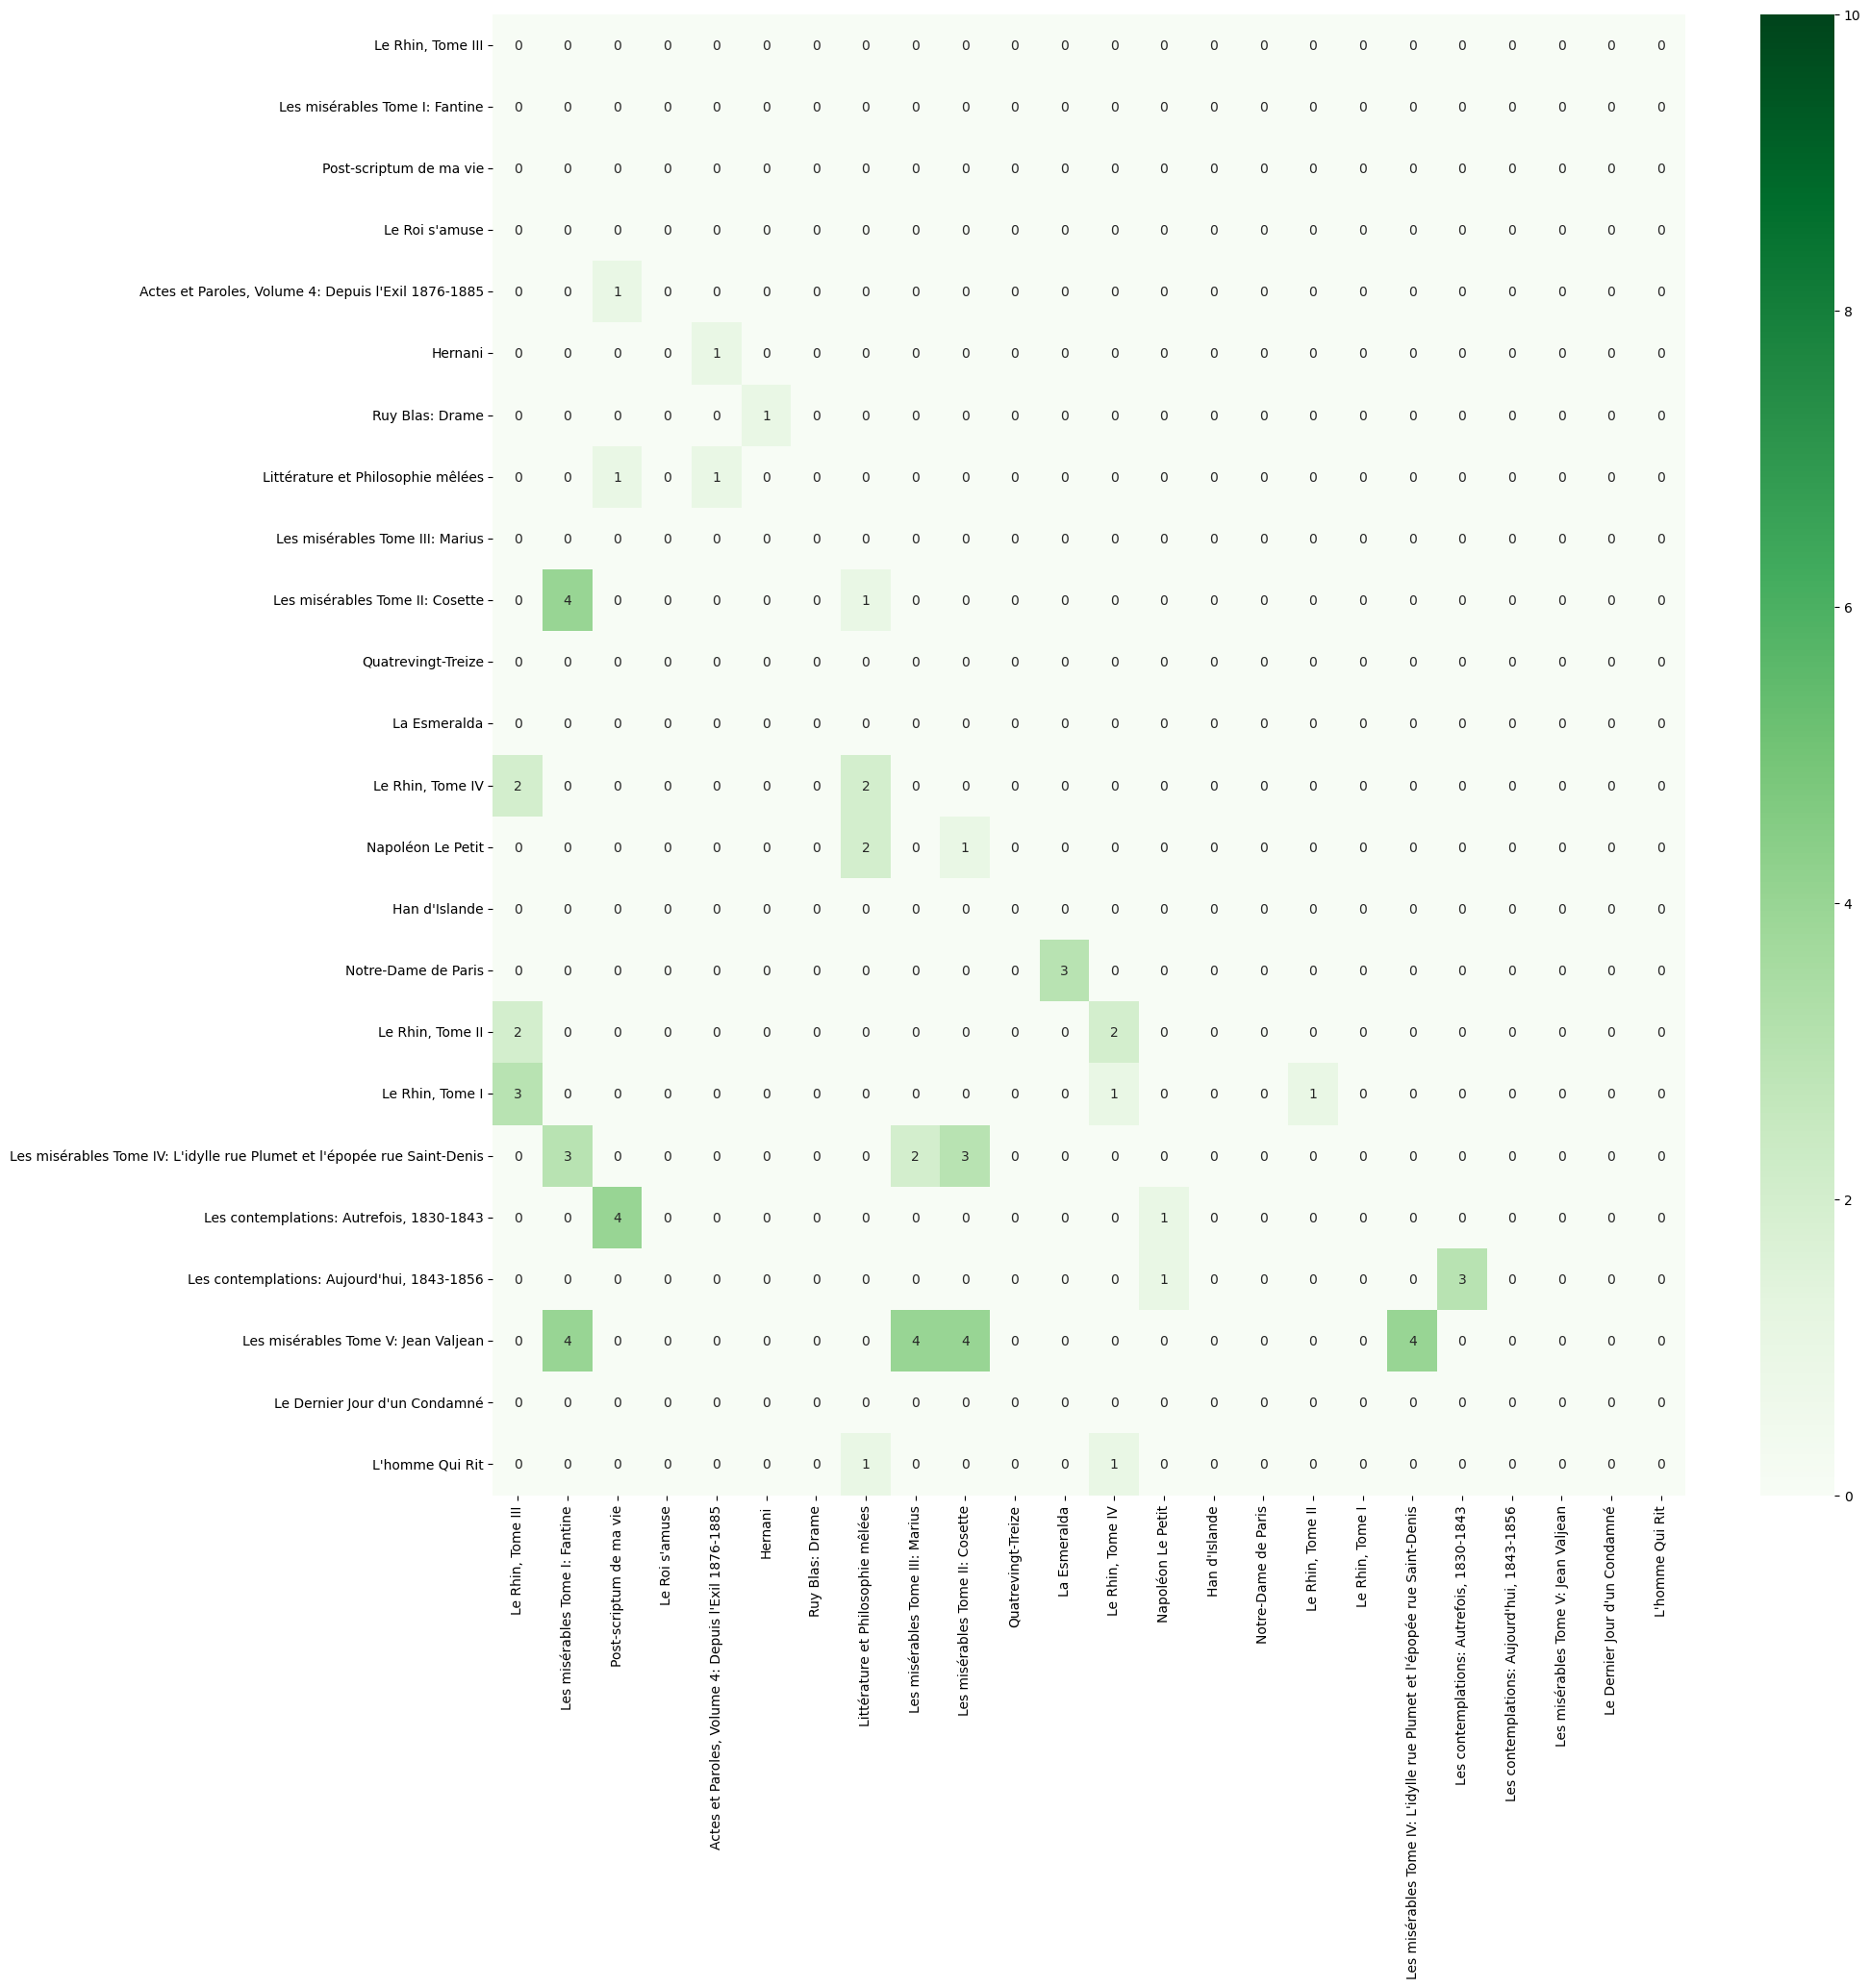

Émile Zola
L'Assommoir (6497) and Correspondance: Les lettres et les arts (56622) share
{'Coupeau', 'Gervaise', 'Nana', 'Goujet', 'Virginie', 'Lantier'}


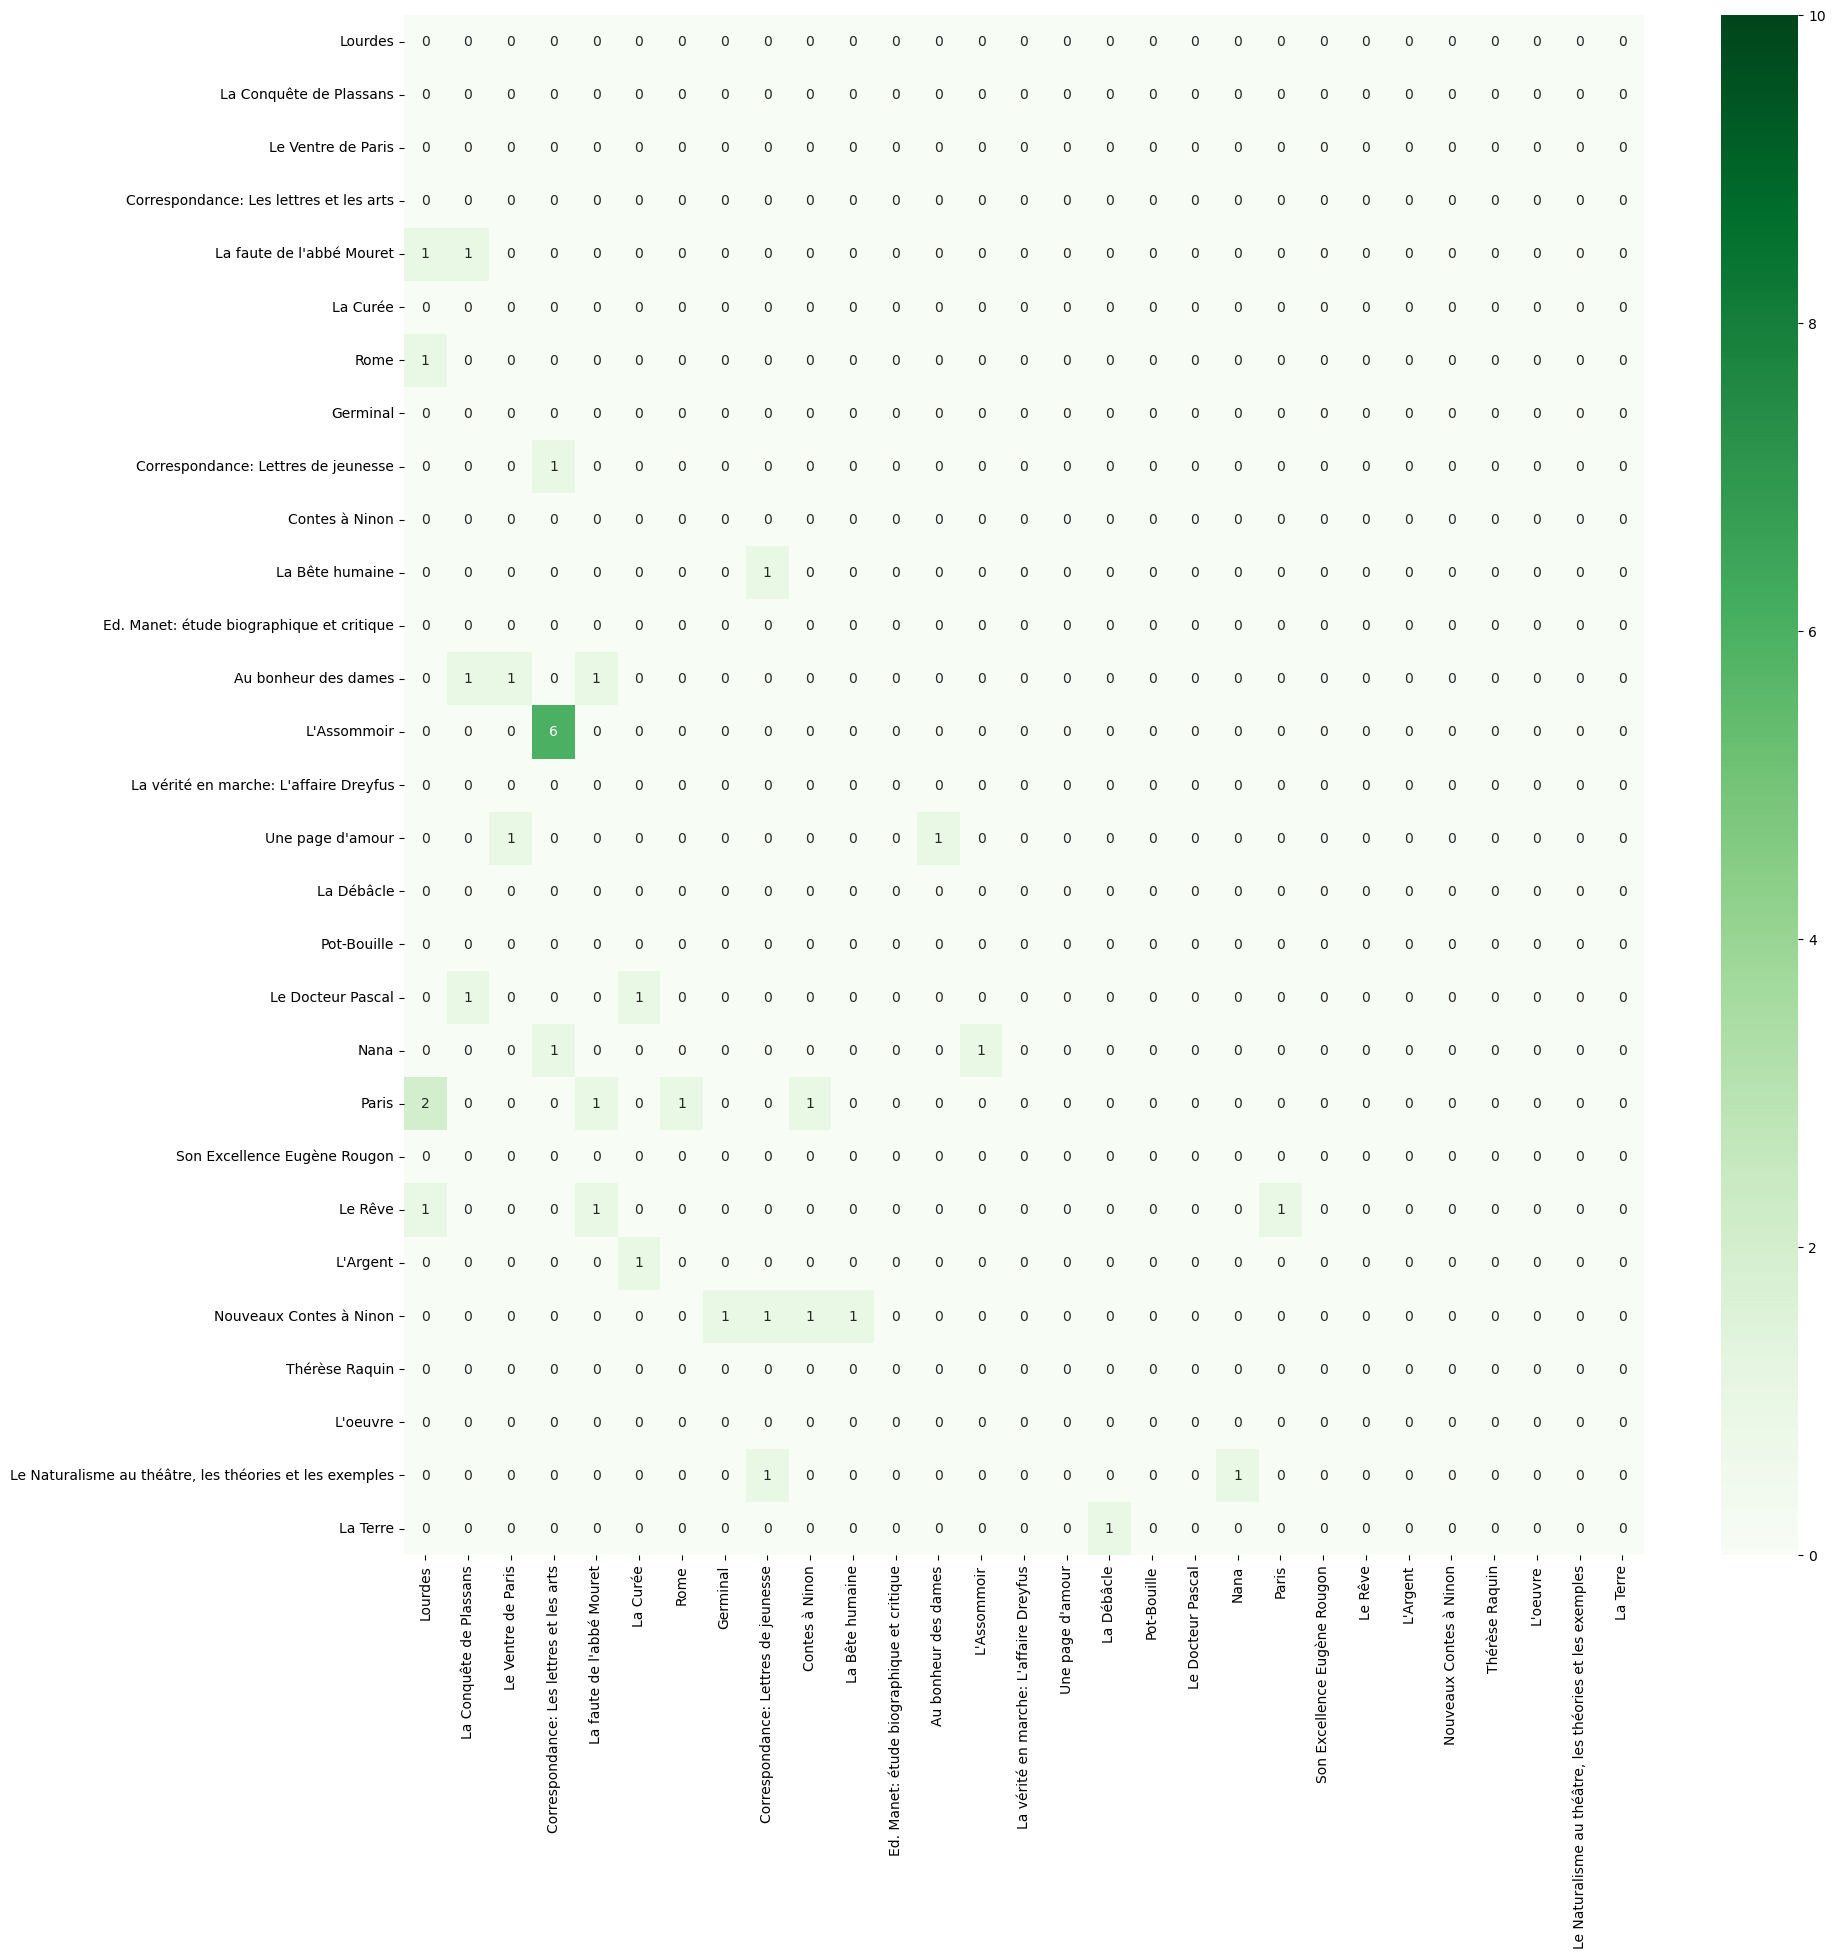

In [42]:
import seaborn as sns
ner_mtx={}
stopnes=['Dieu', 'Paris', 'Ah!', 'Oh!', 'la France', 'Monsieur', 'Rome']
names={}
for author, group in no_dupl.groupby('author'):
    print("\033[5;8;4m"+author+"\033[0;0;0m")
    ner_mtx[author]=np.zeros((len(group.index), len(group.index)))
    for row_n1, (row_i1, row1) in enumerate(group.iterrows()):
        names[row_n1]=[name[0] for name in nes(row_i1, stopnes).most_common(10)]
        for row_n2, (row_i2, row2) in enumerate(group.iterrows()):
            if row_n2<row_n1:
                common_names=set(names[row_n1])&set(names[row_n2])
                ner_mtx[author][row_n1,row_n2]=len(common_names)
                if len(common_names)>=4:
                    print("{} ({}) and {} ({}) share".format(row1["title"],row_i1, row2["title"],row_i2))
                    print(common_names)
            else:
                ner_mtx[author][row_n1,row_n2]=0
    if len(group)>50: 
        annot=False
    else:
        annot=True
    figsize_x=min(len(group.index), 20)
    plt.figure(figsize=(figsize_x, figsize_x))
    sns.heatmap(ner_mtx[author], 
            xticklabels=group['title'].values, 
            yticklabels=group['title'].values,
            annot=annot,
            vmin=0, vmax=10,
            cmap='Greens')
    plt.show()
            


### Excursus - mentions of protagonists and locations in the books

While this may not inform our classificator, named entity recognition can be quite useful to show one aspect of the structure of a fictional book: when do certain protagonists appear and disappear in a book and where the action takes place.
Named entity recognition is not perfect, however: a number of protagonists are recognized as locations and have to be manually excluded.

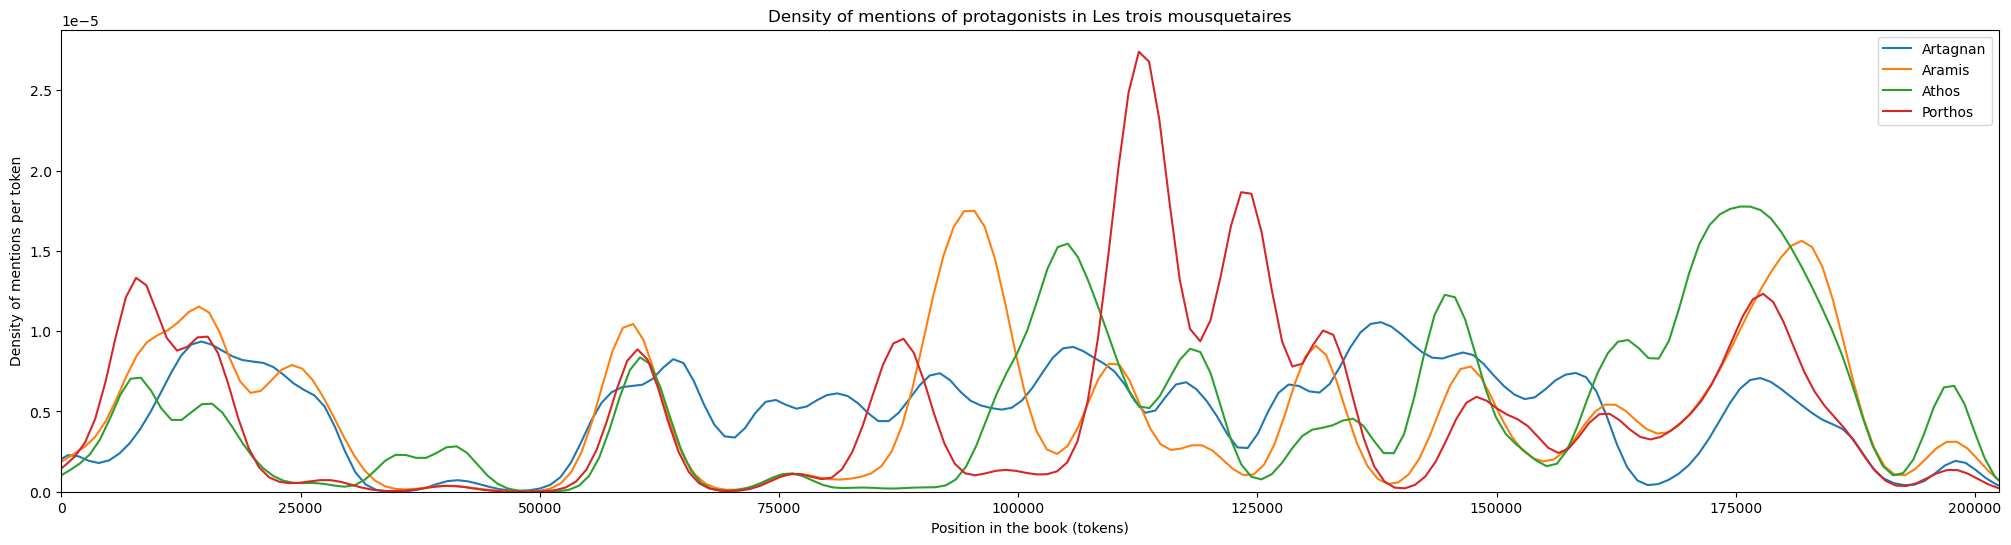

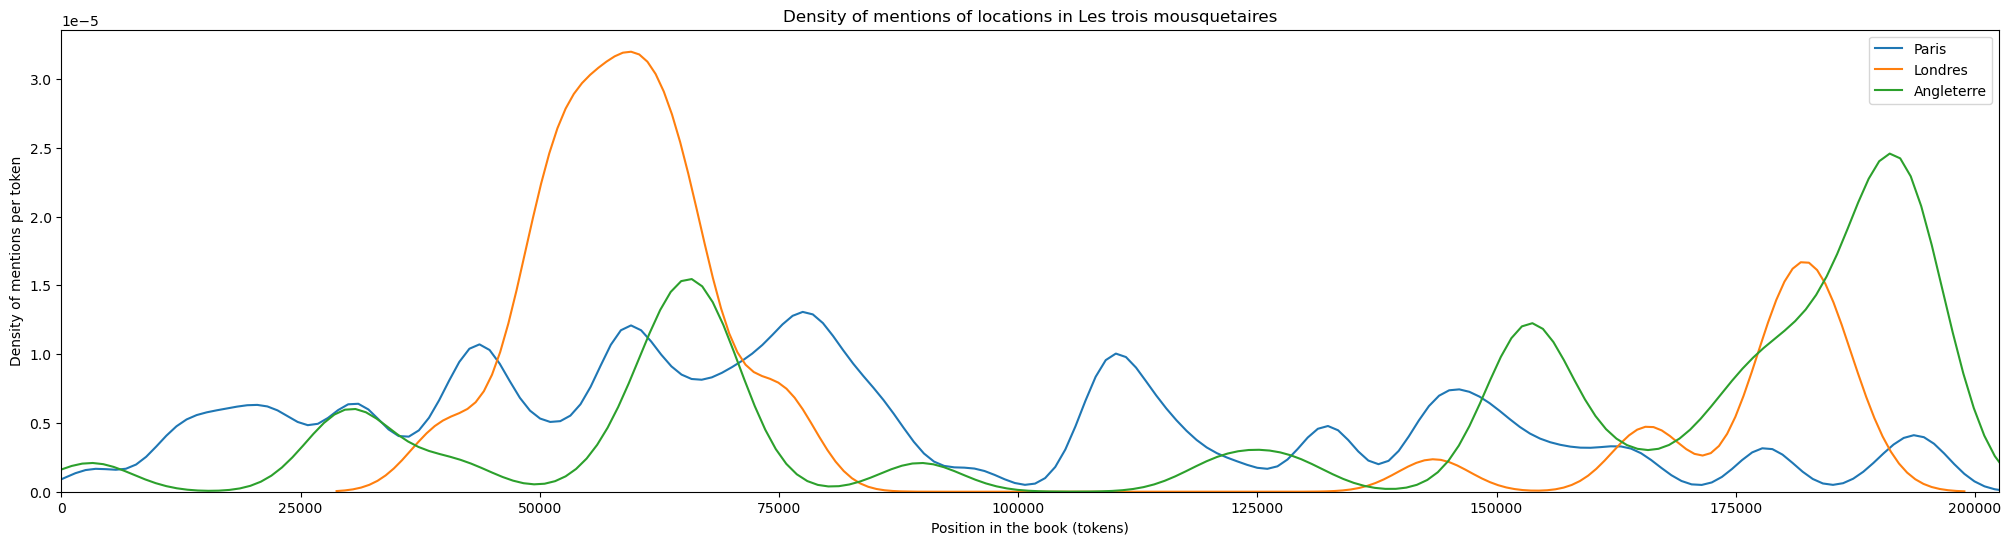

In [43]:

def common_named_entites(book_number, n, stop_nes=[], ne_type='PER'):
    labels=[str(ent.label_) for ent in docs[book_number].ents if (str(ent) not in stop_nes)]
    nes=[str(ent) for ent in docs[book_number].ents if (str(ent) not in stop_nes)&(ent.label_==ne_type)]
    cnes=[k for k, v in Counter(nes).most_common(n)]
    positions={}
    for ne in cnes:
        positions[ne]=[ent.start for ent in docs[book_number].ents if str(ent)==ne]
    return cnes, positions


def ne_plot(book_number, n, stop_nes=[], ne_type='PER', ne_type_name='protagonists'):
    cnes, positions=common_named_entites(book_number, n, stop_nes=stop_nes, ne_type=ne_type)
    %matplotlib inline
    plt.figure(figsize=(25,6))
    for ne in cnes:
        sns.kdeplot(positions[ne], label = ne, bw_adjust=.15)
    
    plt.xlim(0, len(docs[book_number]))
    plt.legend()
    plt.title('Density of mentions of {} in {}'.format(ne_type_name, no_dupl.loc[book_number, 'title']))
    plt.xlabel('Position in the book (tokens)')
    plt.ylabel('Density of mentions per token')
    plt.show()
ne_plot(13951, 4)
ne_plot(13951, 3, stop_nes=['Bonacieux', 'Buckingham', 'Anglais', 'Porthos'], ne_type='LOC', ne_type_name='locations')

We should not forget, however, that we cut the beginning and end of the books for our purposes as a workaround (to be sure that we only have text written by the author). To do a proper analysis, the whole book should be analysed.

# Metadata comparison

Sometimes we can see already from the title that certain books belong together as a volume number is stated. We leave out Lamartine and Maupassant as the title of their books (Cours familier de Littérature, Œuvres complètes) is almost the same and it does not tell much about any overlap.

In [44]:

title_nlp={}
for author, group in no_dupl.groupby('author'):
    if author not in ['Alphonse de Lamartine','Guy de Maupassant']:
        print("\033[5;8;4m"+author+"\033[0;0;0m")
        for row_n1, (row_i1, row1) in enumerate(group.iterrows()):
            title_nlp[row_n1]=nlp(row1["title"])
            for row_n2, (row_i2, row2) in enumerate(group.iterrows()):
                if row_n2<row_n1:
                    if title_nlp[row_n1].similarity(title_nlp[row_n2])>.90:
                        print (row1["title"], row_i1, row2["title"], row_i2)
                        

Alexandre Dumas
Le capitaine Paul 15574 Le capitaine Pamphile 18697
La San-Felice, Tome 05 18773 La San-Felice, Tome 03 18402
Le Capitaine Aréna — Tome 1 8693 Le Capitaine Aréna — Tome 2 8692
Le Collier de la Reine, Tome I 18199 Le Collier de la Reine, Tome II 18200
Le comte de Monte-Cristo, Tome I 17989 Le comte de Monte-Cristo, Tome IV 17992
Les Quarante-Cinq — Tome 2 7771 Les Quarante-Cinq — Tome 1 7770
Le corricolo 9262 Le capitaine Pamphile 18697
La dame de Monsoreau — ­Tome 1. 9637 La dame de Monsoreau — Tome 3. 9639
La San-Felice, Tome 02 18401 La San-Felice, Tome 03 18402
La San-Felice, Tome 02 18401 La San-Felice, Tome 05 18773
La dame de Monsoreau — Tome 2. 9638 La dame de Monsoreau — Tome 3. 9639
La dame de Monsoreau — Tome 2. 9638 La dame de Monsoreau — ­Tome 1. 9637
Le Speronare 8863 Le capitaine Pamphile 18697
Le Speronare 8863 Le corricolo 9262
Le comte de Monte-Cristo, Tome II 17990 Le comte de Monte-Cristo, Tome IV 17992
Le comte de Monte-Cristo, Tome II 17990 Le comte

/var/folders/gw/1fh2zq8d6fd480344ykwh8h80000gn/T/ipykernel_56376/2355911378.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if title_nlp[row_n1].similarity(title_nlp[row_n2])>.90:


Les Quarante-Cinq — Tome 3 7772 Les Quarante-Cinq — Tome 1 7770
Les Quarante-Cinq — Tome 3 7772 Les Quarante-Cinq — Tome 2 7771
Anatole France
La vie littéraire. Deuxième série 19344 La vie littéraire. Troisième série 19345
La vie littéraire. Quatrième série 20143 La vie littéraire. Troisième série 19345
La vie littéraire. Quatrième série 20143 La vie littéraire. Deuxième série 19344
La vie littéraire. Première série 19249 La vie littéraire. Troisième série 19345
La vie littéraire. Première série 19249 La vie littéraire. Deuxième série 19344
La vie littéraire. Première série 19249 La vie littéraire. Quatrième série 20143
George Sand
Lettres d'un voyageur 37989 Nouvelles lettres d'un voyageur 13198
Nanon La bibliothèque précieuse 15226 La petite Fadette 34204
Histoire de ma Vie, Livre 1 (Vol. 1 - 4) 39101 Histoire de ma Vie, Livre 2 (Vol. 5 - 9) 41322
Mademoiselle La Quintinie 18075 La petite Fadette 34204
Mademoiselle La Quintinie 18075 La dernière Aldini: Simon 17795
Mademoiselle La Q

In [45]:
no_dupl[no_dupl['title'].str.contains('arib')]

title           author    length  year
number                                                                  
57019   Mémoires de Garibaldi, tome 1/2  Alexandre Dumas  352222.0   NaN
57454   Mémoires de Garibaldi, tome 2/2  Alexandre Dumas  292345.0   NaN

Based on this,  
<ul>
<li>For Alexandre Dumas, we group together the two volumes of Création et rédemption (26476, 36812), the volumes of La San-Felice (17693, 18401, 18402, 18586, 18773, 18826, 58427, 21017, 21191), the volumes of Le Collier de la Reine (18199, 18200), the volumes of Le comte de Monte-Cristo (17989, 17990, 17991, 17992), the volumes of Les trois mousquetaires, Le vicomte de Bragelonne and Vingt ans apres, which form a saga (13951, 13947, 13948, 13949, 13950, 13952), Reine Margot, La dame de Monsoreau and the volumes of Les Quarante-Cinq (13856, 13857, 7770, 7771, 7772, 9637, 9638, 9639) which together form the Valois trilogy, the volumes of Mémoires de Garibaldi (57019, 57454), the volumes of Le Speronare, Capitaine Aréna and Le corricolo (8692, 8693, 8863, 9262) which together form the  Impressions de voyage trilogy.</li>
<li>For Alphonse de Lamartine, we do not group together anything.</li>
<li>For Anatole France, we group together Monsieur Bergeret à Paris and Opinions sociales as discussed in the last notebook (7268, 19248) and the volumes of La vie litteraire (19345, 20143, 19344, 19249).</li>
<li>For Emile Zola, we do group together L'assommoir and Correspondance (6497, 56622, 55517), as well as Contes à Ninon and Nouveaux Contes à Ninon (7462, 8416).</li>
<li>For George Sand, we group together the two volumes of La Daniella (13917, 14038), the correspondence (13629, 13837, 13838, 13875, 13839), the volumes of Consuelo and its sequel La comtesse de Rudolstadt (12666, 13258, 13374, 17225) the volumes of Le peche de Monsieur Antoine (12367, 12534),  Lettres d'un voyageur and Nouvelles lettres d'un voyageur (13198, 37989) and the volumes of Histoire de ma Vie (41322, 42765, 39101).</li>
<li>For Gustave Flaubert, we group together volume 3 and 4 of the complete works (49773, 52893) as the first part of Sentimental education is in volume 3 and the second in volume 4.
<li>For Guy de Maupassant, we do not group together anything.</li>
<li>For Jules Verne, we group together the volumes of Kéraban-Le-Têtu (8174, 8175) and De La Terre a La Lune, Autour de la Lune and Sans dessus dessous (799, 4717, 12533) which form a saga.</li> 
<li>For Marcel Proust, we group together all volumes of In Search of Lost Time (64428, 64427, 60720, 15288, 15075, 13743, 12999, 8946,  3000,  2999,  2998,  2650).</li>
<li>For Victor Hugo, we group together the volumes of Les misérables (17489, 17493, 17494, 17518, 17519), the volumes of Les contemplations (29843, 29844), the volumes of Rhin (41986, 40172, 40239, 42151). We ignore the overlaps between Les contemplations, v 1-2 (29843) and Post-scriptum de ma vie (63768).</li>
</ul>

We define a new group column in our index dataframe to indicate the groupings. If it is a number, it indicates that it is a standalone group. Otherwise it shows the group the book belongs to.


In [46]:
no_dupl["group"]=no_dupl.index
groups=[[26476, 36812], [17693, 18401, 18402, 18586, 18773, 18826, 58427, 21017, 21191],[18199, 18200], [17989, 17990, 17991, 17992], [13951, 13947, 13948, 13949, 13950, 13952],
        [13856, 13857, 9637, 9638, 9639, 7770, 7771, 7772], [57019, 57454], [8692, 8693, 8863, 9262], #Dumas
        #Lamartine
        [7268, 19248], [19345, 20143, 19344, 19249], #France
        [6497, 56622, 55517], [7462, 8416], #Zola
        [13917, 14038], [13629, 13837, 13838, 13875, 13839], [12666, 13258, 13374, 17225], [12367, 12534], [13198, 37989], [41322, 42765, 39101], #Sand
        [49773, 52893], #Flaubert
        #Maupassant
        [8174, 8175],[799, 4717, 12533], #Verne
        [64428, 64427, 60720, 15288, 15075, 13743, 12999, 8946,  3000,  2999,  2998,  2650], #Proust
        [17489, 17493, 17494, 17518, 17519], [29843, 29844], [41986, 40172, 40239, 42151]] #Hugo
group_names=["redemption", "San-Felice", "collier", "Monte-Cristo", "mousquetaires", "Valois", "Garibaldi", "impressions",
             
              "Bergeret", "vie litteraire",
             "L'assommoir", "Ninon",
             "Daniella", "correspondance", "Consuelo", "Antoine", "lettres", "vie",
             "education", 
             
             "Kéraban", "Lune", 
             "Recherche", 
             "misérables", "contemplations", "Rhin"]
for i in range(len(groups)):
    for j in groups[i]:
        no_dupl.loc[j, "group"]=group_names[i]
no_dupl.head(20)

             

title  \
number                                                      
34204                                   La petite Fadette   
24850                                             Lourdes   
41054           Cours familier de Littérature - Volume 07   
63794     La comédie de celui qui épousa une femme muette   
12367                Le péché de Monsieur Antoine, Tome 1   
799     De la terre à la lune: trajet direct en 97 heu...   
40172                                   Le Rhin, Tome III   
13671                                              Horace   
17225                           La comtesse de Rudolstadt   
51266   Œuvres complètes de Guy de Maupassant - volume 06   
8175                           Kéraban-Le-Têtu, Volume II   
11589                                       Le Docteur Ox   
50144   Œuvres complètes de Guy de Maupassant - volume 05   
4548                              Cinq Semaines En Ballon   
13016                                             Lavinia   
55869             Les grands navigateurs du XVIIIe siècle   
8712                              La Conquête de Plassans   
19345                  La vie littéraire. Troisième série   
17489                      Les misérables Tome I: Fantine   
18200                     Le Collier de la Reine, Tome II   

                       author     length    year           group  
number                                                            
34204             George Sand   331806.0  1869.0           34204  
24850              Émile Zola  1068528.0  1894.0           24850  
41054   Alphonse de Lamartine   505709.0  1859.0           41054  
63794          Anatole France    48980.0  1912.0           63794  
12367             George Sand   559615.0  1845.0         Antoine  
799               Jules Verne   341236.0     NaN            Lune  
40172             Victor Hugo   342010.0  1858.0            Rhin  
13671             George Sand   728607.0     NaN           13671  
17225             George Sand  1207742.0  1852.0        Consuelo  
51266       Guy de Maupassant   228080.0  1902.0           51266  
8175              Jules Verne   324162.0     NaN         Kéraban  
11589             Jules Verne   414745.0  1920.0           11589  
50144       Guy de Maupassant   449602.0  1902.0           50144  
4548              Jules Verne   489791.0  1862.0            4548  
13016             George Sand    79127.0     NaN           13016  
55869             Jules Verne  1058303.0     NaN           55869  
8712               Émile Zola   688667.0     NaN            8712  
19345          Anatole France   574912.0     NaN  vie litteraire  
17489             Victor Hugo   658260.0  1862.0      misérables  
18200         Alexandre Dumas   663830.0  1820.0         collier

## Unit of analysis - chunk creation

We now have to define chunks of reasonable size which show sufficiently the style of the author.
A possible unit could be a sentence or a paragraph, however, a sentence or paragraph can be very short. "Oh!" can be a sentence and we cannot really expect from a classifier to recognize its style.
We can also define chunks of equal length. However, word embeddings work much better if the inputs are whole sentences.
A reasonable compromise is to take chunks of at least 1000 characters, but making sure that they consist of whole sentences. Thus the sequences are roughly the same size, about one half or two thirds of a standard page depending on the definition, and the word embeddings can work on entire sentences.
Longer chunks would cause problems with the Bert embeddings as these can only works with maximum 512 tokens per chunk.

In [47]:
def make_chunks(i, chunklength=1000):
    chunks=[]
    char=0
    chunk=[]
    for se in docs[i].sents:
        s=str(se)
        chunk.append(s)
        char+=len(s)
        if char>=chunklength:
            chunks.append((" ".join(chunk)).strip())
            chunk=[]
            char=0
    if char>=chunklength:
        return chunks
    else:
        return chunks[:-1]
        

In [48]:
import os
if not os.path.exists("chunkified"):
    os.mkdir("chunkified")
for a in no_dupl["author"]:
    if not os.path.exists(os.path.join("chunkified", a)):
        os.mkdir(os.path.join("chunkified", a))

In [49]:
for index, row in no_dupl.iterrows():
        filename=os.path.join("chunkified", row["author"], str(index))
        chunks=make_chunks(index)
        no_dupl.loc[index, "chunk_numbers"]=len(chunks)
        if not os.path.isfile(filename):
            with open(filename, 'w') as f:
                f.write("\n\t\t\n".join(chunks)) ##we want our file to be readable but have unequivocally recognizable chunks, so we choose this strange separator


In [50]:
no_dupl

title  \
number                                                    
34204                                 La petite Fadette   
24850                                           Lourdes   
41054         Cours familier de Littérature - Volume 07   
63794   La comédie de celui qui épousa une femme muette   
12367              Le péché de Monsieur Antoine, Tome 1   
...                                                 ...   
13668                           Le château des Désertes   
37604         Cours familier de Littérature - Volume 10   
17693                            La San-Felice, Tome 01   
7772                         Les Quarante-Cinq — Tome 3   
17660                                 L'archipel en feu   

                       author     length    year       group  chunk_numbers  
number                                                                       
34204             George Sand   331806.0  1869.0       34204          199.0  
24850              Émile Zola  1068528.0  1894.0       24850          680.0  
41054   Alphonse de Lamartine   505709.0  1859.0       41054          315.0  
63794          Anatole France    48980.0  1912.0       63794           24.0  
12367             George Sand   559615.0  1845.0     Antoine          353.0  
...                       ...        ...     ...         ...            ...  
13668             George Sand   294819.0     NaN       13668          183.0  
37604   Alphonse de Lamartine   450970.0  1860.0       37604          270.0  
17693         Alexandre Dumas   388396.0  1800.0  San-Felice          234.0  
7772          Alexandre Dumas   459954.0     NaN      Valois          287.0  
17660             Jules Verne   362647.0  1884.0       17660          226.0  

[301 rows x 6 columns]

In [51]:
no_dupl.to_csv('no_dupl.csv')

Now we are ready to create our train and test sets.